In [1]:
%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
import random
display(HTML("<style>.container { width:90% !important; }</style>"))

/tmp/ipykernel_19413/3467240019.py:4: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
import pandas as pd
from tqdm import tqdm

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

/beegfs/desy/user/buhmae/conda/envs/torch_113/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# from functools import partial

# import torch

# from pyro.nn import AutoRegressiveNN, ConditionalAutoRegressiveNN

# from pyro.distributions import constraints
# from pyro.distributions.conditional import ConditionalTransformModule
# from pyro.distributions.torch_transform import TransformModule
# from pyro.distributions.util import copy_docs_from
# from pyro.distributions.transforms import SplineCoupling
# from pyro.distributions.transforms.spline import ConditionalSpline



import numpy as np
# import torch
import torch.utils.data
from torch import optim
from torch.nn import functional as F
# from torchvision import datasets, transforms
from torchvision.utils import save_image
# from data_utils.data_loader import HDF5Dataset, MaxwellBatchLoader, MaxwellBatchLoaderFullyCond

# from torch.nn.parallel import DistributedDataParallel as DDP
# from torch.multiprocessing import Process

#import ML_models.models as models
#import ML_models.functions as functions
import time
import h5py

# from custom_pyro import ConditionalAffineCouplingTanH

# from pyro.nn import ConditionalDenseNN, DenseNN, ConditionalAutoRegressiveNN
# import pyro.distributions as dist
# import pyro.distributions.transforms as T

from models.shower_flow import compile_HybridTanH_model

device = torch.device('cuda:0')

In [6]:
model, distribution = compile_HybridTanH_model(num_blocks=10, 
                                           num_inputs=65, ### when 'condioning' on additional Esum, Nhits etc add them on as inputs rather than 
                                           num_cond_inputs=1, device=device)  # num_cond_inputs

In [7]:
default_params = {
    "batch_size" : 2048,
    "epochs" : 1000,
    "shuffle" : True,
}

In [8]:
kwargs = {}
params = {}
for param in default_params.keys():

    if param in kwargs.keys():
        params[param] = kwargs[param]
    else:
        params[param] = default_params[param]

In [9]:
path = '/beegfs/desy/user/akorol/data/calo-clouds/hdf5/high_granular_grid/train/10-90GeV_x36_grid_regular_524k_float32.hdf5'
energy = h5py.File(path, 'r')['energy'][:]
events = h5py.File(path, 'r')['events'][:]

num_points = (events[:][:, -1] > 0).sum(axis=1)
visible_energy = (events[:][:, -1]).sum(axis=1)

In [10]:
# calc cluster number and cluster energy per layer   - TAKES ABOUT 5 MINUTES, so just run once and save

# clusters_per_layer = [((events[:, 1, :] < i+1) & (events[:, 1, :] > i)).sum(axis=1) for i in range(30)]
# clusters_per_layer = np.vstack(clusters_per_layer)
# clusters_per_layer = np.moveaxis(clusters_per_layer, 0, -1)


# e_per_layer = []
# for i in tqdm(range(30)):
#     layer_mask = (events[:, 1, :] < i+1) & (events[:, 1, :] > i)
#     e_per_layer.append( (events[:, -1, :] * layer_mask).sum(axis=1) )
# e_per_layer = np.vstack(e_per_layer)
# e_per_layer = np.moveaxis(e_per_layer, 0, -1)

In [11]:
outdir = '/beegfs/desy/user/buhmae/6_PointCloudDiffusion/dataset/tmp/'

# save 
# np.save(outdir+'clusters_per_layer.npy', clusters_per_layer)
# np.save(outdir+'e_per_layer.npy', e_per_layer)

# load
clusters_per_layer = np.load(outdir+'clusters_per_layer.npy')
e_per_layer = np.load(outdir+'e_per_layer.npy')

In [12]:
# normalize cluster and energy per layer to [0,1]
clusters_per_layer = clusters_per_layer / clusters_per_layer.max(axis=1).reshape(len(clusters_per_layer), 1)
e_per_layer = e_per_layer / e_per_layer.max(axis=1).reshape(len(e_per_layer), 1)

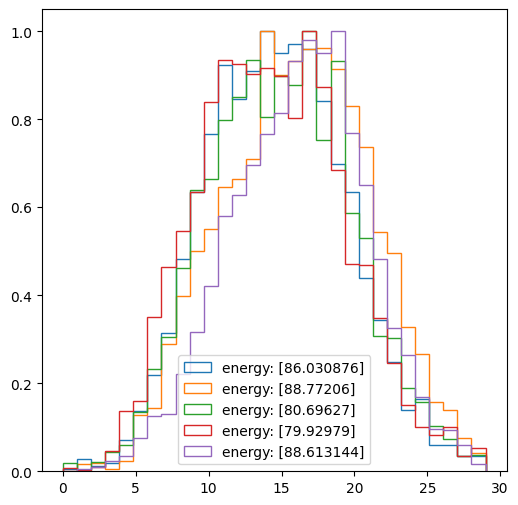

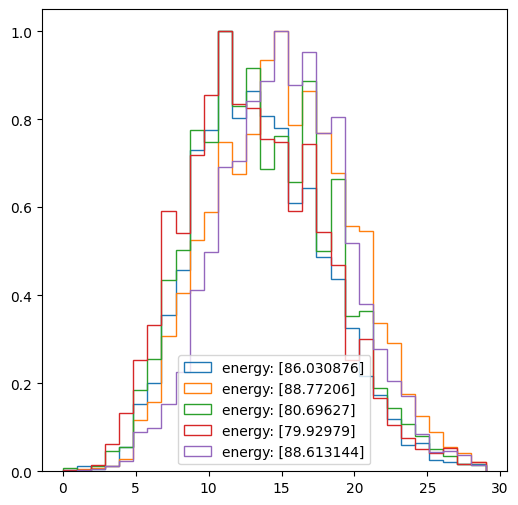

In [13]:
plt.figure(figsize=(6,6))
for i in range(500000, 500005):
    plt.hist(np.arange(30), weights=clusters_per_layer[i, :], label=f'energy: {energy[i]}', histtype='step', bins=30)
plt.legend()
plt.show()

plt.figure(figsize=(6,6))
for i in range(500000, 500000+5):
    plt.hist(np.arange(30), weights=e_per_layer[i, :], label=f'energy: {energy[i]}', histtype='step', bins=30)
plt.legend()
plt.show()

In [14]:
# center of gravity 

def get_cog(x,y,z,e):
    return np.sum((x * e), axis=1) / e.sum(axis=1), np.sum((y * e), axis=1) / e.sum(axis=1), np.sum((z * e), axis=1) / e.sum(axis=1)

cog = get_cog(
    events[:, 0],
    events[:, 1],
    events[:, 2],
    events[:, 3],
)


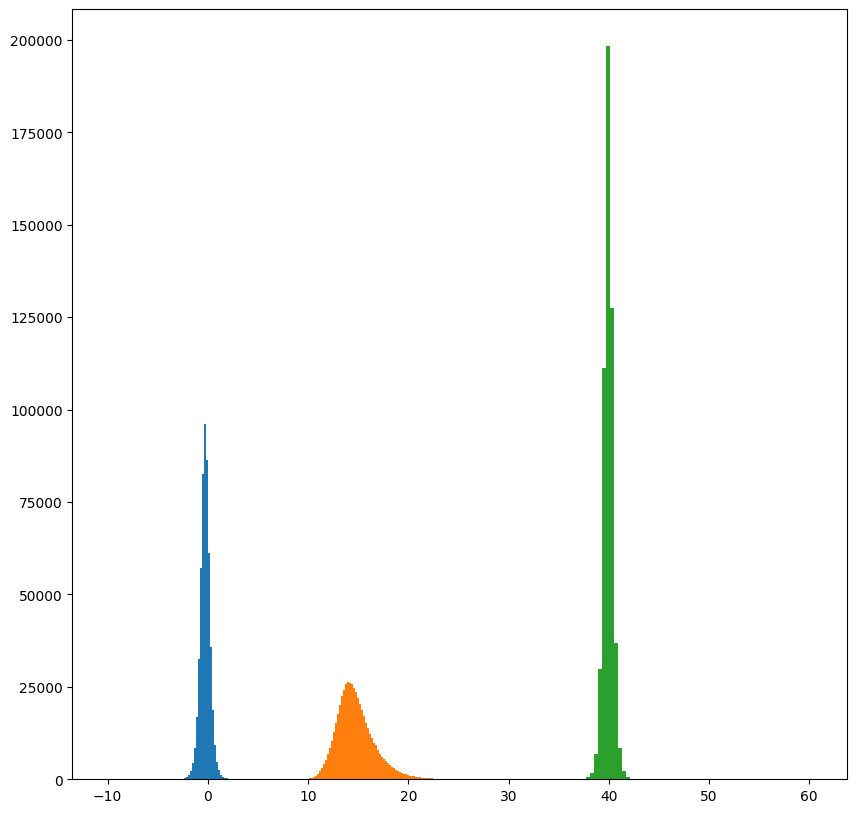

In [15]:
plt.figure(figsize=(10,10))
plt.hist(cog[0], bins=100, range=(-10, 10), label='x')
plt.hist(cog[1], bins=100)
plt.hist(cog[2], bins=100)
# plt.xlim(-10, 10)
plt.show()

In [16]:
# clusters_per_layer = clusters_per_layer / 400

df = pd.DataFrame([])
df['energy'] = energy[:].reshape(-1)   # normalisation done in training loop

df['num_points'] = num_points / 5000
df['visible_energy'] = visible_energy / 2.5 

df['cog_x'] = cog[0]
df['cog_y'] = cog[1] / 2 - 7.5
df['cog_z'] = cog[2] - 40

df['clusters_per_layer'] = clusters_per_layer.tolist()
df['e_per_layer'] = e_per_layer.tolist()

In [17]:
dataset = torch.utils.data.TensorDataset(
    torch.tensor(df.energy.values), 
    torch.tensor(df.num_points.values), 
    torch.tensor(df.visible_energy.values),
    torch.tensor(df.cog_x.values),
    torch.tensor(df.cog_y.values),
    torch.tensor(df.cog_z.values),
    torch.tensor(df.clusters_per_layer),
    torch.tensor(df.e_per_layer),
    )

In [18]:
train_loader = torch.utils.data.DataLoader(dataset, batch_size=params["batch_size"], shuffle=params["shuffle"], pin_memory=True)


In [19]:
batch = next(iter(train_loader))

In [20]:
for item in batch:
    print(item.shape)

torch.Size([2048])
torch.Size([2048])
torch.Size([2048])
torch.Size([2048])
torch.Size([2048])
torch.Size([2048])
torch.Size([2048, 30])
torch.Size([2048, 30])


In [21]:
output_path = '/beegfs/desy/user/buhmae/6_PointCloudDiffusion/shower_flow/'
prefix = '220713_cog_e_layer_'
outpath = output_path + prefix

In [22]:
torch.manual_seed(123)

lr = 5e-5
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

# epoch_load = 550
# model.load_state_dict(torch.load(outpath+f'ShowerFlow_{epoch_load}.pth')['model'])
# optimizer.load_state_dict(torch.load(outpath+f'ShowerFlow_{epoch_load}.pth')['optimizer'])

epoch_start = 1   # default = 1

In [23]:
model.train()

losses = []
for epoch in range(epoch_start, params["epochs"]+1):
    input_list = []
    loss_list = []
#     for batch_idx, (mu, logvar, e, theta, e_sum) in enumerate(train_loader):
    for batch_idx, (energy, num_points, visible_energy, cog_x, cog_y, cog_z, clusters_per_layer, e_per_layer) in enumerate(tqdm(train_loader)):

        E_true = energy.view(-1, 1).to(device).float()
        num_points = num_points.view(-1, 1).to(device).float()
        energy_sum = visible_energy.view(-1,1).to(device).float()
        cog_x = cog_x.view(-1, 1).to(device).float()
        cog_y = cog_y.view(-1, 1).to(device).float()
        cog_z = cog_z.view(-1, 1).to(device).float()
        clusters_per_layer = clusters_per_layer.to(device).float()
        e_per_layer = e_per_layer.to(device).float()
   
        # normalise conditional labels
        E_true = (E_true/100).float()

        input_data = torch.cat((num_points, energy_sum, cog_x, cog_y, cog_z, clusters_per_layer, e_per_layer), 1)   #### input data structure required for network with additional features in latent space (e.g. Esum)
        
        #input_data = torch.cat((z), 1)
        #input_data = z

        optimizer.zero_grad()

        # try to add context for conditioning by concatenating 
        context = E_true
        #print(theta_true.size())
        
        #nll = -distribution.condition(E_true).log_prob(input_data) ## solution   # does this work, or do need spearate .condition for each label?
        
        # if np.any(np.isnan(input_data.clone().detach().cpu().numpy())) == True:
        #     print('Nans in the training data!')
            
        #### check if any of the weights are nans
        if torch.stack([torch.isnan(p).any() for p in model.parameters()]).any():
            print('Weights are nan!')
            # load recent model
            model.load_state_dict(torch.load(outpath+f'ShowerFlow_latest.pth')['model'])
            optimizer.load_state_dict(torch.load(outpath+f'ShowerFlow_latest.pth')['optimizer'])
            # print(f'model from {epoch-3} epoch reloaded')
            print(f'latest model reloaded')
                           
        nll = -distribution.condition(context).log_prob(input_data)
        loss = nll.mean()
        #print(loss.item())
        loss.backward()

        optimizer.step() 

        distribution.clear_cache()
        
        loss_list.append(loss.item())
        # input_list.append(input_data.detach().cpu().numpy())

    print(epoch, np.mean(loss_list))
    losses.append(np.mean(loss_list))

    # save best model based on loss
    if epoch == 1:
        best_loss = np.mean(loss_list)
    if np.mean(loss_list) <= best_loss:
        best_loss = np.mean(loss_list)
        torch.save(
            {'model': model.state_dict(),
             'optimizer': optimizer.state_dict(),},
            outpath+f'ShowerFlow_best.pth'
        )
        print('best model saved')
    #############################
    # Log to COMET ML
    #############################
    torch.save(
        {'model': model.state_dict(),
         'optimizer': optimizer.state_dict(),},
        outpath+f'ShowerFlow_latest.pth'
    )

    if epoch%10 == 0:
        torch.save(
            {'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),},
            outpath+f'ShowerFlow_{epoch}.pth'
        )
        # print('model saved')



100%|██████████| 257/257 [01:06<00:00,  3.87it/s]


1 1371058.883770514
best model saved


100%|██████████| 257/257 [00:54<00:00,  4.76it/s]


2 -114.51468287367766
best model saved


100%|██████████| 257/257 [00:49<00:00,  5.24it/s]


3 -119.47498778703148
best model saved


100%|██████████| 257/257 [00:48<00:00,  5.31it/s]


4 -121.62458246134598
best model saved


100%|██████████| 257/257 [00:56<00:00,  4.56it/s]


5 -122.95156471460245
best model saved


100%|██████████| 257/257 [00:59<00:00,  4.30it/s]


6 -123.85987497767586
best model saved


100%|██████████| 257/257 [00:51<00:00,  5.03it/s]


7 -125.29405209433708
best model saved


100%|██████████| 257/257 [00:51<00:00,  4.97it/s]


8 -125.65892159428579
best model saved


100%|██████████| 257/257 [00:49<00:00,  5.14it/s]


9 -126.26620996972466
best model saved


100%|██████████| 257/257 [00:48<00:00,  5.25it/s]


10 -126.9556608385613
best model saved


100%|██████████| 257/257 [00:48<00:00,  5.26it/s]


11 -127.0895158047806
best model saved


100%|██████████| 257/257 [00:52<00:00,  4.90it/s]


12 -127.50137913922855
best model saved


100%|██████████| 257/257 [00:49<00:00,  5.22it/s]


13 -128.0914121694602
best model saved


100%|██████████| 257/257 [00:51<00:00,  5.00it/s]


14 -128.1552053963628
best model saved


100%|██████████| 257/257 [00:56<00:00,  4.54it/s]


15 -128.65568055624163
best model saved


100%|██████████| 257/257 [00:56<00:00,  4.54it/s]


16 -129.01948289091948
best model saved


100%|██████████| 257/257 [00:52<00:00,  4.91it/s]


17 -128.90793740239124


100%|██████████| 257/257 [01:03<00:00,  4.07it/s]


18 -129.31421860275566
best model saved


100%|██████████| 257/257 [00:55<00:00,  4.61it/s]


19 -129.6590034692668
best model saved


100%|██████████| 257/257 [01:01<00:00,  4.19it/s]


20 -129.99881468301618
best model saved


100%|██████████| 257/257 [00:51<00:00,  5.01it/s]


21 -130.1482616380031
best model saved


100%|██████████| 257/257 [00:54<00:00,  4.73it/s]


22 -130.3044392923437
best model saved


100%|██████████| 257/257 [00:56<00:00,  4.53it/s]


23 -130.56770487982013
best model saved


100%|██████████| 257/257 [00:56<00:00,  4.55it/s]


24 -130.7949340464076
best model saved


100%|██████████| 257/257 [00:56<00:00,  4.54it/s]


25 -130.84567311209
best model saved


100%|██████████| 257/257 [00:56<00:00,  4.58it/s]


26 -130.98898000754272
best model saved


100%|██████████| 257/257 [00:54<00:00,  4.74it/s]


27 -131.43523973991898
best model saved


100%|██████████| 257/257 [00:52<00:00,  4.92it/s]


28 -131.5178505864125
best model saved


100%|██████████| 257/257 [00:50<00:00,  5.05it/s]


29 -131.45318440240644


100%|██████████| 257/257 [00:54<00:00,  4.76it/s]


30 -131.78112772188297
best model saved


100%|██████████| 257/257 [00:51<00:00,  4.99it/s]


31 -131.76847067510107


100%|██████████| 257/257 [00:53<00:00,  4.76it/s]


32 -132.2257337162003
best model saved


100%|██████████| 257/257 [00:48<00:00,  5.27it/s]


33 -132.16321810117492


100%|██████████| 257/257 [00:52<00:00,  4.92it/s]


34 -132.26425806186543
best model saved


100%|██████████| 257/257 [00:51<00:00,  4.97it/s]


35 -132.35787551226784
best model saved


100%|██████████| 257/257 [00:56<00:00,  4.54it/s]


36 -132.6459875440783
best model saved


100%|██████████| 257/257 [00:56<00:00,  4.52it/s]


37 -132.87544998584553
best model saved


100%|██████████| 257/257 [00:55<00:00,  4.64it/s]


38 -132.84886769098065


100%|██████████| 257/257 [00:50<00:00,  5.10it/s]


39 -133.07080636228568
best model saved


100%|██████████| 257/257 [00:49<00:00,  5.22it/s]


40 -133.15531238600437
best model saved


100%|██████████| 257/257 [00:49<00:00,  5.24it/s]


41 -133.11147257882797


100%|██████████| 257/257 [00:49<00:00,  5.21it/s]


42 -133.49210847490957
best model saved


100%|██████████| 257/257 [00:55<00:00,  4.64it/s]


43 -133.21519493963933


100%|██████████| 257/257 [00:51<00:00,  4.97it/s]


44 -133.50107577431527
best model saved


100%|██████████| 257/257 [00:53<00:00,  4.84it/s]


45 -133.49978830656653


100%|██████████| 257/257 [00:51<00:00,  4.97it/s]


46 -133.62609429860393
best model saved


100%|██████████| 257/257 [00:49<00:00,  5.20it/s]


47 -133.7688054481833
best model saved


100%|██████████| 257/257 [00:49<00:00,  5.22it/s]


48 -133.85063812612097
best model saved


100%|██████████| 257/257 [00:49<00:00,  5.16it/s]


49 -133.96764851729694
best model saved


100%|██████████| 257/257 [00:49<00:00,  5.15it/s]


50 -134.2158122971828
best model saved


100%|██████████| 257/257 [00:49<00:00,  5.18it/s]


51 -134.30379233749923
best model saved


100%|██████████| 257/257 [00:56<00:00,  4.58it/s]


52 -134.28878582312439


100%|██████████| 257/257 [00:55<00:00,  4.65it/s]


53 -134.2823249430972


100%|██████████| 257/257 [00:54<00:00,  4.74it/s]


54 -134.61845659189188
best model saved


100%|██████████| 257/257 [00:51<00:00,  4.99it/s]


55 -134.603531536889


100%|██████████| 257/257 [00:51<00:00,  4.98it/s]


56 -134.70199923385442
best model saved


100%|██████████| 257/257 [00:51<00:00,  5.02it/s]


57 -134.8216177498784
best model saved


100%|██████████| 257/257 [00:51<00:00,  5.03it/s]


58 -134.74474230814536


100%|██████████| 257/257 [01:07<00:00,  3.80it/s]


59 -134.84237255289398
best model saved


100%|██████████| 257/257 [00:50<00:00,  5.05it/s]


60 -134.9228687212161
best model saved


100%|██████████| 257/257 [00:49<00:00,  5.21it/s]


61 -135.0296781666084
best model saved


100%|██████████| 257/257 [00:50<00:00,  5.11it/s]


62 -135.03487482330678
best model saved


100%|██████████| 257/257 [00:49<00:00,  5.18it/s]


63 -135.23206415436147
best model saved


100%|██████████| 257/257 [00:49<00:00,  5.23it/s]


64 -135.10213550612156


100%|██████████| 257/257 [00:52<00:00,  4.88it/s]


65 -135.42246005878374
best model saved


100%|██████████| 257/257 [00:49<00:00,  5.16it/s]


66 -135.3196767369133


100%|██████████| 257/257 [01:06<00:00,  3.84it/s]


67 -135.31500606314216


100%|██████████| 257/257 [00:53<00:00,  4.80it/s]


68 -135.46619471687288
best model saved


100%|██████████| 257/257 [00:52<00:00,  4.86it/s]


69 -135.52653669661586
best model saved


100%|██████████| 257/257 [00:54<00:00,  4.68it/s]


70 -135.5941253543364
best model saved


100%|██████████| 257/257 [00:55<00:00,  4.63it/s]


71 -135.4421578492636


100%|██████████| 257/257 [00:53<00:00,  4.79it/s]


72 -135.46928180145383


100%|██████████| 257/257 [00:49<00:00,  5.24it/s]


73 -135.47775933529152


100%|██████████| 257/257 [00:51<00:00,  4.97it/s]


74 -134.8979929764447


100%|██████████| 257/257 [01:00<00:00,  4.27it/s]


75 -135.36890586526476


100%|██████████| 257/257 [00:59<00:00,  4.35it/s]


76 -135.42710080870395


100%|██████████| 257/257 [01:01<00:00,  4.18it/s]


77 -135.55953884495835


100%|██████████| 257/257 [01:11<00:00,  3.60it/s]


78 -135.49959050634956


100%|██████████| 257/257 [00:54<00:00,  4.72it/s]


79 -135.36119898933381


100%|██████████| 257/257 [01:02<00:00,  4.12it/s]


80 -135.4993633463225


100%|██████████| 257/257 [00:56<00:00,  4.57it/s]


81 -135.45968093575206


100%|██████████| 257/257 [00:53<00:00,  4.80it/s]


82 -135.65254407355758
best model saved


100%|██████████| 257/257 [00:54<00:00,  4.74it/s]


83 -135.39039973989998


100%|██████████| 257/257 [00:49<00:00,  5.19it/s]


84 -134.8880301746413


100%|██████████| 257/257 [00:53<00:00,  4.80it/s]


85 -135.11743561859726


100%|██████████| 257/257 [00:53<00:00,  4.84it/s]


86 -135.18430355086863


100%|██████████| 257/257 [01:07<00:00,  3.80it/s]


87 -135.43310588435904


100%|██████████| 257/257 [01:00<00:00,  4.25it/s]


88 -135.12683022346943


100%|██████████| 257/257 [00:58<00:00,  4.37it/s]


89 -135.0208633957206


100%|██████████| 257/257 [00:54<00:00,  4.71it/s]


90 -135.15347854079903


100%|██████████| 257/257 [00:52<00:00,  4.88it/s]


91 -135.01578388139896


100%|██████████| 257/257 [00:56<00:00,  4.53it/s]


92 -134.9461448461629


100%|██████████| 257/257 [00:56<00:00,  4.54it/s]


93 -135.1499727004233


100%|██████████| 257/257 [00:52<00:00,  4.85it/s]


94 -134.8684921561512


100%|██████████| 257/257 [00:51<00:00,  4.95it/s]


95 -134.84030822278925


100%|██████████| 257/257 [00:50<00:00,  5.08it/s]


96 -134.54759661603995


100%|██████████| 257/257 [00:50<00:00,  5.05it/s]


97 -134.91955780148044


100%|██████████| 257/257 [00:59<00:00,  4.35it/s]


98 -134.9797898229458


100%|██████████| 257/257 [00:51<00:00,  4.98it/s]


99 -134.9857325572448


100%|██████████| 257/257 [00:49<00:00,  5.18it/s]


100 -135.06697177515883


100%|██████████| 257/257 [00:55<00:00,  4.63it/s]


101 -135.0005563223872


100%|██████████| 257/257 [00:55<00:00,  4.65it/s]


102 -135.4783297290134


100%|██████████| 257/257 [00:57<00:00,  4.48it/s]


103 -135.29227753279275


100%|██████████| 257/257 [00:57<00:00,  4.49it/s]


104 -135.40717811436042


100%|██████████| 257/257 [01:01<00:00,  4.20it/s]


105 -134.90928332258292


100%|██████████| 257/257 [00:51<00:00,  4.97it/s]


106 -135.5267827371679


100%|██████████| 257/257 [00:50<00:00,  5.06it/s]


107 -135.68277345649926
best model saved


100%|██████████| 257/257 [00:50<00:00,  5.10it/s]


108 -135.39049699241548


100%|██████████| 257/257 [00:53<00:00,  4.81it/s]


109 -135.61060983383237


100%|██████████| 257/257 [00:58<00:00,  4.39it/s]


110 -134.89308629611122


100%|██████████| 257/257 [01:07<00:00,  3.83it/s]


111 -135.5147713984033


100%|██████████| 257/257 [00:54<00:00,  4.74it/s]


112 -135.7118723828505
best model saved


100%|██████████| 257/257 [00:59<00:00,  4.32it/s]


113 -135.82055877804294
best model saved


100%|██████████| 257/257 [00:57<00:00,  4.46it/s]


114 -135.39994993098514


 14%|█▎        | 35/257 [00:07<00:47,  4.63it/s]

Weights are nan!


 14%|█▍        | 36/257 [00:08<01:48,  2.03it/s]

latest model reloaded


100%|██████████| 257/257 [00:50<00:00,  5.05it/s]


115 -135.88298669956075
best model saved


100%|██████████| 257/257 [00:51<00:00,  4.99it/s]


116 -136.24010292379774
best model saved


100%|██████████| 257/257 [00:51<00:00,  4.95it/s]


117 -135.95005180863555


100%|██████████| 257/257 [00:55<00:00,  4.66it/s]


118 -136.17164873056376


100%|██████████| 257/257 [01:00<00:00,  4.25it/s]


119 -136.23557444769122


100%|██████████| 257/257 [00:56<00:00,  4.51it/s]


120 -136.18237684672908


100%|██████████| 257/257 [00:49<00:00,  5.17it/s]


121 -136.29616994894897
best model saved


100%|██████████| 257/257 [00:50<00:00,  5.10it/s]


122 -135.76280485516855


100%|██████████| 257/257 [00:54<00:00,  4.72it/s]


123 -135.99660750214693


100%|██████████| 257/257 [00:54<00:00,  4.75it/s]


124 -136.67000844042587
best model saved


100%|██████████| 257/257 [00:48<00:00,  5.27it/s]


125 -136.43286014067058


100%|██████████| 257/257 [00:50<00:00,  5.12it/s]


126 -136.74885149410264
best model saved


100%|██████████| 257/257 [00:48<00:00,  5.32it/s]


127 -136.56244466462488


100%|██████████| 257/257 [00:49<00:00,  5.19it/s]


128 -136.9283799345855
best model saved


100%|██████████| 257/257 [00:49<00:00,  5.15it/s]


129 -136.9039516226327


100%|██████████| 257/257 [00:49<00:00,  5.22it/s]


130 -136.47994021404577


100%|██████████| 257/257 [00:48<00:00,  5.29it/s]


131 -136.70323828314991


100%|██████████| 257/257 [00:51<00:00,  5.02it/s]


132 -136.64590792526067


100%|██████████| 257/257 [00:50<00:00,  5.09it/s]


133 -136.83216881659246


100%|██████████| 257/257 [00:49<00:00,  5.15it/s]


134 -137.17705728850012
best model saved


100%|██████████| 257/257 [00:50<00:00,  5.09it/s]


135 -137.2496926868008
best model saved


100%|██████████| 257/257 [00:48<00:00,  5.25it/s]


136 -137.34433891801055
best model saved


100%|██████████| 257/257 [00:56<00:00,  4.57it/s]


137 -137.35152010787786
best model saved


100%|██████████| 257/257 [00:56<00:00,  4.51it/s]


138 -137.29963719705663


100%|██████████| 257/257 [00:57<00:00,  4.48it/s]


139 -137.62815459136368
best model saved


100%|██████████| 257/257 [00:56<00:00,  4.52it/s]


140 -137.5582907116367


100%|██████████| 257/257 [00:52<00:00,  4.87it/s]


141 -137.60277500968962


100%|██████████| 257/257 [00:54<00:00,  4.73it/s]


142 -137.6965199036357
best model saved


100%|██████████| 257/257 [00:54<00:00,  4.75it/s]


143 -137.47565825347306


100%|██████████| 257/257 [00:48<00:00,  5.25it/s]


144 -137.68745630167803


100%|██████████| 257/257 [00:55<00:00,  4.62it/s]


145 -137.88226472728448
best model saved


100%|██████████| 257/257 [00:54<00:00,  4.73it/s]


146 -137.745555833156


100%|██████████| 257/257 [00:49<00:00,  5.19it/s]


147 -137.86849500604177


100%|██████████| 257/257 [00:48<00:00,  5.27it/s]


148 -137.72594555806558


100%|██████████| 257/257 [00:49<00:00,  5.24it/s]


149 -138.09293380321697
best model saved


100%|██████████| 257/257 [00:50<00:00,  5.09it/s]


150 -137.90223396984055


100%|██████████| 257/257 [00:50<00:00,  5.05it/s]


151 -137.97389215254134


100%|██████████| 257/257 [00:52<00:00,  4.94it/s]


152 -138.11589240285673
best model saved


100%|██████████| 257/257 [00:49<00:00,  5.15it/s]


153 -138.30683049895885
best model saved


100%|██████████| 257/257 [00:49<00:00,  5.23it/s]


154 -137.8764766589213


100%|██████████| 257/257 [00:51<00:00,  4.96it/s]


155 -138.202414427286


100%|██████████| 257/257 [00:51<00:00,  5.00it/s]


156 -138.15137924016219


 44%|████▍     | 113/257 [00:21<00:24,  5.99it/s]

Weights are nan!


 44%|████▍     | 114/257 [00:22<01:05,  2.19it/s]

latest model reloaded


100%|██████████| 257/257 [00:50<00:00,  5.11it/s]


157 -138.1709353673319


100%|██████████| 257/257 [00:49<00:00,  5.20it/s]


158 -138.65949525350726
best model saved


100%|██████████| 257/257 [00:50<00:00,  5.08it/s]


159 -138.5335856040628


100%|██████████| 257/257 [00:49<00:00,  5.24it/s]


160 -138.6318182444294


100%|██████████| 257/257 [00:53<00:00,  4.77it/s]


161 -139.05718697277024
best model saved


100%|██████████| 257/257 [00:50<00:00,  5.06it/s]


162 -138.91421550349966


100%|██████████| 257/257 [00:52<00:00,  4.89it/s]


163 -138.49234448147192


100%|██████████| 257/257 [00:53<00:00,  4.82it/s]


164 -138.66862481855696


100%|██████████| 257/257 [00:49<00:00,  5.23it/s]


165 -138.82503744043728


100%|██████████| 257/257 [00:49<00:00,  5.15it/s]


166 -138.76926395401418


100%|██████████| 257/257 [00:51<00:00,  4.96it/s]


167 -138.7494345935866


100%|██████████| 257/257 [00:49<00:00,  5.16it/s]


168 -138.70307524566056


100%|██████████| 257/257 [00:55<00:00,  4.61it/s]


169 -138.56531658246823


100%|██████████| 257/257 [01:00<00:00,  4.23it/s]


170 -139.0909521199386
best model saved


100%|██████████| 257/257 [01:14<00:00,  3.46it/s]


171 -139.00249804782496


100%|██████████| 257/257 [00:59<00:00,  4.34it/s]


172 -139.10715962569537
best model saved


100%|██████████| 257/257 [00:52<00:00,  4.92it/s]


173 -139.13880789790173
best model saved


100%|██████████| 257/257 [00:53<00:00,  4.79it/s]


174 -139.42819077309932
best model saved


100%|██████████| 257/257 [00:51<00:00,  4.97it/s]


175 -139.30072852702457


100%|██████████| 257/257 [00:52<00:00,  4.91it/s]


176 -139.3837366957609


100%|██████████| 257/257 [00:56<00:00,  4.57it/s]


177 -139.12249322438518


100%|██████████| 257/257 [00:53<00:00,  4.78it/s]


178 -139.52530305023788
best model saved


100%|██████████| 257/257 [00:50<00:00,  5.06it/s]


179 -139.0507079246907


100%|██████████| 257/257 [00:55<00:00,  4.61it/s]


180 -139.53042412546358
best model saved


100%|██████████| 257/257 [00:50<00:00,  5.08it/s]


181 -139.54389615188776
best model saved


 49%|████▉     | 126/257 [00:24<00:41,  3.19it/s]

Weights are nan!


 49%|████▉     | 127/257 [00:25<01:15,  1.73it/s]

latest model reloaded


100%|██████████| 257/257 [00:50<00:00,  5.10it/s]


182 -139.80966150899806
best model saved


100%|██████████| 257/257 [00:50<00:00,  5.14it/s]


183 -139.7042676279981


100%|██████████| 257/257 [00:51<00:00,  5.01it/s]


184 -139.75486025086636


100%|██████████| 257/257 [00:49<00:00,  5.22it/s]


185 -140.0127549820837
best model saved


100%|██████████| 257/257 [00:58<00:00,  4.42it/s]


186 -140.00491962358646


100%|██████████| 257/257 [01:03<00:00,  4.07it/s]


187 -139.6557404039435


100%|██████████| 257/257 [01:01<00:00,  4.21it/s]


188 -140.06885139673136
best model saved


100%|██████████| 257/257 [00:53<00:00,  4.81it/s]


189 -139.95478981107127


100%|██████████| 257/257 [00:51<00:00,  4.98it/s]


190 -140.04088672682468


100%|██████████| 257/257 [00:48<00:00,  5.25it/s]


191 -140.18382292869953
best model saved


100%|██████████| 257/257 [00:49<00:00,  5.22it/s]


192 -140.32978684243525
best model saved


100%|██████████| 257/257 [00:50<00:00,  5.12it/s]


193 -140.3180224348135


100%|██████████| 257/257 [00:52<00:00,  4.90it/s]


194 -140.22383812336605


100%|██████████| 257/257 [00:56<00:00,  4.57it/s]


195 -140.5604600127105
best model saved


100%|██████████| 257/257 [00:51<00:00,  4.99it/s]


196 -140.84750799631794
best model saved


100%|██████████| 257/257 [00:52<00:00,  4.90it/s]


197 -140.74773362452882


100%|██████████| 257/257 [01:02<00:00,  4.09it/s]


198 -140.72776735060873


100%|██████████| 257/257 [01:00<00:00,  4.21it/s]


199 -140.60538224394682


 81%|████████  | 208/257 [00:47<00:09,  5.40it/s]

Weights are nan!


 81%|████████▏ | 209/257 [00:48<00:23,  2.07it/s]

latest model reloaded


100%|██████████| 257/257 [00:59<00:00,  4.35it/s]


200 -141.02736791469707
best model saved


100%|██████████| 257/257 [00:50<00:00,  5.05it/s]


201 -140.6255811401842


100%|██████████| 257/257 [00:49<00:00,  5.20it/s]


202 -140.9237308724845


100%|██████████| 257/257 [00:56<00:00,  4.53it/s]


203 -140.7703851484603


100%|██████████| 257/257 [00:53<00:00,  4.82it/s]


204 -141.02991191700738
best model saved


100%|██████████| 257/257 [00:49<00:00,  5.23it/s]


205 -141.074574036357
best model saved


100%|██████████| 257/257 [00:50<00:00,  5.11it/s]


206 -140.81295236075434


100%|██████████| 257/257 [00:52<00:00,  4.89it/s]


207 -141.17834039235393
best model saved


100%|██████████| 257/257 [00:56<00:00,  4.52it/s]


208 -140.9060508045241


100%|██████████| 257/257 [00:56<00:00,  4.55it/s]


209 -141.09241096704386


100%|██████████| 257/257 [00:56<00:00,  4.54it/s]


210 -141.28453099588475
best model saved


100%|██████████| 257/257 [00:56<00:00,  4.52it/s]


211 -141.13368432902178


100%|██████████| 257/257 [00:57<00:00,  4.50it/s]


212 -141.2098858310091


100%|██████████| 257/257 [00:51<00:00,  5.04it/s]


213 -141.259847499981


100%|██████████| 257/257 [00:53<00:00,  4.80it/s]


214 -141.1214593672103


100%|██████████| 257/257 [00:49<00:00,  5.17it/s]


215 -141.2205821827692


100%|██████████| 257/257 [00:50<00:00,  5.08it/s]


216 -141.90758368941133
best model saved


100%|██████████| 257/257 [00:50<00:00,  5.12it/s]


217 -141.4696351878838


100%|██████████| 257/257 [00:49<00:00,  5.24it/s]


218 -141.5248509269744


100%|██████████| 257/257 [00:59<00:00,  4.30it/s]


219 -141.85132299044716


 45%|████▍     | 115/257 [00:25<00:29,  4.88it/s]

Weights are nan!


 45%|████▌     | 116/257 [00:26<01:11,  1.98it/s]

latest model reloaded


100%|██████████| 257/257 [00:58<00:00,  4.42it/s]


220 -141.49228463377005


100%|██████████| 257/257 [00:55<00:00,  4.60it/s]


221 -141.80614462529638


100%|██████████| 257/257 [00:56<00:00,  4.51it/s]


222 -141.7408394423904


100%|██████████| 257/257 [00:55<00:00,  4.61it/s]


223 -141.578689218959


100%|██████████| 257/257 [00:50<00:00,  5.10it/s]


224 -141.72618940182696


 97%|█████████▋| 249/257 [00:49<00:01,  5.97it/s]

Weights are nan!


 97%|█████████▋| 250/257 [00:50<00:03,  2.15it/s]

latest model reloaded


100%|██████████| 257/257 [00:52<00:00,  4.87it/s]


225 -141.60734961839967


100%|██████████| 257/257 [00:49<00:00,  5.24it/s]


226 -142.11952298531736
best model saved


100%|██████████| 257/257 [00:48<00:00,  5.25it/s]


227 -141.80284587696832


100%|██████████| 257/257 [00:51<00:00,  5.02it/s]


228 -142.05605336942563


100%|██████████| 257/257 [00:50<00:00,  5.04it/s]


229 -142.2022743670393
best model saved


100%|██████████| 257/257 [00:55<00:00,  4.65it/s]


230 -141.79307758019593


100%|██████████| 257/257 [01:02<00:00,  4.11it/s]


231 -142.32950369393316
best model saved


100%|██████████| 257/257 [00:51<00:00,  5.02it/s]


232 -142.09037062351806


100%|██████████| 257/257 [00:49<00:00,  5.21it/s]


233 -142.40632866885412
best model saved


100%|██████████| 257/257 [00:50<00:00,  5.11it/s]


234 -142.22353900360227


100%|██████████| 257/257 [00:48<00:00,  5.26it/s]


235 -142.4874167238228
best model saved


100%|██████████| 257/257 [00:53<00:00,  4.81it/s]


236 -142.0857386013877


100%|██████████| 257/257 [00:55<00:00,  4.59it/s]


237 -142.3164842063815


100%|██████████| 257/257 [00:56<00:00,  4.55it/s]


238 -142.60083429358812
best model saved


100%|██████████| 257/257 [00:57<00:00,  4.50it/s]


239 -142.7425336429581
best model saved


100%|██████████| 257/257 [00:57<00:00,  4.49it/s]


240 -142.55831683563352


100%|██████████| 257/257 [00:57<00:00,  4.51it/s]


241 -142.7856720801921
best model saved


100%|██████████| 257/257 [00:57<00:00,  4.47it/s]


242 -142.59631187349905


100%|██████████| 257/257 [00:53<00:00,  4.77it/s]


243 -142.49475507328017


 46%|████▌     | 118/257 [00:22<00:23,  6.04it/s]

Weights are nan!


 46%|████▋     | 119/257 [00:23<01:04,  2.15it/s]

latest model reloaded


100%|██████████| 257/257 [00:50<00:00,  5.10it/s]


244 -142.75015110357262


100%|██████████| 257/257 [00:50<00:00,  5.12it/s]


245 -142.77811256735242


100%|██████████| 257/257 [00:56<00:00,  4.55it/s]


246 -142.65140821404958


100%|██████████| 257/257 [00:59<00:00,  4.28it/s]


247 -143.06338524725652
best model saved


100%|██████████| 257/257 [00:55<00:00,  4.59it/s]


248 -142.96652423546936


100%|██████████| 257/257 [00:56<00:00,  4.52it/s]


249 -143.02673909821863


100%|██████████| 257/257 [01:00<00:00,  4.27it/s]


250 -142.85619042541268


100%|██████████| 257/257 [00:56<00:00,  4.53it/s]


251 -142.91530641785855


100%|██████████| 257/257 [00:54<00:00,  4.68it/s]


252 -142.73168802817972


100%|██████████| 257/257 [00:55<00:00,  4.62it/s]


253 -143.25107903981487
best model saved


100%|██████████| 257/257 [00:55<00:00,  4.61it/s]


254 -143.1680716429239


100%|██████████| 257/257 [01:02<00:00,  4.13it/s]


255 -143.42023613480742
best model saved


100%|██████████| 257/257 [01:00<00:00,  4.28it/s]


256 -143.3530051383527


100%|██████████| 257/257 [01:01<00:00,  4.15it/s]


257 -143.44754354870273
best model saved


100%|██████████| 257/257 [01:02<00:00,  4.09it/s]


258 -143.44749806919916


100%|██████████| 257/257 [01:00<00:00,  4.27it/s]


259 -143.24800572970497


100%|██████████| 257/257 [00:50<00:00,  5.04it/s]


260 -143.46053833720285
best model saved


100%|██████████| 257/257 [01:06<00:00,  3.85it/s]


261 -143.2986697185828


100%|██████████| 257/257 [00:57<00:00,  4.50it/s]


262 -143.71110748409762
best model saved


100%|██████████| 257/257 [00:50<00:00,  5.11it/s]


263 -143.71336038196134
best model saved


100%|██████████| 257/257 [00:50<00:00,  5.05it/s]


264 -143.76424309993996
best model saved


100%|██████████| 257/257 [00:49<00:00,  5.19it/s]


265 -143.68058990597262


100%|██████████| 257/257 [00:56<00:00,  4.55it/s]


266 -143.68307097319962


100%|██████████| 257/257 [00:55<00:00,  4.60it/s]


267 -143.7140037447562


100%|██████████| 257/257 [00:58<00:00,  4.37it/s]


268 -143.7630627702646


100%|██████████| 257/257 [00:57<00:00,  4.48it/s]


269 -143.87923588734193
best model saved


100%|██████████| 257/257 [00:55<00:00,  4.60it/s]


270 -143.9606927656478
best model saved


100%|██████████| 257/257 [00:56<00:00,  4.58it/s]


271 -143.8686230136263


100%|██████████| 257/257 [00:56<00:00,  4.57it/s]


272 -143.8574662264219


100%|██████████| 257/257 [00:56<00:00,  4.56it/s]


273 -143.98332368724542
best model saved


100%|██████████| 257/257 [00:52<00:00,  4.89it/s]


274 -144.15059617335694
best model saved


100%|██████████| 257/257 [00:53<00:00,  4.79it/s]


275 -143.727767291236


100%|██████████| 257/257 [00:50<00:00,  5.07it/s]


276 -144.15708608664428
best model saved


100%|██████████| 257/257 [00:51<00:00,  4.97it/s]


277 -144.022497629841


100%|██████████| 257/257 [00:50<00:00,  5.09it/s]


278 -144.09573572062334


100%|██████████| 257/257 [00:50<00:00,  5.11it/s]


279 -144.2177255830876
best model saved


100%|██████████| 257/257 [00:50<00:00,  5.05it/s]


280 -144.32641358134347
best model saved


100%|██████████| 257/257 [00:48<00:00,  5.28it/s]


281 -144.33680665724935
best model saved


100%|██████████| 257/257 [00:51<00:00,  5.00it/s]


282 -144.38433434156127
best model saved


 46%|████▋     | 119/257 [00:23<00:33,  4.18it/s]

Weights are nan!


 47%|████▋     | 120/257 [00:24<01:11,  1.91it/s]

latest model reloaded


100%|██████████| 257/257 [00:53<00:00,  4.83it/s]


283 -144.30585197715908


100%|██████████| 257/257 [00:54<00:00,  4.71it/s]


284 -144.47285330805798
best model saved


100%|██████████| 257/257 [00:53<00:00,  4.85it/s]


285 -144.56806453007204
best model saved


100%|██████████| 257/257 [00:55<00:00,  4.66it/s]


286 -144.66317238418046
best model saved


100%|██████████| 257/257 [00:56<00:00,  4.59it/s]


287 -144.31770544386094


100%|██████████| 257/257 [00:56<00:00,  4.57it/s]


288 -144.55538786060615


100%|██████████| 257/257 [00:56<00:00,  4.57it/s]


289 -144.74933164128998
best model saved


100%|██████████| 257/257 [00:56<00:00,  4.58it/s]


290 -144.6635313516461


100%|██████████| 257/257 [00:55<00:00,  4.64it/s]


291 -144.74254700182013


100%|██████████| 257/257 [00:54<00:00,  4.70it/s]


292 -144.82220138371687
best model saved


100%|██████████| 257/257 [00:54<00:00,  4.68it/s]


293 -144.26435596748084


100%|██████████| 257/257 [00:53<00:00,  4.78it/s]


294 -144.83466929869894
best model saved


100%|██████████| 257/257 [00:56<00:00,  4.52it/s]


295 -144.66035241746718


100%|██████████| 257/257 [00:53<00:00,  4.81it/s]


296 -144.8909660962769
best model saved


100%|██████████| 257/257 [00:55<00:00,  4.61it/s]


297 -144.9251044603637
best model saved


100%|██████████| 257/257 [00:51<00:00,  4.98it/s]


298 -145.01904783731305
best model saved


 84%|████████▍ | 217/257 [00:41<00:06,  5.96it/s]

Weights are nan!


 85%|████████▍ | 218/257 [00:42<00:18,  2.11it/s]

latest model reloaded


 99%|█████████▉| 254/257 [00:50<00:00,  5.31it/s]

Weights are nan!


 99%|█████████▉| 255/257 [00:51<00:00,  2.18it/s]

latest model reloaded


100%|██████████| 257/257 [00:51<00:00,  4.95it/s]


299 2.9571899378978e+18


100%|██████████| 257/257 [00:51<00:00,  5.02it/s]


300 -142.05224072051882


100%|██████████| 257/257 [00:52<00:00,  4.92it/s]


301 34.10144333941464


100%|██████████| 257/257 [00:50<00:00,  5.13it/s]


302 -112.3052341743202


100%|██████████| 257/257 [00:53<00:00,  4.83it/s]


303 -119.02367303158059


100%|██████████| 257/257 [01:05<00:00,  3.90it/s]


304 -122.03114562275809


100%|██████████| 257/257 [00:56<00:00,  4.52it/s]


305 -123.84220856544108


100%|██████████| 257/257 [00:55<00:00,  4.59it/s]


306 -125.32763158300972


100%|██████████| 257/257 [00:56<00:00,  4.51it/s]


307 -126.17712936698231


100%|██████████| 257/257 [00:54<00:00,  4.70it/s]


308 -126.9819194036699


100%|██████████| 257/257 [00:57<00:00,  4.49it/s]


309 -127.6728938358767


100%|██████████| 257/257 [01:01<00:00,  4.17it/s]


310 -128.24528467794337


100%|██████████| 257/257 [00:57<00:00,  4.47it/s]


311 -128.75586166084972


100%|██████████| 257/257 [00:56<00:00,  4.54it/s]


312 -129.20099123349914


100%|██████████| 257/257 [00:56<00:00,  4.57it/s]


313 -129.5434141641461


100%|██████████| 257/257 [00:57<00:00,  4.50it/s]


314 -130.1324351269911


100%|██████████| 257/257 [00:56<00:00,  4.56it/s]


315 -130.2472717938256


100%|██████████| 257/257 [00:56<00:00,  4.57it/s]


316 -130.84152625414185


100%|██████████| 257/257 [01:03<00:00,  4.06it/s]


317 -131.09177894443854


100%|██████████| 257/257 [00:56<00:00,  4.58it/s]


318 -131.29547882080078


100%|██████████| 257/257 [00:50<00:00,  5.07it/s]


319 -131.63954186346746


100%|██████████| 257/257 [00:49<00:00,  5.22it/s]


320 -131.86907941172558


100%|██████████| 257/257 [00:56<00:00,  4.52it/s]


321 -132.01307850403543


100%|██████████| 257/257 [00:57<00:00,  4.50it/s]


322 -132.15001645811802


100%|██████████| 257/257 [00:59<00:00,  4.33it/s]


323 -132.6960024110074


100%|██████████| 257/257 [00:58<00:00,  4.43it/s]


324 -132.67849767068944


100%|██████████| 257/257 [00:55<00:00,  4.65it/s]


325 -132.9816050548034


100%|██████████| 257/257 [00:54<00:00,  4.69it/s]


326 -133.12338660570435


100%|██████████| 257/257 [00:56<00:00,  4.52it/s]


327 -133.29068848131232


100%|██████████| 257/257 [00:57<00:00,  4.48it/s]


328 -133.6000426771112


100%|██████████| 257/257 [00:56<00:00,  4.51it/s]


329 -133.67825643932773


100%|██████████| 257/257 [00:54<00:00,  4.72it/s]


330 -133.88480101114118


100%|██████████| 257/257 [00:55<00:00,  4.65it/s]


331 -134.04160697729208


100%|██████████| 257/257 [00:51<00:00,  4.95it/s]


332 -133.8850440236845


100%|██████████| 257/257 [00:50<00:00,  5.11it/s]


333 -134.4199266248176


100%|██████████| 257/257 [00:48<00:00,  5.29it/s]


334 -134.33447758418578


100%|██████████| 257/257 [00:48<00:00,  5.29it/s]


335 -134.25746202283332


100%|██████████| 257/257 [00:50<00:00,  5.09it/s]


336 -134.68784507424914


100%|██████████| 257/257 [00:50<00:00,  5.14it/s]


337 -134.63238994435113


100%|██████████| 257/257 [00:50<00:00,  5.11it/s]


338 -134.98566807847078


100%|██████████| 257/257 [00:50<00:00,  5.13it/s]


339 -134.82486163781311


100%|██████████| 257/257 [00:49<00:00,  5.23it/s]


340 -134.9517458904578


100%|██████████| 257/257 [00:48<00:00,  5.27it/s]


341 -135.08505088717092


100%|██████████| 257/257 [00:52<00:00,  4.89it/s]


342 -135.1302782941885


100%|██████████| 257/257 [00:50<00:00,  5.12it/s]


343 -135.42116009307742


100%|██████████| 257/257 [00:53<00:00,  4.82it/s]


344 -135.31903705522708


100%|██████████| 257/257 [01:07<00:00,  3.81it/s]


345 -135.5400884012304


100%|██████████| 257/257 [01:03<00:00,  4.02it/s]


346 -135.67670206151584


100%|██████████| 257/257 [00:52<00:00,  4.93it/s]


347 -135.89403044110605


100%|██████████| 257/257 [00:58<00:00,  4.40it/s]


348 -135.92792318024988


100%|██████████| 257/257 [01:03<00:00,  4.02it/s]


349 -136.15447238076058


100%|██████████| 257/257 [01:08<00:00,  3.76it/s]


350 -136.1414410186649


100%|██████████| 257/257 [01:02<00:00,  4.11it/s]


351 -136.1601512626915


100%|██████████| 257/257 [00:59<00:00,  4.30it/s]


352 -136.2040649295317


100%|██████████| 257/257 [01:07<00:00,  3.83it/s]


353 -136.20628689420826


100%|██████████| 257/257 [01:01<00:00,  4.18it/s]


354 -136.39601218375714


100%|██████████| 257/257 [01:01<00:00,  4.17it/s]


355 -136.65330149134772


100%|██████████| 257/257 [01:01<00:00,  4.15it/s]


356 -136.77370550845848


100%|██████████| 257/257 [01:02<00:00,  4.14it/s]


357 -136.67346654513466


100%|██████████| 257/257 [01:04<00:00,  4.01it/s]


358 -136.55214343831696


100%|██████████| 257/257 [00:53<00:00,  4.79it/s]


359 -136.6467890757995


100%|██████████| 257/257 [00:48<00:00,  5.31it/s]


360 -136.96889148519196


100%|██████████| 257/257 [00:48<00:00,  5.27it/s]


361 -137.12761376525643


100%|██████████| 257/257 [00:51<00:00,  5.01it/s]


362 -137.26670035870623


100%|██████████| 257/257 [00:50<00:00,  5.08it/s]


363 -137.09769567348613


100%|██████████| 257/257 [00:51<00:00,  4.98it/s]


364 -137.2354360498807


100%|██████████| 257/257 [00:48<00:00,  5.26it/s]


365 -137.22692028001126


100%|██████████| 257/257 [00:48<00:00,  5.26it/s]


366 -137.71908124040536


100%|██████████| 257/257 [00:48<00:00,  5.27it/s]


367 -137.73744937881887


100%|██████████| 257/257 [00:51<00:00,  5.04it/s]


368 -137.68732395988494


100%|██████████| 257/257 [00:49<00:00,  5.16it/s]


369 -137.7488744713453


100%|██████████| 257/257 [00:49<00:00,  5.19it/s]


370 -137.65476336646174


100%|██████████| 257/257 [00:48<00:00,  5.30it/s]


371 -137.78416799107416


100%|██████████| 257/257 [00:52<00:00,  4.90it/s]


372 -137.6614505159252


100%|██████████| 257/257 [00:52<00:00,  4.86it/s]


373 -137.98293426157434


 44%|████▍     | 113/257 [00:22<00:25,  5.73it/s]

Weights are nan!


 44%|████▍     | 114/257 [00:23<01:07,  2.12it/s]

latest model reloaded


100%|██████████| 257/257 [00:52<00:00,  4.90it/s]


374 -137.72494815574083


 68%|██████▊   | 175/257 [00:35<00:26,  3.11it/s]

Weights are nan!


 68%|██████▊   | 176/257 [00:36<00:47,  1.72it/s]

latest model reloaded


100%|██████████| 257/257 [00:52<00:00,  4.92it/s]


375 -138.05399539220193


100%|██████████| 257/257 [00:49<00:00,  5.24it/s]


376 -138.08965464788653


100%|██████████| 257/257 [00:50<00:00,  5.14it/s]


377 -138.0373883674117


100%|██████████| 257/257 [00:49<00:00,  5.23it/s]


378 -137.9204420987734


100%|██████████| 257/257 [00:49<00:00,  5.16it/s]


379 -138.26914574292846


  1%|          | 3/257 [00:00<00:49,  5.09it/s]

Weights are nan!


  2%|▏         | 4/257 [00:01<02:25,  1.74it/s]

latest model reloaded


 43%|████▎     | 110/257 [00:23<00:27,  5.39it/s]

Weights are nan!


 43%|████▎     | 111/257 [00:25<01:29,  1.62it/s]

latest model reloaded


100%|██████████| 257/257 [00:55<00:00,  4.61it/s]


380 -137.84353857374376


100%|██████████| 257/257 [00:57<00:00,  4.48it/s]


381 -137.90661015492006


100%|██████████| 257/257 [00:52<00:00,  4.93it/s]


382 -138.2395368049117


100%|██████████| 257/257 [00:49<00:00,  5.20it/s]


383 -138.29502227426966


100%|██████████| 257/257 [00:55<00:00,  4.64it/s]


384 -138.49004622285005


100%|██████████| 257/257 [00:56<00:00,  4.51it/s]


385 -138.4488094344677


100%|██████████| 257/257 [00:56<00:00,  4.54it/s]


386 -138.2545437942683


  4%|▎         | 9/257 [00:01<00:51,  4.77it/s]

Weights are nan!


  4%|▍         | 10/257 [00:03<02:47,  1.47it/s]

latest model reloaded


100%|██████████| 257/257 [00:54<00:00,  4.67it/s]


387 -138.21820062422103


100%|██████████| 257/257 [00:51<00:00,  5.04it/s]


388 -138.53346537430463


100%|██████████| 257/257 [00:53<00:00,  4.83it/s]


389 -138.68922394630047


100%|██████████| 257/257 [00:49<00:00,  5.15it/s]


390 -139.0074705131323


100%|██████████| 257/257 [00:53<00:00,  4.85it/s]


391 -138.63335712596137


100%|██████████| 257/257 [00:50<00:00,  5.12it/s]


392 -138.80274096537192


100%|██████████| 257/257 [00:56<00:00,  4.54it/s]


393 -138.6894505126003


100%|██████████| 257/257 [01:03<00:00,  4.08it/s]


394 -138.8628354796176


100%|██████████| 257/257 [00:59<00:00,  4.35it/s]


395 -139.09067971789884


100%|██████████| 257/257 [00:51<00:00,  5.01it/s]


396 -139.10736731147023


100%|██████████| 257/257 [00:55<00:00,  4.62it/s]


397 -139.3445314637418


100%|██████████| 257/257 [00:56<00:00,  4.53it/s]


398 -139.4733135653841


100%|██████████| 257/257 [00:56<00:00,  4.57it/s]


399 -139.29391556676723


100%|██████████| 257/257 [00:53<00:00,  4.81it/s]


400 -139.67420638859969


100%|██████████| 257/257 [00:48<00:00,  5.26it/s]


401 -139.6313287163523


100%|██████████| 257/257 [00:51<00:00,  5.04it/s]


402 -139.7816983234094


100%|██████████| 257/257 [00:52<00:00,  4.88it/s]


403 -139.65248790696438


100%|██████████| 257/257 [00:50<00:00,  5.13it/s]


404 -139.66355789125197


100%|██████████| 257/257 [00:49<00:00,  5.15it/s]


405 -139.24096893429294


100%|██████████| 257/257 [00:49<00:00,  5.24it/s]


406 -139.6721709136369


100%|██████████| 257/257 [00:48<00:00,  5.25it/s]


407 -139.77069329287755


100%|██████████| 257/257 [00:48<00:00,  5.28it/s]


408 -139.82757978031142


100%|██████████| 257/257 [00:51<00:00,  4.99it/s]


409 -140.1244436776128


100%|██████████| 257/257 [00:49<00:00,  5.23it/s]


410 -140.31683052745774


100%|██████████| 257/257 [00:49<00:00,  5.23it/s]


411 -140.002558489254


100%|██████████| 257/257 [00:49<00:00,  5.24it/s]


412 -140.0886023851684


100%|██████████| 257/257 [00:51<00:00,  4.99it/s]


413 -140.09864801191634


100%|██████████| 257/257 [00:49<00:00,  5.15it/s]


414 -140.39447431156142


100%|██████████| 257/257 [00:56<00:00,  4.55it/s]


415 -140.51936577822912


100%|██████████| 257/257 [00:52<00:00,  4.91it/s]


416 -140.775137578467


100%|██████████| 257/257 [00:52<00:00,  4.94it/s]


417 -140.78566074000258


100%|██████████| 257/257 [00:52<00:00,  4.94it/s]


418 -140.55965343430813


100%|██████████| 257/257 [00:52<00:00,  4.91it/s]


419 -140.87782382594008


100%|██████████| 257/257 [00:50<00:00,  5.07it/s]


420 -141.0087015471106


100%|██████████| 257/257 [00:53<00:00,  4.81it/s]


421 -140.6311679350263


100%|██████████| 257/257 [00:55<00:00,  4.61it/s]


422 -140.5672583672787


100%|██████████| 257/257 [00:58<00:00,  4.39it/s]


423 -140.72724813617157


100%|██████████| 257/257 [00:56<00:00,  4.55it/s]


424 -140.91240516989149


100%|██████████| 257/257 [00:56<00:00,  4.58it/s]


425 -141.08531871751126


100%|██████████| 257/257 [01:01<00:00,  4.16it/s]


426 -141.02922634020854


 64%|██████▍   | 165/257 [00:37<00:22,  4.09it/s]

Weights are nan!


 65%|██████▍   | 166/257 [00:38<00:48,  1.87it/s]

latest model reloaded


100%|██████████| 257/257 [00:58<00:00,  4.42it/s]


427 -141.0897071333711


100%|██████████| 257/257 [00:52<00:00,  4.91it/s]


428 -141.27946139680736


100%|██████████| 257/257 [00:53<00:00,  4.83it/s]


429 -141.42627445918578


100%|██████████| 257/257 [01:07<00:00,  3.80it/s]


430 -141.46378483753725


100%|██████████| 257/257 [01:01<00:00,  4.19it/s]


431 -141.61556822780506


 98%|█████████▊| 252/257 [01:09<00:01,  4.70it/s]

Weights are nan!


 98%|█████████▊| 253/257 [01:10<00:02,  1.89it/s]

latest model reloaded


100%|██████████| 257/257 [01:11<00:00,  3.58it/s]


432 -141.58350915574843


100%|██████████| 257/257 [01:00<00:00,  4.22it/s]


433 -141.75068670488054


100%|██████████| 257/257 [00:58<00:00,  4.40it/s]


434 -141.77943515406508


100%|██████████| 257/257 [00:54<00:00,  4.72it/s]


435 -141.80591342792437


100%|██████████| 257/257 [00:56<00:00,  4.55it/s]


436 -141.72773522996718


100%|██████████| 257/257 [00:56<00:00,  4.55it/s]


437 -142.09892136391963


100%|██████████| 257/257 [00:56<00:00,  4.51it/s]


438 -141.9712957241192


100%|██████████| 257/257 [00:52<00:00,  4.90it/s]


439 -141.51374686274548


100%|██████████| 257/257 [00:49<00:00,  5.24it/s]


440 -141.8328035703429


100%|██████████| 257/257 [01:03<00:00,  4.04it/s]


441 -141.6912144167414


100%|██████████| 257/257 [00:50<00:00,  5.12it/s]


442 -142.15273264131656


100%|██████████| 257/257 [00:49<00:00,  5.18it/s]


443 -142.3851935835664


100%|██████████| 257/257 [00:50<00:00,  5.05it/s]


444 -142.1136944247591


100%|██████████| 257/257 [00:49<00:00,  5.24it/s]


445 -142.11316553256856


100%|██████████| 257/257 [00:56<00:00,  4.57it/s]


446 -141.97885019027768


100%|██████████| 257/257 [01:05<00:00,  3.90it/s]


447 -142.13401562879986


100%|██████████| 257/257 [01:07<00:00,  3.81it/s]


448 -142.4085604300295


100%|██████████| 257/257 [01:07<00:00,  3.81it/s]


449 -142.1669307367347


100%|██████████| 257/257 [01:11<00:00,  3.61it/s]


450 -141.81198209176267


100%|██████████| 257/257 [01:06<00:00,  3.86it/s]


451 -142.44219792584965


100%|██████████| 257/257 [01:00<00:00,  4.28it/s]


452 -142.56972649125274


 26%|██▌       | 66/257 [00:16<01:24,  2.27it/s]

Weights are nan!


 26%|██▌       | 67/257 [00:17<02:08,  1.48it/s]

latest model reloaded


100%|██████████| 257/257 [01:05<00:00,  3.95it/s]


453 -142.60508342104663


100%|██████████| 257/257 [01:02<00:00,  4.12it/s]


454 -142.52387062399305


100%|██████████| 257/257 [01:00<00:00,  4.21it/s]


455 -142.3715456951453


100%|██████████| 257/257 [01:00<00:00,  4.26it/s]


456 -142.70942527681936


  9%|▊         | 22/257 [00:05<00:48,  4.85it/s]

Weights are nan!


  9%|▉         | 23/257 [00:06<01:58,  1.98it/s]

latest model reloaded


100%|██████████| 257/257 [01:00<00:00,  4.22it/s]


457 -142.44292910089752


 91%|█████████ | 233/257 [00:51<00:04,  5.28it/s]

Weights are nan!


 91%|█████████ | 234/257 [00:52<00:11,  2.06it/s]

latest model reloaded


100%|██████████| 257/257 [00:57<00:00,  4.44it/s]


458 -143.00272556408834


100%|██████████| 257/257 [00:57<00:00,  4.48it/s]


459 -142.82754605660642


 75%|███████▍  | 192/257 [00:42<00:12,  5.11it/s]

Weights are nan!


 75%|███████▌  | 193/257 [00:44<00:32,  1.99it/s]

latest model reloaded


100%|██████████| 257/257 [00:57<00:00,  4.43it/s]


460 -142.48895679280915


100%|██████████| 257/257 [01:01<00:00,  4.20it/s]


461 -142.63616094329478


100%|██████████| 257/257 [00:49<00:00,  5.19it/s]


462 -142.90841668867415


100%|██████████| 257/257 [00:48<00:00,  5.26it/s]


463 -142.89603789214493


100%|██████████| 257/257 [00:48<00:00,  5.26it/s]


464 -143.1816214476114


100%|██████████| 257/257 [00:49<00:00,  5.22it/s]


465 -143.14277726110316


 10%|▉         | 25/257 [00:04<00:41,  5.63it/s]

Weights are nan!


 10%|█         | 26/257 [00:06<01:51,  2.08it/s]

latest model reloaded


100%|██████████| 257/257 [00:53<00:00,  4.77it/s]


466 -142.9138549923433


100%|██████████| 257/257 [00:56<00:00,  4.53it/s]


467 -143.05889506655444


100%|██████████| 257/257 [00:55<00:00,  4.62it/s]


468 -143.01059636809947


100%|██████████| 257/257 [00:55<00:00,  4.65it/s]


469 -143.16962892999908


100%|██████████| 257/257 [00:54<00:00,  4.68it/s]


470 -143.09283969745562


100%|██████████| 257/257 [00:50<00:00,  5.08it/s]


471 -143.23571403295614


100%|██████████| 257/257 [00:52<00:00,  4.86it/s]


472 -143.4655504634872


100%|██████████| 257/257 [00:53<00:00,  4.80it/s]


473 -143.42904057484193


 63%|██████▎   | 162/257 [00:31<00:16,  5.83it/s]

Weights are nan!


 63%|██████▎   | 163/257 [00:32<00:44,  2.13it/s]

latest model reloaded


100%|██████████| 257/257 [00:50<00:00,  5.13it/s]


474 -143.5589743885085


100%|██████████| 257/257 [00:49<00:00,  5.24it/s]


475 -143.37965066516446


100%|██████████| 257/257 [00:53<00:00,  4.79it/s]


476 -143.73645720129346


100%|██████████| 257/257 [00:53<00:00,  4.83it/s]


477 -143.72336367595983


100%|██████████| 257/257 [01:09<00:00,  3.69it/s]


478 -143.48085170404457


100%|██████████| 257/257 [01:06<00:00,  3.88it/s]


479 -143.88047303671038


100%|██████████| 257/257 [01:03<00:00,  4.07it/s]


480 -143.7619138487582


100%|██████████| 257/257 [01:05<00:00,  3.94it/s]


481 -144.10772230096364


100%|██████████| 257/257 [01:02<00:00,  4.08it/s]


482 -143.95429446446755


100%|██████████| 257/257 [01:09<00:00,  3.70it/s]


483 -144.1327601926336


100%|██████████| 257/257 [01:02<00:00,  4.09it/s]


484 -143.8996960235477


100%|██████████| 257/257 [00:58<00:00,  4.36it/s]


485 -143.88076764414745


100%|██████████| 257/257 [00:53<00:00,  4.84it/s]


486 -144.24191895718704


100%|██████████| 257/257 [00:55<00:00,  4.61it/s]


487 -144.185805443196


100%|██████████| 257/257 [00:50<00:00,  5.05it/s]


488 -144.10571864977885


100%|██████████| 257/257 [00:53<00:00,  4.79it/s]


489 -144.317542109508


100%|██████████| 257/257 [00:55<00:00,  4.59it/s]


490 -144.38143855588444


100%|██████████| 257/257 [00:50<00:00,  5.09it/s]


491 -144.29663572793805


100%|██████████| 257/257 [00:52<00:00,  4.89it/s]


492 -144.55567314652617


100%|██████████| 257/257 [00:54<00:00,  4.75it/s]


493 -144.57733385850483


 74%|███████▎  | 189/257 [00:41<00:15,  4.42it/s]

Weights are nan!


 74%|███████▍  | 190/257 [00:42<00:35,  1.91it/s]

latest model reloaded


100%|██████████| 257/257 [00:57<00:00,  4.46it/s]


494 3.924478145241391e+17


100%|██████████| 257/257 [00:56<00:00,  4.55it/s]


495 -144.4548555366724


100%|██████████| 257/257 [00:57<00:00,  4.50it/s]


496 -144.47794060020595


100%|██████████| 257/257 [00:59<00:00,  4.35it/s]


497 -144.53818069636125


100%|██████████| 257/257 [00:52<00:00,  4.92it/s]


498 -144.71993555447472


100%|██████████| 257/257 [00:56<00:00,  4.52it/s]


499 -144.54981139661737


100%|██████████| 257/257 [00:55<00:00,  4.64it/s]


500 -144.44364584837442


100%|██████████| 257/257 [00:52<00:00,  4.90it/s]


501 -144.5959921514014


100%|██████████| 257/257 [00:52<00:00,  4.91it/s]


502 -144.81327065790674


100%|██████████| 257/257 [00:52<00:00,  4.93it/s]


503 -144.65350044933274


100%|██████████| 257/257 [00:53<00:00,  4.80it/s]


504 -144.9074506351456


100%|██████████| 257/257 [00:55<00:00,  4.67it/s]


505 -144.91044836378282


100%|██████████| 257/257 [00:56<00:00,  4.57it/s]


506 -144.94591442063626


 40%|███▉      | 102/257 [00:22<00:32,  4.77it/s]

Weights are nan!


 40%|████      | 103/257 [00:23<01:17,  1.99it/s]

latest model reloaded


100%|██████████| 257/257 [00:57<00:00,  4.46it/s]


507 2.1450641404721943e+18


100%|██████████| 257/257 [00:56<00:00,  4.53it/s]


508 -144.68344086524579


100%|██████████| 257/257 [00:56<00:00,  4.53it/s]


509 -145.0372929554505
best model saved


100%|██████████| 257/257 [00:56<00:00,  4.56it/s]


510 -145.15974111594116
best model saved


100%|██████████| 257/257 [00:50<00:00,  5.10it/s]


511 -144.9410115995296


100%|██████████| 257/257 [00:49<00:00,  5.19it/s]


512 -145.19054213943184
best model saved


100%|██████████| 257/257 [00:49<00:00,  5.22it/s]


513 -145.0909834687348


100%|██████████| 257/257 [00:50<00:00,  5.08it/s]


514 -144.99899523545795


100%|██████████| 257/257 [00:54<00:00,  4.68it/s]


515 -144.82580607967154


100%|██████████| 257/257 [00:50<00:00,  5.06it/s]


516 -144.73882712278848


100%|██████████| 257/257 [00:52<00:00,  4.92it/s]


517 -145.40714741866412
best model saved


100%|██████████| 257/257 [00:49<00:00,  5.18it/s]


518 -145.12431293888315


 79%|███████▉  | 203/257 [00:40<00:08,  6.02it/s]

Weights are nan!


 79%|███████▉  | 204/257 [00:41<00:24,  2.18it/s]

latest model reloaded


100%|██████████| 257/257 [00:51<00:00,  4.96it/s]


519 2.0875834675400624e+21


 23%|██▎       | 58/257 [00:11<00:34,  5.83it/s]

Weights are nan!


 23%|██▎       | 59/257 [00:12<01:29,  2.20it/s]

latest model reloaded


 25%|██▍       | 64/257 [00:13<00:41,  4.67it/s]

Weights are nan!


 25%|██▌       | 65/257 [00:14<01:27,  2.19it/s]

latest model reloaded


 41%|████      | 105/257 [00:21<00:25,  6.04it/s]

Weights are nan!


 41%|████      | 106/257 [00:23<01:27,  1.72it/s]

latest model reloaded


 77%|███████▋  | 197/257 [00:40<00:10,  6.00it/s]

Weights are nan!


 77%|███████▋  | 198/257 [00:41<00:25,  2.29it/s]

latest model reloaded


 93%|█████████▎| 239/257 [00:49<00:02,  6.05it/s]

Weights are nan!


 93%|█████████▎| 240/257 [00:50<00:07,  2.36it/s]

latest model reloaded


100%|██████████| 257/257 [00:53<00:00,  4.81it/s]


520 2.0306621991615753e+22


 14%|█▎        | 35/257 [00:06<00:37,  5.99it/s]

Weights are nan!


 14%|█▍        | 36/257 [00:07<01:36,  2.30it/s]

latest model reloaded


 21%|██        | 54/257 [00:11<00:33,  5.98it/s]

Weights are nan!


 21%|██▏       | 55/257 [00:12<01:25,  2.35it/s]

latest model reloaded


 58%|█████▊    | 148/257 [00:30<00:18,  5.76it/s]

Weights are nan!


 58%|█████▊    | 149/257 [00:31<00:48,  2.23it/s]

latest model reloaded


 66%|██████▌   | 169/257 [00:36<00:19,  4.43it/s]

Weights are nan!


 66%|██████▌   | 170/257 [00:37<00:44,  1.94it/s]

latest model reloaded


 72%|███████▏  | 185/257 [00:41<00:14,  4.94it/s]

Weights are nan!


 72%|███████▏  | 186/257 [00:42<00:32,  2.18it/s]

latest model reloaded


 74%|███████▍  | 190/257 [00:43<00:16,  4.01it/s]

Weights are nan!


 74%|███████▍  | 191/257 [00:44<00:32,  2.05it/s]

latest model reloaded


 78%|███████▊  | 200/257 [00:46<00:11,  4.88it/s]

Weights are nan!


 78%|███████▊  | 201/257 [00:47<00:25,  2.21it/s]

latest model reloaded


 95%|█████████▍| 243/257 [00:56<00:02,  5.32it/s]

Weights are nan!


 95%|█████████▍| 244/257 [00:57<00:05,  2.23it/s]

latest model reloaded


100%|██████████| 257/257 [01:00<00:00,  4.25it/s]


521 9.89733365219493e+21


  8%|▊         | 20/257 [00:04<00:46,  5.05it/s]

Weights are nan!


  8%|▊         | 21/257 [00:05<01:50,  2.15it/s]

latest model reloaded


 18%|█▊        | 46/257 [00:10<00:38,  5.41it/s]

Weights are nan!


 18%|█▊        | 47/257 [00:11<01:34,  2.23it/s]

latest model reloaded


 30%|██▉       | 76/257 [00:18<00:37,  4.81it/s]

Weights are nan!


 30%|██▉       | 77/257 [00:19<01:21,  2.20it/s]

latest model reloaded


 50%|█████     | 129/257 [00:30<00:36,  3.55it/s]

Weights are nan!


 51%|█████     | 130/257 [00:31<01:05,  1.94it/s]

latest model reloaded


 72%|███████▏  | 185/257 [00:41<00:11,  6.02it/s]

Weights are nan!


 72%|███████▏  | 186/257 [00:43<00:42,  1.67it/s]

latest model reloaded


 76%|███████▋  | 196/257 [00:45<00:10,  5.61it/s]

Weights are nan!


 77%|███████▋  | 197/257 [00:46<00:27,  2.18it/s]

latest model reloaded


100%|██████████| 257/257 [00:57<00:00,  4.45it/s]


522 4.725958836283599e+21


  1%|          | 3/257 [00:00<00:43,  5.83it/s]

Weights are nan!


  2%|▏         | 4/257 [00:01<02:20,  1.81it/s]

latest model reloaded


 45%|████▍     | 115/257 [00:25<00:25,  5.46it/s]

Weights are nan!


 45%|████▌     | 116/257 [00:26<01:05,  2.16it/s]

latest model reloaded


 72%|███████▏  | 186/257 [00:41<00:14,  4.87it/s]

Weights are nan!


 73%|███████▎  | 187/257 [00:43<00:33,  2.11it/s]

latest model reloaded


100%|██████████| 257/257 [00:57<00:00,  4.45it/s]


523 1.562127934691477e+21


 42%|████▏     | 108/257 [00:21<00:25,  5.74it/s]

Weights are nan!


 42%|████▏     | 109/257 [00:22<01:07,  2.20it/s]

latest model reloaded


100%|██████████| 257/257 [00:50<00:00,  5.04it/s]


524 5.148800821914751e+20


 11%|█         | 27/257 [00:05<00:40,  5.75it/s]

Weights are nan!


 11%|█         | 28/257 [00:06<01:46,  2.15it/s]

latest model reloaded


 24%|██▎       | 61/257 [00:13<00:41,  4.73it/s]

Weights are nan!


 24%|██▍       | 62/257 [00:14<01:35,  2.05it/s]

latest model reloaded


100%|██████████| 257/257 [00:53<00:00,  4.82it/s]


525 1.2664402706461991e+20


  6%|▌         | 16/257 [00:03<01:22,  2.93it/s]

Weights are nan!


  7%|▋         | 17/257 [00:04<02:21,  1.70it/s]

latest model reloaded


 29%|██▉       | 74/257 [00:16<00:49,  3.69it/s]

Weights are nan!


 29%|██▉       | 75/257 [00:17<01:35,  1.90it/s]

latest model reloaded


 35%|███▌      | 91/257 [00:20<00:52,  3.16it/s]

Weights are nan!


 36%|███▌      | 92/257 [00:21<01:29,  1.84it/s]

latest model reloaded


 41%|████      | 106/257 [00:24<00:25,  5.91it/s]

Weights are nan!


 42%|████▏     | 107/257 [00:25<01:05,  2.27it/s]

latest model reloaded


 64%|██████▍   | 165/257 [00:36<00:15,  5.98it/s]

Weights are nan!


 65%|██████▍   | 166/257 [00:37<00:38,  2.35it/s]

latest model reloaded


 73%|███████▎  | 188/257 [00:42<00:16,  4.19it/s]

Weights are nan!


 74%|███████▎  | 189/257 [00:43<00:32,  2.09it/s]

latest model reloaded


 87%|████████▋ | 223/257 [00:49<00:05,  6.05it/s]

Weights are nan!


 87%|████████▋ | 224/257 [00:50<00:19,  1.71it/s]

latest model reloaded


100%|██████████| 257/257 [00:56<00:00,  4.52it/s]


526 7.1490596846378615e+19


 98%|█████████▊| 252/257 [00:49<00:00,  5.85it/s]

Weights are nan!


 98%|█████████▊| 253/257 [00:50<00:01,  2.17it/s]

latest model reloaded


100%|██████████| 257/257 [00:51<00:00,  4.99it/s]


527 9.374611705183425e+19


  6%|▌         | 16/257 [00:03<00:42,  5.61it/s]

Weights are nan!


  7%|▋         | 17/257 [00:04<01:53,  2.12it/s]

latest model reloaded


 18%|█▊        | 47/257 [00:10<00:47,  4.46it/s]

Weights are nan!


 19%|█▊        | 48/257 [00:11<01:41,  2.05it/s]

latest model reloaded


 34%|███▍      | 87/257 [00:19<00:32,  5.27it/s]

Weights are nan!


 34%|███▍      | 88/257 [00:20<01:16,  2.21it/s]

latest model reloaded


 89%|████████▉ | 229/257 [00:48<00:04,  5.96it/s]

Weights are nan!


 89%|████████▉ | 230/257 [00:49<00:11,  2.32it/s]

latest model reloaded


 90%|█████████ | 232/257 [00:49<00:07,  3.26it/s]

Weights are nan!


 91%|█████████ | 233/257 [00:50<00:12,  1.87it/s]

latest model reloaded


 97%|█████████▋| 249/257 [00:54<00:01,  5.71it/s]

Weights are nan!


 97%|█████████▋| 250/257 [00:55<00:03,  2.28it/s]

latest model reloaded


100%|██████████| 257/257 [00:56<00:00,  4.53it/s]


528 8.710436588782189e+19


  4%|▍         | 11/257 [00:01<00:42,  5.77it/s]

Weights are nan!


  5%|▍         | 12/257 [00:03<01:53,  2.15it/s]

latest model reloaded


  9%|▉         | 24/257 [00:05<00:42,  5.47it/s]

Weights are nan!


 10%|▉         | 25/257 [00:06<01:44,  2.22it/s]

latest model reloaded


 39%|███▊      | 99/257 [00:21<00:30,  5.24it/s]

Weights are nan!


 39%|███▉      | 100/257 [00:22<01:13,  2.14it/s]

latest model reloaded


 74%|███████▎  | 189/257 [00:40<00:12,  5.40it/s]

Weights are nan!


 74%|███████▍  | 190/257 [00:42<00:41,  1.60it/s]

latest model reloaded


 80%|████████  | 206/257 [00:44<00:08,  5.94it/s]

Weights are nan!


 81%|████████  | 207/257 [00:46<00:30,  1.64it/s]

latest model reloaded


100%|█████████▉| 256/257 [00:56<00:00,  5.61it/s]

Weights are nan!


100%|██████████| 257/257 [00:57<00:00,  4.49it/s]

latest model reloaded
529 5.461904206018371e+19



 31%|███       | 79/257 [00:15<00:31,  5.71it/s]

Weights are nan!


 31%|███       | 80/257 [00:16<01:20,  2.21it/s]

latest model reloaded


 36%|███▌      | 93/257 [00:19<00:30,  5.38it/s]

Weights are nan!


 37%|███▋      | 94/257 [00:20<01:13,  2.22it/s]

latest model reloaded


100%|██████████| 257/257 [00:55<00:00,  4.63it/s]


530 8.61491860818602e+19


 44%|████▍     | 113/257 [00:24<00:27,  5.26it/s]

Weights are nan!


 44%|████▍     | 114/257 [00:25<01:07,  2.10it/s]

latest model reloaded


 47%|████▋     | 120/257 [00:27<00:30,  4.48it/s]

Weights are nan!


 47%|████▋     | 121/257 [00:28<01:05,  2.08it/s]

latest model reloaded


 51%|█████▏    | 132/257 [00:30<00:26,  4.74it/s]

Weights are nan!


 52%|█████▏    | 133/257 [00:31<00:59,  2.10it/s]

latest model reloaded


 59%|█████▉    | 152/257 [00:35<00:17,  5.94it/s]

Weights are nan!


 60%|█████▉    | 153/257 [00:36<00:46,  2.25it/s]

latest model reloaded


 72%|███████▏  | 186/257 [00:46<00:18,  3.91it/s]

Weights are nan!


 73%|███████▎  | 187/257 [00:47<00:37,  1.89it/s]

latest model reloaded


 81%|████████  | 208/257 [00:51<00:09,  5.28it/s]

Weights are nan!


 81%|████████▏ | 209/257 [00:52<00:21,  2.21it/s]

latest model reloaded


100%|██████████| 257/257 [01:02<00:00,  4.10it/s]


531 4.368741875416748e+19


 81%|████████  | 207/257 [00:40<00:08,  5.96it/s]

Weights are nan!


 81%|████████  | 208/257 [00:41<00:22,  2.22it/s]

latest model reloaded


 92%|█████████▏| 237/257 [00:47<00:04,  4.98it/s]

Weights are nan!


 93%|█████████▎| 238/257 [00:48<00:08,  2.13it/s]

latest model reloaded


100%|██████████| 257/257 [00:52<00:00,  4.94it/s]


532 3.2327957855928033e+19


  6%|▌         | 16/257 [00:03<01:05,  3.68it/s]

Weights are nan!


  7%|▋         | 17/257 [00:04<02:03,  1.94it/s]

latest model reloaded


 15%|█▍        | 38/257 [00:08<00:41,  5.22it/s]

Weights are nan!


 15%|█▌        | 39/257 [00:09<01:38,  2.22it/s]

latest model reloaded


 28%|██▊       | 71/257 [00:15<00:58,  3.18it/s]

Weights are nan!


 28%|██▊       | 72/257 [00:16<01:38,  1.87it/s]

latest model reloaded


 46%|████▌     | 117/257 [00:25<00:24,  5.71it/s]

Weights are nan!


 46%|████▌     | 118/257 [00:26<01:02,  2.24it/s]

latest model reloaded


 57%|█████▋    | 147/257 [00:32<00:34,  3.16it/s]

Weights are nan!


 58%|█████▊    | 148/257 [00:33<00:58,  1.87it/s]

latest model reloaded


100%|██████████| 257/257 [00:53<00:00,  4.77it/s]


533 3.5355563118671802e+19


  3%|▎         | 7/257 [00:01<01:21,  3.06it/s]

Weights are nan!


  3%|▎         | 8/257 [00:02<02:25,  1.71it/s]

latest model reloaded


 32%|███▏      | 81/257 [00:16<00:29,  6.02it/s]

Weights are nan!


 32%|███▏      | 82/257 [00:17<01:18,  2.23it/s]

latest model reloaded


 33%|███▎      | 85/257 [00:18<01:02,  2.73it/s]

Weights are nan!


 33%|███▎      | 86/257 [00:19<01:37,  1.75it/s]

latest model reloaded


 74%|███████▍  | 190/257 [00:39<00:11,  5.85it/s]

Weights are nan!


 74%|███████▍  | 191/257 [00:40<00:29,  2.22it/s]

latest model reloaded


 86%|████████▌ | 221/257 [00:46<00:08,  4.22it/s]

Weights are nan!


 86%|████████▋ | 222/257 [00:47<00:17,  2.03it/s]

latest model reloaded


100%|█████████▉| 256/257 [00:53<00:00,  6.02it/s]

Weights are nan!


100%|██████████| 257/257 [00:55<00:00,  4.67it/s]

latest model reloaded
534 2.5809038509343257e+19



 52%|█████▏    | 133/257 [00:25<00:20,  6.01it/s]

Weights are nan!


 52%|█████▏    | 134/257 [00:26<00:56,  2.19it/s]

latest model reloaded


 92%|█████████▏| 237/257 [00:46<00:04,  4.59it/s]

Weights are nan!


 93%|█████████▎| 238/257 [00:47<00:09,  2.04it/s]

latest model reloaded


100%|██████████| 257/257 [00:51<00:00,  5.02it/s]


535 2.4587579520705212e+19


 11%|█▏        | 29/257 [00:05<00:37,  6.01it/s]

Weights are nan!


 12%|█▏        | 30/257 [00:06<01:41,  2.25it/s]

latest model reloaded


 15%|█▍        | 38/257 [00:08<00:50,  4.31it/s]

Weights are nan!


 15%|█▌        | 39/257 [00:09<01:45,  2.06it/s]

latest model reloaded


 21%|██        | 53/257 [00:12<01:04,  3.17it/s]

Weights are nan!


 21%|██        | 54/257 [00:13<01:48,  1.87it/s]

latest model reloaded


 35%|███▌      | 91/257 [00:20<00:52,  3.18it/s]

Weights are nan!


 36%|███▌      | 92/257 [00:21<01:28,  1.87it/s]

latest model reloaded


 69%|██████▉   | 177/257 [00:38<00:15,  5.15it/s]

Weights are nan!


 69%|██████▉   | 178/257 [00:39<00:36,  2.18it/s]

latest model reloaded


100%|██████████| 257/257 [00:54<00:00,  4.72it/s]


536 2.5292201183713755e+19


 75%|███████▍  | 192/257 [00:36<00:11,  5.48it/s]

Weights are nan!


 75%|███████▌  | 193/257 [00:37<00:29,  2.17it/s]

latest model reloaded


 91%|█████████ | 234/257 [00:45<00:03,  5.86it/s]

Weights are nan!


 91%|█████████▏| 235/257 [00:46<00:09,  2.29it/s]

latest model reloaded


100%|██████████| 257/257 [00:50<00:00,  5.06it/s]


537 2.418995777865512e+19


 11%|█▏        | 29/257 [00:05<00:49,  4.63it/s]

Weights are nan!


 12%|█▏        | 30/257 [00:06<01:47,  2.11it/s]

latest model reloaded


 23%|██▎       | 60/257 [00:12<00:32,  6.05it/s]

Weights are nan!


 24%|██▎       | 61/257 [00:13<01:24,  2.31it/s]

latest model reloaded


 31%|███       | 79/257 [00:16<00:29,  6.03it/s]

Weights are nan!


 31%|███       | 80/257 [00:17<01:17,  2.30it/s]

latest model reloaded


 57%|█████▋    | 146/257 [00:30<00:22,  5.00it/s]

Weights are nan!


 57%|█████▋    | 147/257 [00:31<00:48,  2.27it/s]

latest model reloaded


 68%|██████▊   | 176/257 [00:37<00:13,  6.06it/s]

Weights are nan!


 69%|██████▉   | 177/257 [00:38<00:33,  2.36it/s]

latest model reloaded


 71%|███████   | 182/257 [00:39<00:19,  3.86it/s]

Weights are nan!


 71%|███████   | 183/257 [00:40<00:36,  2.00it/s]

latest model reloaded


 81%|████████▏ | 209/257 [00:45<00:08,  5.95it/s]

Weights are nan!


 82%|████████▏ | 210/257 [00:46<00:20,  2.29it/s]

latest model reloaded


100%|██████████| 257/257 [00:55<00:00,  4.63it/s]


538 2.1804331078325334e+19


 16%|█▌        | 40/257 [00:07<00:58,  3.72it/s]

Weights are nan!


 16%|█▌        | 41/257 [00:08<01:49,  1.97it/s]

latest model reloaded


 33%|███▎      | 86/257 [00:17<00:29,  5.85it/s]

Weights are nan!


 34%|███▍      | 87/257 [00:18<01:13,  2.30it/s]

latest model reloaded


 36%|███▌      | 93/257 [00:19<00:32,  5.08it/s]

Weights are nan!


 37%|███▋      | 94/257 [00:20<01:13,  2.22it/s]

latest model reloaded


 46%|████▌     | 117/257 [00:24<00:33,  4.21it/s]

Weights are nan!


 46%|████▌     | 118/257 [00:26<01:07,  2.06it/s]

latest model reloaded


 61%|██████▏   | 158/257 [00:33<00:19,  5.00it/s]

Weights are nan!


 62%|██████▏   | 159/257 [00:34<00:44,  2.21it/s]

latest model reloaded


 65%|██████▌   | 168/257 [00:36<00:15,  5.64it/s]

Weights are nan!


 66%|██████▌   | 169/257 [00:37<00:38,  2.31it/s]

latest model reloaded


 67%|██████▋   | 171/257 [00:38<00:38,  2.24it/s]

Weights are nan!


 67%|██████▋   | 172/257 [00:39<00:52,  1.62it/s]

latest model reloaded


 79%|███████▊  | 202/257 [00:44<00:09,  5.97it/s]

Weights are nan!


 79%|███████▉  | 203/257 [00:45<00:23,  2.31it/s]

latest model reloaded


100%|██████████| 257/257 [00:56<00:00,  4.58it/s]


539 1.9958264275098493e+19


 41%|████      | 106/257 [00:21<00:25,  5.96it/s]

Weights are nan!


 42%|████▏     | 107/257 [00:22<01:07,  2.23it/s]

latest model reloaded


 71%|███████   | 182/257 [00:37<00:12,  5.78it/s]

Weights are nan!


 71%|███████   | 183/257 [00:38<00:32,  2.28it/s]

latest model reloaded


 88%|████████▊ | 227/257 [00:47<00:06,  4.49it/s]

Weights are nan!


 89%|████████▊ | 228/257 [00:48<00:14,  2.07it/s]

latest model reloaded


 95%|█████████▍| 244/257 [00:51<00:03,  4.19it/s]

Weights are nan!


 95%|█████████▌| 245/257 [00:53<00:05,  2.03it/s]

latest model reloaded


100%|██████████| 257/257 [00:55<00:00,  4.66it/s]


540 2.0186840438250705e+19


 11%|█▏        | 29/257 [00:06<00:44,  5.07it/s]

Weights are nan!


 12%|█▏        | 30/257 [00:07<01:44,  2.16it/s]

latest model reloaded


 37%|███▋      | 95/257 [00:19<00:31,  5.15it/s]

Weights are nan!


 37%|███▋      | 96/257 [00:21<01:15,  2.14it/s]

latest model reloaded


 57%|█████▋    | 146/257 [00:31<00:25,  4.42it/s]

Weights are nan!


 57%|█████▋    | 147/257 [00:33<00:55,  2.00it/s]

latest model reloaded


 74%|███████▍  | 191/257 [00:42<00:13,  5.08it/s]

Weights are nan!


 75%|███████▍  | 192/257 [00:43<00:31,  2.09it/s]

latest model reloaded


100%|██████████| 257/257 [00:57<00:00,  4.43it/s]


541 2.136812096175192e+19


  7%|▋         | 18/257 [00:03<00:47,  4.99it/s]

Weights are nan!


  7%|▋         | 19/257 [00:05<02:33,  1.55it/s]

latest model reloaded
Weights are nan!


  8%|▊         | 20/257 [00:06<03:04,  1.29it/s]

latest model reloaded


 42%|████▏     | 108/257 [00:25<00:30,  4.87it/s]

Weights are nan!


 42%|████▏     | 109/257 [00:26<01:14,  2.00it/s]

latest model reloaded


 58%|█████▊    | 150/257 [00:35<00:20,  5.29it/s]

Weights are nan!


 59%|█████▉    | 151/257 [00:36<00:51,  2.07it/s]

latest model reloaded


 60%|█████▉    | 154/257 [00:37<00:45,  2.26it/s]

Weights are nan!


 60%|██████    | 155/257 [00:38<01:06,  1.52it/s]

latest model reloaded


 85%|████████▌ | 219/257 [00:52<00:08,  4.72it/s]

Weights are nan!


 86%|████████▌ | 220/257 [00:53<00:18,  2.01it/s]

latest model reloaded


100%|██████████| 257/257 [01:02<00:00,  4.14it/s]


542 1.7813404091790154e+19


  8%|▊         | 21/257 [00:04<00:46,  5.05it/s]

Weights are nan!


  9%|▊         | 22/257 [00:05<01:53,  2.07it/s]

latest model reloaded


 18%|█▊        | 45/257 [00:10<00:42,  4.97it/s]

Weights are nan!


 18%|█▊        | 46/257 [00:11<01:40,  2.09it/s]

latest model reloaded


 73%|███████▎  | 187/257 [00:43<00:23,  2.95it/s]

Weights are nan!


 73%|███████▎  | 188/257 [00:44<00:40,  1.72it/s]

latest model reloaded


100%|██████████| 257/257 [00:59<00:00,  4.33it/s]


543 1.4936326916552118e+19


 25%|██▍       | 64/257 [00:13<00:38,  5.00it/s]

Weights are nan!


 25%|██▌       | 65/257 [00:15<01:33,  2.05it/s]

latest model reloaded


 88%|████████▊ | 225/257 [00:50<00:08,  3.79it/s]

Weights are nan!


 88%|████████▊ | 226/257 [00:51<00:16,  1.87it/s]

latest model reloaded


 95%|█████████▍| 244/257 [00:56<00:03,  3.75it/s]

Weights are nan!


 95%|█████████▌| 245/257 [00:57<00:06,  1.84it/s]

latest model reloaded


100%|██████████| 257/257 [00:59<00:00,  4.32it/s]


544 1.3032025564497857e+19


 30%|███       | 78/257 [00:17<00:35,  4.98it/s]

Weights are nan!


 31%|███       | 79/257 [00:18<01:28,  2.00it/s]

latest model reloaded


 45%|████▌     | 116/257 [00:27<00:28,  4.99it/s]

Weights are nan!


 46%|████▌     | 117/257 [00:28<01:07,  2.06it/s]

latest model reloaded


 72%|███████▏  | 185/257 [00:43<00:15,  4.61it/s]

Weights are nan!


 72%|███████▏  | 186/257 [00:44<00:34,  2.04it/s]

latest model reloaded


 77%|███████▋  | 199/257 [00:47<00:14,  3.93it/s]

Weights are nan!


 78%|███████▊  | 200/257 [00:48<00:29,  1.92it/s]

latest model reloaded


 86%|████████▌ | 220/257 [00:52<00:07,  4.76it/s]

Weights are nan!


 86%|████████▌ | 221/257 [00:54<00:17,  2.07it/s]

latest model reloaded


100%|██████████| 257/257 [01:01<00:00,  4.16it/s]


545 1.3989159722430126e+19


 18%|█▊        | 45/257 [00:09<00:40,  5.26it/s]

Weights are nan!


 18%|█▊        | 46/257 [00:11<01:43,  2.04it/s]

latest model reloaded


 28%|██▊       | 73/257 [00:17<01:03,  2.88it/s]

Weights are nan!


 29%|██▉       | 74/257 [00:18<01:46,  1.72it/s]

latest model reloaded


 65%|██████▍   | 167/257 [00:36<00:15,  5.97it/s]

Weights are nan!


 65%|██████▌   | 168/257 [00:38<00:40,  2.21it/s]

latest model reloaded


 91%|█████████ | 233/257 [00:51<00:05,  4.70it/s]

Weights are nan!


 91%|█████████ | 234/257 [00:52<00:11,  2.02it/s]

latest model reloaded


100%|██████████| 257/257 [00:57<00:00,  4.50it/s]


546 1.2888176317053497e+19


 23%|██▎       | 59/257 [00:11<00:33,  5.93it/s]

Weights are nan!


 23%|██▎       | 60/257 [00:12<01:29,  2.19it/s]

latest model reloaded


 28%|██▊       | 73/257 [00:15<00:35,  5.19it/s]

Weights are nan!


 29%|██▉       | 74/257 [00:16<01:23,  2.19it/s]

latest model reloaded


 44%|████▍     | 113/257 [00:23<00:27,  5.30it/s]

Weights are nan!


 44%|████▍     | 114/257 [00:24<01:07,  2.13it/s]

latest model reloaded


100%|██████████| 257/257 [00:54<00:00,  4.71it/s]


547 1.2349383119676406e+19


 35%|███▌      | 91/257 [00:19<00:33,  4.91it/s]

Weights are nan!


 36%|███▌      | 92/257 [00:20<01:21,  2.03it/s]

latest model reloaded


 49%|████▉     | 126/257 [00:28<00:30,  4.23it/s]

Weights are nan!


 49%|████▉     | 127/257 [00:29<01:04,  2.02it/s]

latest model reloaded


 55%|█████▍    | 141/257 [00:32<00:38,  2.99it/s]

Weights are nan!


 55%|█████▌    | 142/257 [00:33<01:04,  1.80it/s]

latest model reloaded


 66%|██████▌   | 169/257 [00:38<00:16,  5.22it/s]

Weights are nan!


 66%|██████▌   | 170/257 [00:39<00:39,  2.21it/s]

latest model reloaded


 68%|██████▊   | 174/257 [00:40<00:20,  4.02it/s]

Weights are nan!


 68%|██████▊   | 175/257 [00:41<00:40,  2.03it/s]

latest model reloaded


 74%|███████▍  | 191/257 [00:45<00:12,  5.33it/s]

Weights are nan!


 75%|███████▍  | 192/257 [00:46<00:28,  2.26it/s]

latest model reloaded


100%|██████████| 257/257 [00:59<00:00,  4.32it/s]


548 1.1122407956071279e+19


 23%|██▎       | 58/257 [00:12<00:47,  4.18it/s]

Weights are nan!


 23%|██▎       | 59/257 [00:13<01:39,  2.00it/s]

latest model reloaded


 27%|██▋       | 69/257 [00:15<00:38,  4.82it/s]

Weights are nan!


 27%|██▋       | 70/257 [00:16<01:29,  2.09it/s]

latest model reloaded


 41%|████      | 105/257 [00:24<00:28,  5.27it/s]

Weights are nan!


 41%|████      | 106/257 [00:25<01:08,  2.21it/s]

latest model reloaded


 95%|█████████▍| 244/257 [00:52<00:02,  6.01it/s]

Weights are nan!


 95%|█████████▌| 245/257 [00:53<00:05,  2.27it/s]

latest model reloaded


100%|██████████| 257/257 [00:55<00:00,  4.59it/s]


549 1.0355853256649562e+19


 17%|█▋        | 44/257 [00:09<00:43,  4.90it/s]

Weights are nan!


 18%|█▊        | 45/257 [00:10<01:46,  1.99it/s]

latest model reloaded


 38%|███▊      | 98/257 [00:22<00:33,  4.78it/s]

Weights are nan!


 39%|███▊      | 99/257 [00:23<01:16,  2.06it/s]

latest model reloaded


 42%|████▏     | 107/257 [00:25<00:33,  4.54it/s]

Weights are nan!


 42%|████▏     | 108/257 [00:26<01:38,  1.52it/s]

latest model reloaded


 44%|████▍     | 113/257 [00:27<00:39,  3.67it/s]

Weights are nan!


 44%|████▍     | 114/257 [00:29<01:16,  1.88it/s]

latest model reloaded


 57%|█████▋    | 147/257 [00:36<00:26,  4.09it/s]

Weights are nan!


 58%|█████▊    | 148/257 [00:37<00:55,  1.96it/s]

latest model reloaded


 74%|███████▍  | 190/257 [00:46<00:14,  4.56it/s]

Weights are nan!


 74%|███████▍  | 191/257 [00:48<00:33,  1.99it/s]

latest model reloaded


 98%|█████████▊| 252/257 [01:01<00:01,  4.72it/s]

Weights are nan!


 98%|█████████▊| 253/257 [01:02<00:01,  2.00it/s]

latest model reloaded


100%|██████████| 257/257 [01:03<00:00,  4.04it/s]


550 1.0050555730507846e+19


 10%|▉         | 25/257 [00:05<00:53,  4.36it/s]

Weights are nan!


 10%|█         | 26/257 [00:07<02:00,  1.92it/s]

latest model reloaded


 48%|████▊     | 124/257 [00:28<00:26,  5.01it/s]

Weights are nan!


 49%|████▊     | 125/257 [00:29<01:02,  2.10it/s]

latest model reloaded


 51%|█████     | 130/257 [00:30<00:31,  4.09it/s]

Weights are nan!


 51%|█████     | 131/257 [00:31<01:04,  1.95it/s]

latest model reloaded


 56%|█████▌    | 144/257 [00:34<00:22,  5.03it/s]

Weights are nan!


 56%|█████▋    | 145/257 [00:35<00:53,  2.10it/s]

latest model reloaded


 61%|██████    | 157/257 [00:38<00:27,  3.66it/s]

Weights are nan!


 61%|██████▏   | 158/257 [00:39<00:52,  1.88it/s]

latest model reloaded


 79%|███████▊  | 202/257 [00:48<00:09,  5.78it/s]

Weights are nan!


 79%|███████▉  | 203/257 [00:49<00:23,  2.30it/s]

latest model reloaded


 98%|█████████▊| 253/257 [00:59<00:01,  3.97it/s]

Weights are nan!


 99%|█████████▉| 254/257 [01:00<00:01,  1.94it/s]

latest model reloaded


100%|██████████| 257/257 [01:01<00:00,  4.19it/s]


551 9.728006394179107e+18


 13%|█▎        | 34/257 [00:06<01:12,  3.09it/s]

Weights are nan!


 14%|█▎        | 35/257 [00:08<02:06,  1.75it/s]

latest model reloaded


 19%|█▉        | 50/257 [00:10<00:36,  5.72it/s]

Weights are nan!


 20%|█▉        | 51/257 [00:12<02:02,  1.69it/s]

latest model reloaded


 98%|█████████▊| 252/257 [00:50<00:00,  5.00it/s]

Weights are nan!


 98%|█████████▊| 253/257 [00:51<00:01,  2.11it/s]

latest model reloaded


100%|██████████| 257/257 [00:52<00:00,  4.88it/s]


552 9.827300803617194e+18


 25%|██▌       | 65/257 [00:12<00:31,  6.01it/s]

Weights are nan!


 26%|██▌       | 66/257 [00:13<01:26,  2.20it/s]

latest model reloaded


 29%|██▉       | 75/257 [00:15<00:34,  5.28it/s]

Weights are nan!


 30%|██▉       | 76/257 [00:16<01:21,  2.23it/s]

latest model reloaded


 45%|████▍     | 115/257 [00:23<00:24,  5.85it/s]

Weights are nan!


 45%|████▌     | 116/257 [00:24<01:02,  2.26it/s]

latest model reloaded


100%|██████████| 257/257 [00:52<00:00,  4.92it/s]


553 9.713393692124473e+18


 22%|██▏       | 57/257 [00:12<00:35,  5.59it/s]

Weights are nan!


 23%|██▎       | 58/257 [00:13<01:33,  2.12it/s]

latest model reloaded


 30%|██▉       | 76/257 [00:17<00:30,  5.94it/s]

Weights are nan!


 30%|██▉       | 77/257 [00:18<01:20,  2.24it/s]

latest model reloaded


 77%|███████▋  | 199/257 [00:42<00:18,  3.20it/s]

Weights are nan!


 78%|███████▊  | 200/257 [00:43<00:31,  1.82it/s]

latest model reloaded


 99%|█████████▉| 254/257 [00:54<00:00,  6.03it/s]

Weights are nan!


 99%|█████████▉| 255/257 [00:55<00:00,  2.25it/s]

latest model reloaded


100%|██████████| 257/257 [00:56<00:00,  4.57it/s]


554 1.014182755549299e+19


 11%|█         | 27/257 [00:05<00:40,  5.73it/s]

Weights are nan!


 11%|█         | 28/257 [00:06<01:46,  2.15it/s]

latest model reloaded


 26%|██▌       | 67/257 [00:14<00:32,  5.90it/s]

Weights are nan!


 26%|██▋       | 68/257 [00:15<01:23,  2.26it/s]

latest model reloaded


 31%|███       | 80/257 [00:17<00:34,  5.14it/s]

Weights are nan!


 32%|███▏      | 81/257 [00:18<01:20,  2.19it/s]

latest model reloaded


 40%|███▉      | 102/257 [00:23<00:28,  5.51it/s]

Weights are nan!


 40%|████      | 103/257 [00:24<01:08,  2.24it/s]

latest model reloaded


 63%|██████▎   | 161/257 [00:35<00:17,  5.62it/s]

Weights are nan!


 63%|██████▎   | 162/257 [00:36<00:42,  2.24it/s]

latest model reloaded


 99%|█████████▉| 255/257 [00:55<00:00,  5.04it/s]

Weights are nan!


100%|█████████▉| 256/257 [00:56<00:00,  2.06it/s]

latest model reloaded


100%|██████████| 257/257 [00:57<00:00,  4.49it/s]


555 9.843742733646995e+18


 24%|██▍       | 62/257 [00:11<00:32,  5.94it/s]

Weights are nan!


 25%|██▍       | 63/257 [00:13<01:30,  2.15it/s]

latest model reloaded


 28%|██▊       | 72/257 [00:15<00:42,  4.35it/s]

Weights are nan!


 28%|██▊       | 73/257 [00:16<01:30,  2.04it/s]

latest model reloaded


 44%|████▍     | 113/257 [00:23<00:26,  5.44it/s]

Weights are nan!


 44%|████▍     | 114/257 [00:24<01:03,  2.24it/s]

latest model reloaded


 79%|███████▊  | 202/257 [00:41<00:09,  6.01it/s]

Weights are nan!


 79%|███████▉  | 203/257 [00:42<00:27,  1.98it/s]

latest model reloaded


 82%|████████▏ | 211/257 [00:44<00:09,  5.04it/s]

Weights are nan!


 82%|████████▏ | 212/257 [00:45<00:21,  2.13it/s]

latest model reloaded
Weights are nan!


 83%|████████▎ | 213/257 [00:46<00:29,  1.51it/s]

latest model reloaded


100%|██████████| 257/257 [00:55<00:00,  4.65it/s]


556 1.053005647774138e+19


 32%|███▏      | 81/257 [00:15<00:55,  3.17it/s]

Weights are nan!


 32%|███▏      | 82/257 [00:17<01:58,  1.47it/s]

latest model reloaded


100%|██████████| 257/257 [00:51<00:00,  4.98it/s]


557 1.0152897192561756e+19


  4%|▎         | 9/257 [00:02<00:47,  5.25it/s]

Weights are nan!


  4%|▍         | 10/257 [00:03<02:19,  1.77it/s]

latest model reloaded


  5%|▌         | 13/257 [00:04<01:18,  3.12it/s]

Weights are nan!


  5%|▌         | 14/257 [00:05<02:32,  1.60it/s]

latest model reloaded


 26%|██▌       | 66/257 [00:17<00:39,  4.79it/s]

Weights are nan!


 26%|██▌       | 67/257 [00:18<01:54,  1.66it/s]

latest model reloaded


 39%|███▉      | 101/257 [00:26<00:35,  4.37it/s]

Weights are nan!


 40%|███▉      | 102/257 [00:27<01:28,  1.76it/s]

latest model reloaded


 52%|█████▏    | 134/257 [00:34<00:43,  2.81it/s]

Weights are nan!


 53%|█████▎    | 135/257 [00:36<01:18,  1.55it/s]

latest model reloaded


 84%|████████▎ | 215/257 [00:54<00:10,  3.94it/s]

Weights are nan!


 84%|████████▍ | 216/257 [00:55<00:22,  1.82it/s]

latest model reloaded


100%|██████████| 257/257 [01:03<00:00,  4.06it/s]


558 8.495474138372622e+18


  5%|▍         | 12/257 [00:02<00:41,  5.94it/s]

Weights are nan!


  5%|▌         | 13/257 [00:03<02:29,  1.63it/s]

latest model reloaded


 22%|██▏       | 57/257 [00:12<00:38,  5.22it/s]

Weights are nan!


 23%|██▎       | 58/257 [00:13<01:28,  2.24it/s]

latest model reloaded


 48%|████▊     | 124/257 [00:26<00:22,  5.81it/s]

Weights are nan!


 49%|████▊     | 125/257 [00:27<00:59,  2.23it/s]

latest model reloaded


 70%|███████   | 180/257 [00:38<00:13,  5.76it/s]

Weights are nan!


 70%|███████   | 181/257 [00:39<00:33,  2.26it/s]

latest model reloaded


 83%|████████▎ | 214/257 [00:46<00:07,  5.58it/s]

Weights are nan!


 84%|████████▎ | 215/257 [00:47<00:19,  2.18it/s]

latest model reloaded


 88%|████████▊ | 227/257 [00:50<00:06,  4.40it/s]

Weights are nan!


 89%|████████▊ | 228/257 [00:51<00:13,  2.09it/s]

latest model reloaded


100%|██████████| 257/257 [00:56<00:00,  4.51it/s]


559 6.226979223548765e+18


  9%|▊         | 22/257 [00:04<00:38,  6.04it/s]

Weights are nan!


  9%|▉         | 23/257 [00:05<01:45,  2.21it/s]

latest model reloaded


 10%|▉         | 25/257 [00:06<01:35,  2.44it/s]

Weights are nan!


 10%|█         | 26/257 [00:07<02:19,  1.65it/s]

latest model reloaded


 21%|██        | 54/257 [00:12<00:34,  5.96it/s]

Weights are nan!


 21%|██▏       | 55/257 [00:13<01:26,  2.34it/s]

latest model reloaded


 42%|████▏     | 108/257 [00:23<00:27,  5.48it/s]

Weights are nan!


 42%|████▏     | 109/257 [00:24<01:06,  2.22it/s]

latest model reloaded


 51%|█████     | 131/257 [00:28<00:21,  5.93it/s]

Weights are nan!


 51%|█████▏    | 132/257 [00:29<00:55,  2.27it/s]

latest model reloaded


 68%|██████▊   | 176/257 [00:38<00:13,  6.01it/s]

Weights are nan!


 69%|██████▉   | 177/257 [00:39<00:35,  2.26it/s]

latest model reloaded


 70%|███████   | 181/257 [00:40<00:23,  3.28it/s]

Weights are nan!


 71%|███████   | 182/257 [00:41<00:40,  1.84it/s]

latest model reloaded


 71%|███████   | 183/257 [00:41<00:32,  2.30it/s]

Weights are nan!


 72%|███████▏  | 184/257 [00:42<00:45,  1.61it/s]

latest model reloaded


 89%|████████▉ | 229/257 [00:51<00:04,  6.00it/s]

Weights are nan!


 89%|████████▉ | 230/257 [00:52<00:11,  2.26it/s]

latest model reloaded


 96%|█████████▌| 246/257 [00:56<00:02,  5.09it/s]

Weights are nan!


 96%|█████████▌| 247/257 [00:57<00:04,  2.08it/s]

latest model reloaded


100%|██████████| 257/257 [00:59<00:00,  4.30it/s]


560 5.993232416584573e+18


  1%|          | 2/257 [00:00<00:53,  4.74it/s]

Weights are nan!


  1%|          | 3/257 [00:01<02:42,  1.56it/s]

latest model reloaded


 14%|█▎        | 35/257 [00:08<01:01,  3.63it/s]

Weights are nan!


 14%|█▍        | 36/257 [00:10<01:58,  1.87it/s]

latest model reloaded


 26%|██▋       | 68/257 [00:17<00:38,  4.95it/s]

Weights are nan!


 27%|██▋       | 69/257 [00:18<01:30,  2.09it/s]

latest model reloaded


 28%|██▊       | 71/257 [00:19<01:22,  2.24it/s]

Weights are nan!


 28%|██▊       | 72/257 [00:20<02:01,  1.53it/s]

latest model reloaded


 46%|████▌     | 117/257 [00:30<00:28,  4.95it/s]

Weights are nan!


 46%|████▌     | 118/257 [00:31<01:08,  2.02it/s]

latest model reloaded


 65%|██████▍   | 167/257 [00:41<00:24,  3.69it/s]

Weights are nan!


 65%|██████▌   | 168/257 [00:42<00:45,  1.94it/s]

latest model reloaded


 89%|████████▉ | 229/257 [00:56<00:06,  4.47it/s]

Weights are nan!


 89%|████████▉ | 230/257 [00:57<00:13,  1.95it/s]

latest model reloaded


100%|██████████| 257/257 [01:02<00:00,  4.10it/s]


561 5.876572444566798e+18


 43%|████▎     | 111/257 [00:21<00:27,  5.22it/s]

Weights are nan!


 44%|████▎     | 112/257 [00:22<01:09,  2.08it/s]

latest model reloaded


 86%|████████▋ | 222/257 [00:43<00:09,  3.73it/s]

Weights are nan!


 87%|████████▋ | 223/257 [00:45<00:17,  1.91it/s]

latest model reloaded
Weights are nan!


 87%|████████▋ | 224/257 [00:46<00:22,  1.47it/s]

latest model reloaded


 96%|█████████▌| 246/257 [00:50<00:02,  4.96it/s]

Weights are nan!


 96%|█████████▌| 247/257 [00:51<00:04,  2.06it/s]

latest model reloaded


100%|██████████| 257/257 [00:53<00:00,  4.81it/s]


562 5.911169879593964e+18


 29%|██▉       | 74/257 [00:14<00:32,  5.71it/s]

Weights are nan!


 29%|██▉       | 75/257 [00:15<01:22,  2.21it/s]

latest model reloaded


 30%|██▉       | 77/257 [00:16<00:55,  3.22it/s]

Weights are nan!


 30%|███       | 78/257 [00:17<02:00,  1.48it/s]

latest model reloaded


 98%|█████████▊| 251/257 [00:51<00:01,  6.00it/s]

Weights are nan!


 98%|█████████▊| 252/257 [00:52<00:02,  2.19it/s]

latest model reloaded


100%|██████████| 257/257 [00:53<00:00,  4.80it/s]


563 6.058192547552311e+18


 26%|██▌       | 66/257 [00:13<00:35,  5.34it/s]

Weights are nan!


 26%|██▌       | 67/257 [00:14<01:29,  2.12it/s]

latest model reloaded


 36%|███▌      | 93/257 [00:20<00:46,  3.50it/s]

Weights are nan!


 37%|███▋      | 94/257 [00:21<01:22,  1.98it/s]

latest model reloaded


 78%|███████▊  | 200/257 [00:42<00:09,  5.71it/s]

Weights are nan!


 78%|███████▊  | 201/257 [00:44<00:25,  2.17it/s]

latest model reloaded


 98%|█████████▊| 253/257 [00:54<00:00,  5.25it/s]

Weights are nan!


 99%|█████████▉| 254/257 [00:55<00:01,  2.12it/s]

latest model reloaded


100%|██████████| 257/257 [00:56<00:00,  4.57it/s]


564 5.779343918007866e+18


  4%|▎         | 9/257 [00:02<01:21,  3.05it/s]

Weights are nan!


  4%|▍         | 10/257 [00:03<02:24,  1.71it/s]

latest model reloaded


 13%|█▎        | 33/257 [00:07<00:42,  5.27it/s]

Weights are nan!


 13%|█▎        | 34/257 [00:08<01:42,  2.17it/s]

latest model reloaded


 36%|███▌      | 93/257 [00:19<00:28,  5.79it/s]

Weights are nan!


 37%|███▋      | 94/257 [00:20<01:14,  2.20it/s]

latest model reloaded


 40%|███▉      | 102/257 [00:22<00:28,  5.51it/s]

Weights are nan!


 40%|████      | 103/257 [00:23<01:30,  1.70it/s]

latest model reloaded


100%|██████████| 257/257 [00:52<00:00,  4.88it/s]


565 5.733348868438578e+18


  4%|▍         | 11/257 [00:02<00:42,  5.79it/s]

Weights are nan!


  5%|▍         | 12/257 [00:03<01:54,  2.14it/s]

latest model reloaded


  5%|▌         | 13/257 [00:03<01:31,  2.66it/s]

Weights are nan!


  5%|▌         | 14/257 [00:04<02:21,  1.72it/s]

latest model reloaded


 30%|███       | 78/257 [00:17<00:33,  5.41it/s]

Weights are nan!


 31%|███       | 79/257 [00:18<01:50,  1.61it/s]

latest model reloaded


 36%|███▌      | 93/257 [00:21<00:30,  5.31it/s]

Weights are nan!


 37%|███▋      | 94/257 [00:22<01:14,  2.19it/s]

latest model reloaded


 48%|████▊     | 123/257 [00:28<00:24,  5.44it/s]

Weights are nan!


 48%|████▊     | 124/257 [00:29<00:58,  2.28it/s]

latest model reloaded


 54%|█████▎    | 138/257 [00:32<00:26,  4.46it/s]

Weights are nan!


 54%|█████▍    | 139/257 [00:33<00:55,  2.11it/s]

latest model reloaded


 71%|███████   | 182/257 [00:42<00:13,  5.64it/s]

Weights are nan!


 71%|███████   | 183/257 [00:43<00:33,  2.20it/s]

latest model reloaded


 74%|███████▍  | 191/257 [00:45<00:23,  2.83it/s]

Weights are nan!


 75%|███████▍  | 192/257 [00:46<00:38,  1.70it/s]

latest model reloaded


 96%|█████████▌| 247/257 [00:58<00:02,  4.71it/s]

Weights are nan!


 96%|█████████▋| 248/257 [00:59<00:05,  1.54it/s]

latest model reloaded


100%|██████████| 257/257 [01:01<00:00,  4.18it/s]


566 5.427459729102086e+18


 16%|█▌        | 40/257 [00:08<00:42,  5.14it/s]

Weights are nan!


 16%|█▌        | 41/257 [00:10<01:48,  1.99it/s]

latest model reloaded


 21%|██        | 53/257 [00:12<00:47,  4.26it/s]

Weights are nan!


 21%|██        | 54/257 [00:14<01:44,  1.95it/s]

latest model reloaded


 41%|████      | 105/257 [00:25<00:31,  4.76it/s]

Weights are nan!


 41%|████      | 106/257 [00:26<01:37,  1.56it/s]

latest model reloaded


 86%|████████▌ | 220/257 [00:54<00:07,  5.15it/s]

Weights are nan!


 86%|████████▌ | 221/257 [00:55<00:17,  2.03it/s]

latest model reloaded


 92%|█████████▏| 237/257 [00:59<00:04,  4.86it/s]

Weights are nan!


 93%|█████████▎| 238/257 [01:00<00:09,  1.97it/s]

latest model reloaded


100%|██████████| 257/257 [01:04<00:00,  3.99it/s]


567 5.408471612507208e+18


  7%|▋         | 18/257 [00:04<00:50,  4.70it/s]

Weights are nan!


  7%|▋         | 19/257 [00:05<02:03,  1.93it/s]

latest model reloaded


  8%|▊         | 20/257 [00:05<01:39,  2.38it/s]

Weights are nan!


  8%|▊         | 21/257 [00:06<02:30,  1.57it/s]

latest model reloaded


 16%|█▋        | 42/257 [00:11<00:43,  4.91it/s]

Weights are nan!


 17%|█▋        | 43/257 [00:12<02:16,  1.56it/s]

latest model reloaded


 59%|█████▉    | 152/257 [00:36<00:19,  5.51it/s]

Weights are nan!


 60%|█████▉    | 153/257 [00:37<00:49,  2.11it/s]

latest model reloaded


 61%|██████▏   | 158/257 [00:38<00:22,  4.36it/s]

Weights are nan!


 62%|██████▏   | 159/257 [00:40<01:02,  1.58it/s]

latest model reloaded


 99%|█████████▉| 255/257 [00:59<00:00,  4.65it/s]

Weights are nan!


100%|█████████▉| 256/257 [01:01<00:00,  1.54it/s]

latest model reloaded


100%|██████████| 257/257 [01:01<00:00,  4.18it/s]


568 5.275898104944501e+18


 11%|█         | 28/257 [00:06<00:48,  4.71it/s]

Weights are nan!


 11%|█▏        | 29/257 [00:07<01:55,  1.97it/s]

latest model reloaded


 57%|█████▋    | 147/257 [00:30<00:18,  6.00it/s]

Weights are nan!


 58%|█████▊    | 148/257 [00:31<00:48,  2.25it/s]

latest model reloaded


 89%|████████▉ | 229/257 [00:47<00:04,  6.07it/s]

Weights are nan!


 89%|████████▉ | 230/257 [00:49<00:12,  2.21it/s]

latest model reloaded


100%|██████████| 257/257 [00:54<00:00,  4.69it/s]


569 4.9829414128174e+18


 28%|██▊       | 71/257 [00:13<00:30,  6.03it/s]

Weights are nan!


 28%|██▊       | 72/257 [00:14<01:51,  1.66it/s]

latest model reloaded


 44%|████▍     | 114/257 [00:23<00:33,  4.21it/s]

Weights are nan!


 45%|████▍     | 115/257 [00:24<01:08,  2.07it/s]

latest model reloaded


 79%|███████▉  | 204/257 [00:40<00:08,  5.96it/s]

Weights are nan!


 80%|███████▉  | 205/257 [00:42<00:23,  2.21it/s]

latest model reloaded


 94%|█████████▍| 242/257 [00:49<00:02,  5.78it/s]

Weights are nan!


 95%|█████████▍| 243/257 [00:50<00:06,  2.16it/s]

latest model reloaded


 96%|█████████▌| 246/257 [00:51<00:04,  2.37it/s]

Weights are nan!


 96%|█████████▌| 247/257 [00:52<00:06,  1.58it/s]

latest model reloaded


100%|██████████| 257/257 [00:54<00:00,  4.72it/s]


570 5.168600407054717e+18


  9%|▊         | 22/257 [00:04<00:40,  5.78it/s]

Weights are nan!


  9%|▉         | 23/257 [00:05<01:48,  2.16it/s]

latest model reloaded


 63%|██████▎   | 162/257 [00:33<00:16,  5.76it/s]

Weights are nan!


 63%|██████▎   | 163/257 [00:34<00:56,  1.66it/s]

latest model reloaded


100%|██████████| 257/257 [00:52<00:00,  4.92it/s]


571 4.80838448375492e+18


 17%|█▋        | 44/257 [00:09<01:08,  3.12it/s]

Weights are nan!


 18%|█▊        | 45/257 [00:10<02:01,  1.75it/s]

latest model reloaded


 29%|██▉       | 74/257 [00:15<00:31,  5.85it/s]

Weights are nan!


 29%|██▉       | 75/257 [00:16<01:27,  2.08it/s]

latest model reloaded


 46%|████▋     | 119/257 [00:26<00:26,  5.16it/s]

Weights are nan!


 47%|████▋     | 120/257 [00:27<01:27,  1.57it/s]

latest model reloaded


 62%|██████▏   | 159/257 [00:35<00:26,  3.64it/s]

Weights are nan!


 62%|██████▏   | 160/257 [00:36<00:50,  1.93it/s]

latest model reloaded
Weights are nan!


 63%|██████▎   | 161/257 [00:37<01:05,  1.46it/s]

latest model reloaded


 64%|██████▍   | 165/257 [00:38<00:26,  3.45it/s]

Weights are nan!


 65%|██████▍   | 166/257 [00:39<00:46,  1.97it/s]

latest model reloaded


 79%|███████▉  | 203/257 [00:46<00:09,  5.82it/s]

Weights are nan!


 79%|███████▉  | 204/257 [00:47<00:23,  2.29it/s]

latest model reloaded


100%|██████████| 257/257 [00:58<00:00,  4.39it/s]


572 4.722151776177192e+18


 51%|█████▏    | 132/257 [00:25<00:20,  5.99it/s]

Weights are nan!


 52%|█████▏    | 133/257 [00:26<01:15,  1.65it/s]

latest model reloaded


100%|██████████| 257/257 [00:50<00:00,  5.09it/s]


573 4.458631655357031e+18


  7%|▋         | 18/257 [00:03<00:49,  4.83it/s]

Weights are nan!


  7%|▋         | 19/257 [00:04<01:57,  2.03it/s]

latest model reloaded


 36%|███▌      | 92/257 [00:19<00:52,  3.12it/s]

Weights are nan!


 36%|███▌      | 93/257 [00:20<01:34,  1.74it/s]

latest model reloaded


 44%|████▎     | 112/257 [00:24<00:35,  4.08it/s]

Weights are nan!


 44%|████▍     | 113/257 [00:25<01:11,  2.01it/s]

latest model reloaded


 66%|██████▌   | 170/257 [00:36<00:20,  4.18it/s]

Weights are nan!


 67%|██████▋   | 171/257 [00:37<00:42,  2.01it/s]

latest model reloaded


 75%|███████▌  | 193/257 [00:41<00:12,  5.28it/s]

Weights are nan!


 75%|███████▌  | 194/257 [00:43<00:29,  2.10it/s]

latest model reloaded


 76%|███████▌  | 195/257 [00:43<00:23,  2.60it/s]

Weights are nan!


 76%|███████▋  | 196/257 [00:44<00:36,  1.69it/s]

latest model reloaded


100%|██████████| 257/257 [00:56<00:00,  4.56it/s]


574 3.859654908209828e+18


 10%|▉         | 25/257 [00:04<00:39,  5.81it/s]

Weights are nan!


 10%|█         | 26/257 [00:06<02:24,  1.60it/s]

latest model reloaded


 58%|█████▊    | 150/257 [00:30<00:21,  5.05it/s]

Weights are nan!


 59%|█████▉    | 151/257 [00:31<00:50,  2.10it/s]

latest model reloaded


 61%|██████    | 156/257 [00:32<00:22,  4.49it/s]

Weights are nan!


 61%|██████    | 157/257 [00:33<00:48,  2.07it/s]

latest model reloaded


 87%|████████▋ | 224/257 [00:47<00:07,  4.47it/s]

Weights are nan!


 88%|████████▊ | 225/257 [00:49<00:15,  2.05it/s]

latest model reloaded


100%|██████████| 257/257 [00:55<00:00,  4.66it/s]


575 3.640482033750188e+18


 23%|██▎       | 59/257 [00:11<00:32,  6.08it/s]

Weights are nan!


 23%|██▎       | 60/257 [00:13<01:58,  1.66it/s]

latest model reloaded


 27%|██▋       | 69/257 [00:14<00:34,  5.49it/s]

Weights are nan!


 27%|██▋       | 70/257 [00:15<01:23,  2.24it/s]

latest model reloaded


 70%|███████   | 180/257 [00:36<00:18,  4.23it/s]

Weights are nan!


 70%|███████   | 181/257 [00:37<00:40,  1.89it/s]

latest model reloaded


 76%|███████▋  | 196/257 [00:40<00:19,  3.18it/s]

Weights are nan!


 77%|███████▋  | 197/257 [00:41<00:33,  1.82it/s]

latest model reloaded


 80%|███████▉  | 205/257 [00:43<00:09,  5.36it/s]

Weights are nan!


 80%|████████  | 206/257 [00:44<00:23,  2.16it/s]

latest model reloaded


 83%|████████▎ | 213/257 [00:45<00:13,  3.37it/s]

Weights are nan!


 83%|████████▎ | 214/257 [00:47<00:23,  1.87it/s]

latest model reloaded


100%|██████████| 257/257 [00:55<00:00,  4.66it/s]


576 3.3564238282699776e+18


  6%|▌         | 16/257 [00:03<00:51,  4.64it/s]

Weights are nan!


  7%|▋         | 17/257 [00:04<01:56,  2.06it/s]

latest model reloaded


 51%|█████     | 131/257 [00:34<00:58,  2.15it/s]

Weights are nan!


 51%|█████▏    | 132/257 [00:35<01:27,  1.43it/s]

latest model reloaded


 53%|█████▎    | 136/257 [00:36<00:37,  3.21it/s]

Weights are nan!


 53%|█████▎    | 137/257 [00:37<01:08,  1.74it/s]

latest model reloaded


 83%|████████▎ | 214/257 [00:54<00:08,  4.83it/s]

Weights are nan!


 84%|████████▎ | 215/257 [00:55<00:21,  1.94it/s]

latest model reloaded


 89%|████████▊ | 228/257 [00:58<00:07,  3.75it/s]

Weights are nan!


 89%|████████▉ | 229/257 [00:59<00:15,  1.81it/s]

latest model reloaded


100%|██████████| 257/257 [01:05<00:00,  3.90it/s]


577 3.2415505268169503e+18


  7%|▋         | 18/257 [00:04<00:49,  4.79it/s]

Weights are nan!


  7%|▋         | 19/257 [00:05<02:02,  1.94it/s]

latest model reloaded


 18%|█▊        | 45/257 [00:10<00:42,  4.95it/s]

Weights are nan!


 18%|█▊        | 46/257 [00:12<02:16,  1.54it/s]

latest model reloaded


 25%|██▍       | 63/257 [00:15<00:37,  5.15it/s]

Weights are nan!


 25%|██▍       | 64/257 [00:17<02:03,  1.57it/s]

latest model reloaded


 31%|███       | 80/257 [00:20<00:35,  5.05it/s]

Weights are nan!


 32%|███▏      | 81/257 [00:21<01:28,  1.99it/s]

latest model reloaded


 40%|████      | 103/257 [00:26<00:50,  3.03it/s]

Weights are nan!


 40%|████      | 104/257 [00:28<01:29,  1.72it/s]

latest model reloaded


 44%|████▍     | 113/257 [00:29<00:31,  4.58it/s]

Weights are nan!


 44%|████▍     | 114/257 [00:30<01:12,  1.98it/s]

latest model reloaded


 46%|████▌     | 117/257 [00:31<00:41,  3.38it/s]

Weights are nan!


 46%|████▌     | 118/257 [00:32<01:17,  1.80it/s]

latest model reloaded


 67%|██████▋   | 171/257 [00:44<00:16,  5.33it/s]

Weights are nan!


 67%|██████▋   | 172/257 [00:45<00:42,  2.01it/s]

latest model reloaded


 89%|████████▊ | 228/257 [00:58<00:05,  4.99it/s]

Weights are nan!


 89%|████████▉ | 229/257 [00:59<00:14,  1.99it/s]

latest model reloaded


100%|██████████| 257/257 [01:05<00:00,  3.91it/s]


578 3.0931529901592817e+18


  3%|▎         | 8/257 [00:01<00:48,  5.10it/s]

Weights are nan!


  4%|▎         | 9/257 [00:02<02:08,  1.93it/s]

latest model reloaded


 13%|█▎        | 34/257 [00:08<00:44,  5.01it/s]

Weights are nan!


 14%|█▎        | 35/257 [00:09<02:23,  1.54it/s]

latest model reloaded


 43%|████▎     | 111/257 [00:26<00:30,  4.75it/s]

Weights are nan!


 44%|████▎     | 112/257 [00:27<01:16,  1.89it/s]

latest model reloaded


 52%|█████▏    | 133/257 [00:32<00:41,  3.02it/s]

Weights are nan!


 52%|█████▏    | 134/257 [00:33<01:12,  1.70it/s]

latest model reloaded


100%|██████████| 257/257 [00:59<00:00,  4.30it/s]


579 3.0849901286652196e+18


 38%|███▊      | 98/257 [00:21<00:34,  4.55it/s]

Weights are nan!


 39%|███▊      | 99/257 [00:23<01:24,  1.87it/s]

latest model reloaded


 46%|████▌     | 117/257 [00:27<00:30,  4.61it/s]

Weights are nan!


 46%|████▌     | 118/257 [00:28<01:10,  1.96it/s]

latest model reloaded


 46%|████▋     | 119/257 [00:28<00:57,  2.41it/s]

Weights are nan!


 47%|████▋     | 120/257 [00:29<01:27,  1.57it/s]

latest model reloaded


 84%|████████▍ | 216/257 [00:50<00:08,  4.78it/s]

Weights are nan!


 84%|████████▍ | 217/257 [00:51<00:20,  1.94it/s]

latest model reloaded


100%|██████████| 257/257 [01:02<00:00,  4.14it/s]


580 2.924026757591337e+18


  7%|▋         | 18/257 [00:04<00:49,  4.83it/s]

Weights are nan!


  7%|▋         | 19/257 [00:05<02:03,  1.93it/s]

latest model reloaded


 11%|█         | 28/257 [00:07<01:11,  3.20it/s]

Weights are nan!


 11%|█▏        | 29/257 [00:09<02:13,  1.71it/s]

latest model reloaded


 24%|██▎       | 61/257 [00:15<00:35,  5.48it/s]

Weights are nan!


 24%|██▍       | 62/257 [00:16<01:34,  2.07it/s]

latest model reloaded


 25%|██▍       | 63/257 [00:17<01:16,  2.52it/s]

Weights are nan!


 25%|██▍       | 64/257 [00:18<02:29,  1.29it/s]

latest model reloaded


 39%|███▉      | 101/257 [00:26<00:34,  4.52it/s]

Weights are nan!


 40%|███▉      | 102/257 [00:28<01:47,  1.44it/s]

latest model reloaded


 69%|██████▉   | 177/257 [00:46<00:17,  4.66it/s]

Weights are nan!


 69%|██████▉   | 178/257 [00:47<00:40,  1.95it/s]

latest model reloaded


100%|██████████| 257/257 [01:06<00:00,  3.88it/s]


581 2.876442501937834e+18


  0%|          | 1/257 [00:00<03:20,  1.28it/s]

Weights are nan!


  1%|          | 2/257 [00:02<04:26,  1.04s/it]

latest model reloaded


 22%|██▏       | 57/257 [00:14<00:43,  4.60it/s]

Weights are nan!


 23%|██▎       | 58/257 [00:16<02:12,  1.50it/s]

latest model reloaded


 65%|██████▍   | 167/257 [00:42<00:18,  4.87it/s]

Weights are nan!


 65%|██████▌   | 168/257 [00:43<00:45,  1.94it/s]

latest model reloaded


 85%|████████▌ | 219/257 [00:56<00:08,  4.60it/s]

Weights are nan!


 86%|████████▌ | 220/257 [00:58<00:18,  1.97it/s]

latest model reloaded


100%|██████████| 257/257 [01:06<00:00,  3.85it/s]


582 2.8035483865117716e+18


 56%|█████▌    | 143/257 [00:33<00:24,  4.73it/s]

Weights are nan!


 56%|█████▌    | 144/257 [00:34<00:58,  1.94it/s]

latest model reloaded


 72%|███████▏  | 185/257 [00:44<00:15,  4.79it/s]

Weights are nan!


 72%|███████▏  | 186/257 [00:45<00:36,  1.96it/s]

latest model reloaded


 91%|█████████ | 234/257 [00:57<00:05,  4.12it/s]

Weights are nan!


 91%|█████████▏| 235/257 [00:58<00:11,  1.86it/s]

latest model reloaded


100%|██████████| 257/257 [01:04<00:00,  3.99it/s]


583 2.7900720602070134e+18


  7%|▋         | 19/257 [00:04<00:51,  4.63it/s]

Weights are nan!


  8%|▊         | 20/257 [00:05<02:03,  1.93it/s]

latest model reloaded


 41%|████      | 105/257 [00:26<00:34,  4.46it/s]

Weights are nan!


 41%|████      | 106/257 [00:28<01:43,  1.46it/s]

latest model reloaded


 63%|██████▎   | 161/257 [00:41<00:20,  4.64it/s]

Weights are nan!


 63%|██████▎   | 162/257 [00:42<00:50,  1.88it/s]

latest model reloaded


 64%|██████▍   | 165/257 [00:43<00:39,  2.31it/s]

Weights are nan!


 65%|██████▍   | 166/257 [00:44<01:01,  1.48it/s]

latest model reloaded


 67%|██████▋   | 171/257 [00:45<00:25,  3.44it/s]

Weights are nan!


 67%|██████▋   | 172/257 [00:47<00:48,  1.77it/s]

latest model reloaded


 73%|███████▎  | 187/257 [00:50<00:16,  4.32it/s]

Weights are nan!


 73%|███████▎  | 188/257 [00:52<00:36,  1.89it/s]

latest model reloaded


100%|██████████| 257/257 [01:09<00:00,  3.69it/s]


584 2.52645617705798e+18


 23%|██▎       | 60/257 [00:13<00:38,  5.12it/s]

Weights are nan!


 24%|██▎       | 61/257 [00:15<02:06,  1.55it/s]

latest model reloaded


 47%|████▋     | 122/257 [00:28<00:33,  4.07it/s]

Weights are nan!


 48%|████▊     | 123/257 [00:30<01:12,  1.86it/s]

latest model reloaded


 63%|██████▎   | 162/257 [00:38<00:20,  4.54it/s]

Weights are nan!


 63%|██████▎   | 163/257 [00:39<00:48,  1.95it/s]

latest model reloaded


 81%|████████  | 208/257 [00:49<00:09,  4.98it/s]

Weights are nan!


 81%|████████▏ | 209/257 [00:50<00:23,  2.04it/s]

latest model reloaded


 89%|████████▉ | 230/257 [00:55<00:04,  5.82it/s]

Weights are nan!


 90%|████████▉ | 231/257 [00:56<00:12,  2.16it/s]

latest model reloaded


 91%|█████████▏| 235/257 [00:57<00:07,  2.90it/s]

Weights are nan!


 92%|█████████▏| 236/257 [00:58<00:12,  1.71it/s]

latest model reloaded


100%|██████████| 257/257 [01:02<00:00,  4.09it/s]


585 2.372030919252751e+18


 33%|███▎      | 86/257 [00:16<00:28,  5.92it/s]

Weights are nan!


 34%|███▍      | 87/257 [00:17<01:20,  2.10it/s]

latest model reloaded


 60%|█████▉    | 154/257 [00:31<00:24,  4.24it/s]

Weights are nan!


 60%|██████    | 155/257 [00:32<00:52,  1.96it/s]

latest model reloaded


 84%|████████▎ | 215/257 [00:44<00:07,  5.43it/s]

Weights are nan!


 84%|████████▍ | 216/257 [00:45<00:19,  2.07it/s]

latest model reloaded


100%|██████████| 257/257 [00:53<00:00,  4.82it/s]


586 2.2606170252454817e+18


  2%|▏         | 5/257 [00:00<00:47,  5.29it/s]

Weights are nan!


  2%|▏         | 6/257 [00:02<02:08,  1.96it/s]

latest model reloaded


 46%|████▌     | 118/257 [00:25<00:26,  5.32it/s]

Weights are nan!


 46%|████▋     | 119/257 [00:26<01:03,  2.17it/s]

latest model reloaded


 49%|████▊     | 125/257 [00:28<00:47,  2.76it/s]

Weights are nan!


 49%|████▉     | 126/257 [00:29<01:16,  1.71it/s]

latest model reloaded


 89%|████████▉ | 229/257 [00:49<00:05,  5.11it/s]

Weights are nan!


 89%|████████▉ | 230/257 [00:50<00:12,  2.10it/s]

latest model reloaded


 94%|█████████▍| 241/257 [00:53<00:04,  3.42it/s]

Weights are nan!


 94%|█████████▍| 242/257 [00:54<00:07,  1.90it/s]

latest model reloaded


100%|██████████| 257/257 [00:57<00:00,  4.48it/s]


587 2.234476740063895e+18


 39%|███▉      | 100/257 [00:21<00:52,  3.01it/s]

Weights are nan!


 39%|███▉      | 101/257 [00:22<01:33,  1.68it/s]

latest model reloaded


 74%|███████▍  | 190/257 [00:41<00:12,  5.34it/s]

Weights are nan!


 74%|███████▍  | 191/257 [00:42<00:31,  2.10it/s]

latest model reloaded


100%|██████████| 257/257 [00:56<00:00,  4.51it/s]


588 2.381653374410957e+18


  3%|▎         | 7/257 [00:01<00:46,  5.34it/s]

Weights are nan!


  3%|▎         | 8/257 [00:02<02:04,  2.00it/s]

latest model reloaded


 49%|████▊     | 125/257 [00:27<00:25,  5.26it/s]

Weights are nan!


 49%|████▉     | 126/257 [00:28<01:00,  2.16it/s]

latest model reloaded


 75%|███████▌  | 193/257 [00:42<00:20,  3.11it/s]

Weights are nan!


 75%|███████▌  | 194/257 [00:43<00:35,  1.78it/s]

latest model reloaded


 89%|████████▉ | 229/257 [00:50<00:05,  5.39it/s]

Weights are nan!


 89%|████████▉ | 230/257 [00:52<00:16,  1.63it/s]

latest model reloaded


100%|██████████| 257/257 [00:57<00:00,  4.46it/s]


589 2.123074441733e+18


  3%|▎         | 8/257 [00:01<00:46,  5.37it/s]

Weights are nan!


  4%|▎         | 9/257 [00:02<02:00,  2.05it/s]

latest model reloaded


 14%|█▎        | 35/257 [00:08<00:44,  4.97it/s]

Weights are nan!


 14%|█▍        | 36/257 [00:09<01:46,  2.08it/s]

latest model reloaded


 30%|██▉       | 76/257 [00:16<00:32,  5.62it/s]

Weights are nan!


 30%|██▉       | 77/257 [00:17<01:22,  2.17it/s]

latest model reloaded


 45%|████▌     | 116/257 [00:25<00:24,  5.83it/s]

Weights are nan!


 46%|████▌     | 117/257 [00:26<01:02,  2.24it/s]

latest model reloaded


100%|██████████| 257/257 [00:55<00:00,  4.65it/s]


590 2.1159967543634355e+18


 26%|██▌       | 66/257 [00:13<00:59,  3.19it/s]

Weights are nan!


 26%|██▌       | 67/257 [00:14<01:45,  1.80it/s]

latest model reloaded


 54%|█████▍    | 139/257 [00:28<00:19,  6.06it/s]

Weights are nan!


 54%|█████▍    | 140/257 [00:29<00:49,  2.35it/s]

latest model reloaded


100%|██████████| 257/257 [00:52<00:00,  4.86it/s]


591 1.9318831362863324e+18


 33%|███▎      | 84/257 [00:17<00:44,  3.93it/s]

Weights are nan!


 33%|███▎      | 85/257 [00:18<01:30,  1.90it/s]

latest model reloaded


 55%|█████▍    | 141/257 [00:30<00:33,  3.48it/s]

Weights are nan!


 55%|█████▌    | 142/257 [00:31<01:01,  1.86it/s]

latest model reloaded


 58%|█████▊    | 148/257 [00:32<00:24,  4.44it/s]

Weights are nan!


 58%|█████▊    | 149/257 [00:34<00:52,  2.07it/s]

latest model reloaded


100%|██████████| 257/257 [00:55<00:00,  4.66it/s]


592 1.7590318724994225e+18


 12%|█▏        | 31/257 [00:05<00:37,  5.98it/s]

Weights are nan!


 12%|█▏        | 32/257 [00:06<01:44,  2.15it/s]

latest model reloaded


 25%|██▍       | 63/257 [00:12<00:38,  4.99it/s]

Weights are nan!


 25%|██▍       | 64/257 [00:13<01:28,  2.18it/s]

latest model reloaded


 27%|██▋       | 69/257 [00:14<00:40,  4.68it/s]

Weights are nan!


 27%|██▋       | 70/257 [00:15<01:26,  2.15it/s]

latest model reloaded


 96%|█████████▌| 246/257 [00:52<00:02,  5.32it/s]

Weights are nan!


 96%|█████████▌| 247/257 [00:54<00:04,  2.07it/s]

latest model reloaded


100%|██████████| 257/257 [00:56<00:00,  4.54it/s]


593 1.8344461188458478e+18


 20%|██        | 52/257 [00:10<00:34,  5.95it/s]

Weights are nan!


 21%|██        | 53/257 [00:11<01:34,  2.16it/s]

latest model reloaded


 28%|██▊       | 71/257 [00:15<00:32,  5.76it/s]

Weights are nan!


 28%|██▊       | 72/257 [00:16<01:24,  2.20it/s]

latest model reloaded


 51%|█████     | 131/257 [00:28<00:40,  3.11it/s]

Weights are nan!


 51%|█████▏    | 132/257 [00:29<01:11,  1.75it/s]

latest model reloaded


 61%|██████    | 156/257 [00:34<00:18,  5.50it/s]

Weights are nan!


 61%|██████    | 157/257 [00:35<00:46,  2.14it/s]

latest model reloaded


 93%|█████████▎| 240/257 [00:51<00:02,  6.00it/s]

Weights are nan!


 94%|█████████▍| 241/257 [00:52<00:07,  2.23it/s]

latest model reloaded


100%|█████████▉| 256/257 [00:55<00:00,  5.89it/s]

Weights are nan!


100%|██████████| 257/257 [00:56<00:00,  4.52it/s]

latest model reloaded
594 1.9640467074016248e+18



  0%|          | 1/257 [00:00<01:01,  4.14it/s]

Weights are nan!


  1%|          | 2/257 [00:01<03:14,  1.31it/s]

latest model reloaded


  4%|▍         | 11/257 [00:03<00:48,  5.09it/s]

Weights are nan!


  5%|▍         | 12/257 [00:04<01:55,  2.12it/s]

latest model reloaded


 19%|█▉        | 49/257 [00:11<00:38,  5.47it/s]

Weights are nan!


 19%|█▉        | 50/257 [00:12<01:36,  2.14it/s]

latest model reloaded


 48%|████▊     | 124/257 [00:26<00:26,  4.97it/s]

Weights are nan!


 49%|████▊     | 125/257 [00:28<01:01,  2.14it/s]

latest model reloaded


 98%|█████████▊| 252/257 [00:52<00:00,  5.98it/s]

Weights are nan!


 98%|█████████▊| 253/257 [00:53<00:01,  2.30it/s]

latest model reloaded


100%|██████████| 257/257 [00:53<00:00,  4.77it/s]


595 1.7272518846793687e+18


 26%|██▌       | 67/257 [00:12<00:32,  5.87it/s]

Weights are nan!


 26%|██▋       | 68/257 [00:13<01:25,  2.21it/s]

latest model reloaded


 58%|█████▊    | 149/257 [00:28<00:17,  6.02it/s]

Weights are nan!


 58%|█████▊    | 150/257 [00:30<00:47,  2.25it/s]

latest model reloaded


 72%|███████▏  | 185/257 [00:36<00:12,  5.98it/s]

Weights are nan!


 72%|███████▏  | 186/257 [00:37<00:30,  2.29it/s]

latest model reloaded


 97%|█████████▋| 250/257 [00:49<00:01,  6.06it/s]

Weights are nan!


 98%|█████████▊| 251/257 [00:51<00:03,  1.67it/s]

latest model reloaded


100%|██████████| 257/257 [00:52<00:00,  4.89it/s]


596 1.755088117881645e+18


 26%|██▋       | 68/257 [00:14<00:35,  5.40it/s]

Weights are nan!


 27%|██▋       | 69/257 [00:15<01:35,  1.97it/s]

latest model reloaded


 37%|███▋      | 94/257 [00:21<00:42,  3.87it/s]

Weights are nan!


 37%|███▋      | 95/257 [00:22<01:26,  1.87it/s]

latest model reloaded


 46%|████▌     | 117/257 [00:27<00:29,  4.70it/s]

Weights are nan!


 46%|████▌     | 118/257 [00:28<01:09,  2.00it/s]

latest model reloaded


 68%|██████▊   | 176/257 [00:41<00:16,  4.98it/s]

Weights are nan!


 69%|██████▉   | 177/257 [00:42<00:39,  2.04it/s]

latest model reloaded


 70%|███████   | 181/257 [00:43<00:20,  3.73it/s]

Weights are nan!


 71%|███████   | 182/257 [00:44<00:40,  1.84it/s]

latest model reloaded


 71%|███████   | 183/257 [00:44<00:32,  2.28it/s]

Weights are nan!


 72%|███████▏  | 184/257 [00:46<00:57,  1.27it/s]

latest model reloaded


 82%|████████▏ | 212/257 [00:52<00:09,  4.88it/s]

Weights are nan!


 83%|████████▎ | 213/257 [00:53<00:21,  2.05it/s]

latest model reloaded


100%|██████████| 257/257 [01:03<00:00,  4.05it/s]


597 1.7941667473128553e+18


 16%|█▌        | 40/257 [00:09<00:43,  4.94it/s]

Weights are nan!


 16%|█▌        | 41/257 [00:10<01:46,  2.03it/s]

latest model reloaded


 46%|████▋     | 119/257 [00:26<00:26,  5.27it/s]

Weights are nan!


 47%|████▋     | 120/257 [00:28<01:04,  2.12it/s]

latest model reloaded


 56%|█████▋    | 145/257 [00:33<00:25,  4.42it/s]

Weights are nan!


 57%|█████▋    | 146/257 [00:35<00:54,  2.05it/s]

latest model reloaded


 80%|███████▉  | 205/257 [00:48<00:11,  4.68it/s]

Weights are nan!


 80%|████████  | 206/257 [00:49<00:24,  2.06it/s]

latest model reloaded


 95%|█████████▍| 244/257 [00:57<00:02,  4.86it/s]

Weights are nan!


 95%|█████████▌| 245/257 [00:58<00:05,  2.01it/s]

latest model reloaded


100%|██████████| 257/257 [01:01<00:00,  4.16it/s]


598 2.2299256197151025e+18


 11%|█         | 28/257 [00:06<00:45,  5.05it/s]

Weights are nan!


 11%|█▏        | 29/257 [00:07<01:53,  2.01it/s]

latest model reloaded


 15%|█▌        | 39/257 [00:09<00:54,  4.01it/s]

Weights are nan!


 16%|█▌        | 40/257 [00:10<01:54,  1.90it/s]

latest model reloaded


 17%|█▋        | 43/257 [00:11<01:06,  3.21it/s]

Weights are nan!


 17%|█▋        | 44/257 [00:12<01:57,  1.81it/s]

latest model reloaded


 45%|████▍     | 115/257 [00:28<00:34,  4.14it/s]

Weights are nan!


 45%|████▌     | 116/257 [00:29<01:13,  1.92it/s]

latest model reloaded


 57%|█████▋    | 146/257 [00:35<00:19,  5.68it/s]

Weights are nan!


 57%|█████▋    | 147/257 [00:36<00:52,  2.09it/s]

latest model reloaded


 76%|███████▌  | 195/257 [00:47<00:12,  4.84it/s]

Weights are nan!


 76%|███████▋  | 196/257 [00:48<00:29,  2.08it/s]

latest model reloaded


 94%|█████████▍| 241/257 [00:58<00:03,  5.28it/s]

Weights are nan!


 94%|█████████▍| 242/257 [01:00<00:07,  2.06it/s]

latest model reloaded


100%|██████████| 257/257 [01:03<00:00,  4.04it/s]


599 1.827653944323882e+18


  0%|          | 1/257 [00:00<01:07,  3.81it/s]

Weights are nan!


  1%|          | 2/257 [00:01<03:35,  1.18it/s]

latest model reloaded


  7%|▋         | 17/257 [00:04<00:48,  4.91it/s]

Weights are nan!


  7%|▋         | 18/257 [00:06<02:01,  1.97it/s]

latest model reloaded


 31%|███       | 79/257 [00:19<00:34,  5.15it/s]

Weights are nan!


 31%|███       | 80/257 [00:20<01:27,  2.02it/s]

latest model reloaded


 36%|███▌      | 92/257 [00:23<00:33,  4.92it/s]

Weights are nan!


 36%|███▌      | 93/257 [00:24<01:18,  2.09it/s]

latest model reloaded
Weights are nan!


 37%|███▋      | 94/257 [00:25<01:47,  1.51it/s]

latest model reloaded


 39%|███▉      | 101/257 [00:27<00:58,  2.67it/s]

Weights are nan!


 40%|███▉      | 102/257 [00:28<01:31,  1.70it/s]

latest model reloaded


 64%|██████▍   | 164/257 [00:42<00:20,  4.59it/s]

Weights are nan!


 64%|██████▍   | 165/257 [00:43<00:44,  2.06it/s]

latest model reloaded


 87%|████████▋ | 224/257 [00:56<00:06,  4.89it/s]

Weights are nan!


 88%|████████▊ | 225/257 [00:57<00:16,  1.97it/s]

latest model reloaded


 96%|█████████▌| 247/257 [01:02<00:01,  5.01it/s]

Weights are nan!


 96%|█████████▋| 248/257 [01:03<00:04,  2.00it/s]

latest model reloaded


100%|██████████| 257/257 [01:05<00:00,  3.90it/s]


600 1.9084831252699192e+18


 14%|█▍        | 36/257 [00:07<01:00,  3.67it/s]

Weights are nan!


 14%|█▍        | 37/257 [00:08<02:04,  1.77it/s]

latest model reloaded


 75%|███████▍  | 192/257 [00:42<00:21,  3.03it/s]

Weights are nan!


 75%|███████▌  | 193/257 [00:43<00:37,  1.70it/s]

latest model reloaded


 80%|███████▉  | 205/257 [00:46<00:10,  4.98it/s]

Weights are nan!


 80%|████████  | 206/257 [00:47<00:25,  2.03it/s]

latest model reloaded


100%|██████████| 257/257 [00:58<00:00,  4.36it/s]


601 1.7803108065968786e+18


 11%|█         | 27/257 [00:05<00:42,  5.40it/s]

Weights are nan!


 11%|█         | 28/257 [00:06<01:51,  2.05it/s]

latest model reloaded


 50%|████▉     | 128/257 [00:27<00:25,  4.99it/s]

Weights are nan!


 50%|█████     | 129/257 [00:29<01:22,  1.54it/s]

latest model reloaded


 86%|████████▌ | 221/257 [00:49<00:06,  5.31it/s]

Weights are nan!


 86%|████████▋ | 222/257 [00:50<00:16,  2.11it/s]

latest model reloaded


 92%|█████████▏| 236/257 [00:53<00:04,  5.10it/s]

Weights are nan!


 92%|█████████▏| 237/257 [00:54<00:09,  2.10it/s]

latest model reloaded


100%|██████████| 257/257 [00:58<00:00,  4.37it/s]


602 1.7876225057107878e+18


 35%|███▌      | 90/257 [00:20<00:40,  4.12it/s]

Weights are nan!


 35%|███▌      | 91/257 [00:21<01:28,  1.87it/s]

latest model reloaded


 44%|████▍     | 114/257 [00:26<00:29,  4.90it/s]

Weights are nan!


 45%|████▍     | 115/257 [00:27<01:11,  1.99it/s]

latest model reloaded


 56%|█████▌    | 143/257 [00:34<00:39,  2.90it/s]

Weights are nan!


 56%|█████▌    | 144/257 [00:35<01:04,  1.74it/s]

latest model reloaded


 57%|█████▋    | 146/257 [00:35<00:41,  2.65it/s]

Weights are nan!


 57%|█████▋    | 147/257 [00:36<01:04,  1.70it/s]

latest model reloaded


 84%|████████▎ | 215/257 [00:51<00:08,  5.01it/s]

Weights are nan!


 84%|████████▍ | 216/257 [00:52<00:20,  2.03it/s]

latest model reloaded


100%|██████████| 257/257 [01:01<00:00,  4.19it/s]


603 1.9932770304349947e+18


 22%|██▏       | 56/257 [00:11<00:36,  5.58it/s]

Weights are nan!


 22%|██▏       | 57/257 [00:12<01:34,  2.12it/s]

latest model reloaded


 53%|█████▎    | 136/257 [00:30<00:42,  2.84it/s]

Weights are nan!


 53%|█████▎    | 137/257 [00:32<01:10,  1.70it/s]

latest model reloaded


 54%|█████▎    | 138/257 [00:32<00:55,  2.13it/s]

Weights are nan!


 54%|█████▍    | 139/257 [00:33<01:18,  1.51it/s]

latest model reloaded


 96%|█████████▌| 246/257 [00:55<00:01,  5.96it/s]

Weights are nan!


 96%|█████████▌| 247/257 [00:56<00:04,  2.20it/s]

latest model reloaded


100%|██████████| 257/257 [00:58<00:00,  4.36it/s]


604 1.9896757402653996e+18


  6%|▌         | 16/257 [00:03<01:11,  3.37it/s]

Weights are nan!


  7%|▋         | 17/257 [00:04<02:14,  1.78it/s]

latest model reloaded


 18%|█▊        | 45/257 [00:10<00:35,  5.98it/s]

Weights are nan!


 18%|█▊        | 46/257 [00:11<01:33,  2.27it/s]

latest model reloaded


 40%|████      | 103/257 [00:22<00:26,  5.78it/s]

Weights are nan!


 40%|████      | 104/257 [00:23<01:07,  2.27it/s]

latest model reloaded


 50%|████▉     | 128/257 [00:28<00:21,  6.01it/s]

Weights are nan!


 50%|█████     | 129/257 [00:30<01:14,  1.71it/s]

latest model reloaded


 51%|█████▏    | 132/257 [00:30<00:38,  3.23it/s]

Weights are nan!


 52%|█████▏    | 133/257 [00:31<01:05,  1.89it/s]

latest model reloaded


 54%|█████▍    | 140/257 [00:32<00:22,  5.09it/s]

Weights are nan!


 55%|█████▍    | 141/257 [00:33<00:51,  2.25it/s]

latest model reloaded


100%|██████████| 257/257 [00:57<00:00,  4.49it/s]


605 1.8160580366566415e+18


 52%|█████▏    | 134/257 [00:29<00:24,  4.97it/s]

Weights are nan!


 53%|█████▎    | 135/257 [00:31<01:02,  1.96it/s]

latest model reloaded


 59%|█████▉    | 151/257 [00:34<00:21,  4.93it/s]

Weights are nan!


 59%|█████▉    | 152/257 [00:36<00:51,  2.03it/s]

latest model reloaded


 60%|██████    | 155/257 [00:36<00:31,  3.29it/s]

Weights are nan!


 61%|██████    | 156/257 [00:37<00:55,  1.83it/s]

latest model reloaded


 84%|████████▎ | 215/257 [00:50<00:07,  5.85it/s]

Weights are nan!


 84%|████████▍ | 216/257 [00:51<00:19,  2.13it/s]

latest model reloaded


100%|██████████| 257/257 [01:01<00:00,  4.18it/s]


606 1.7682288447337298e+18


  3%|▎         | 7/257 [00:01<00:49,  5.06it/s]

Weights are nan!


  3%|▎         | 8/257 [00:02<02:11,  1.90it/s]

latest model reloaded


 13%|█▎        | 33/257 [00:08<00:44,  5.05it/s]

Weights are nan!


 13%|█▎        | 34/257 [00:09<01:49,  2.03it/s]

latest model reloaded


 49%|████▉     | 126/257 [00:28<00:23,  5.69it/s]

Weights are nan!


 49%|████▉     | 127/257 [00:29<01:00,  2.14it/s]

latest model reloaded


 68%|██████▊   | 176/257 [00:39<00:17,  4.65it/s]

Weights are nan!


 69%|██████▉   | 177/257 [00:40<00:38,  2.06it/s]

latest model reloaded


 73%|███████▎  | 187/257 [00:42<00:14,  4.71it/s]

Weights are nan!


 73%|███████▎  | 188/257 [00:43<00:34,  2.03it/s]

latest model reloaded


 74%|███████▍  | 190/257 [00:44<00:23,  2.91it/s]

Weights are nan!


 74%|███████▍  | 191/257 [00:45<00:48,  1.36it/s]

latest model reloaded


 78%|███████▊  | 201/257 [00:47<00:11,  4.92it/s]

Weights are nan!


 79%|███████▊  | 202/257 [00:48<00:26,  2.10it/s]

latest model reloaded


100%|██████████| 257/257 [00:59<00:00,  4.32it/s]


607 1.7201100681336796e+18


 57%|█████▋    | 147/257 [00:27<00:18,  6.06it/s]

Weights are nan!


 58%|█████▊    | 148/257 [00:29<01:07,  1.62it/s]

latest model reloaded


 61%|██████    | 156/257 [00:30<00:19,  5.23it/s]

Weights are nan!


 61%|██████    | 157/257 [00:31<00:44,  2.24it/s]

latest model reloaded


 87%|████████▋ | 224/257 [00:44<00:05,  6.06it/s]

Weights are nan!


 88%|████████▊ | 225/257 [00:45<00:19,  1.61it/s]

latest model reloaded


100%|██████████| 257/257 [00:51<00:00,  4.95it/s]


608 1.6030612024361994e+18


 21%|██        | 53/257 [00:11<00:42,  4.79it/s]

Weights are nan!


 21%|██        | 54/257 [00:12<01:39,  2.03it/s]

latest model reloaded


 63%|██████▎   | 161/257 [00:32<00:15,  6.06it/s]

Weights are nan!


 63%|██████▎   | 162/257 [00:34<00:57,  1.64it/s]

latest model reloaded


 71%|███████   | 182/257 [00:37<00:20,  3.74it/s]

Weights are nan!


 71%|███████   | 183/257 [00:39<00:39,  1.87it/s]

latest model reloaded


 75%|███████▌  | 194/257 [00:40<00:10,  5.84it/s]

Weights are nan!


 76%|███████▌  | 195/257 [00:41<00:27,  2.24it/s]

latest model reloaded


 77%|███████▋  | 197/257 [00:42<00:18,  3.27it/s]

Weights are nan!


 77%|███████▋  | 198/257 [00:43<00:41,  1.43it/s]

latest model reloaded


100%|██████████| 257/257 [00:55<00:00,  4.65it/s]


609 1.509619475744962e+18


 23%|██▎       | 60/257 [00:13<01:02,  3.14it/s]

Weights are nan!


 24%|██▎       | 61/257 [00:14<01:59,  1.65it/s]

latest model reloaded


 59%|█████▉    | 152/257 [00:34<00:19,  5.38it/s]

Weights are nan!


 60%|█████▉    | 153/257 [00:35<00:50,  2.04it/s]

latest model reloaded


 80%|███████▉  | 205/257 [00:47<00:10,  4.93it/s]

Weights are nan!


 80%|████████  | 206/257 [00:48<00:25,  1.99it/s]

latest model reloaded


 92%|█████████▏| 236/257 [00:55<00:04,  4.30it/s]

Weights are nan!


 92%|█████████▏| 237/257 [00:56<00:10,  1.94it/s]

latest model reloaded


100%|██████████| 257/257 [01:00<00:00,  4.22it/s]


610 1.483979512473522e+18


 14%|█▍        | 36/257 [00:07<00:56,  3.89it/s]

Weights are nan!


 14%|█▍        | 37/257 [00:08<01:56,  1.88it/s]

latest model reloaded


 24%|██▎       | 61/257 [00:13<00:37,  5.18it/s]

Weights are nan!


 24%|██▍       | 62/257 [00:14<01:32,  2.12it/s]

latest model reloaded


 56%|█████▌    | 144/257 [00:30<00:18,  6.03it/s]

Weights are nan!


 56%|█████▋    | 145/257 [00:31<00:51,  2.19it/s]

latest model reloaded


 65%|██████▍   | 166/257 [00:35<00:15,  6.06it/s]

Weights are nan!


 65%|██████▍   | 167/257 [00:37<00:54,  1.64it/s]

latest model reloaded


100%|██████████| 257/257 [00:54<00:00,  4.73it/s]


611 1.462856588166496e+18


  4%|▍         | 11/257 [00:02<00:58,  4.24it/s]

Weights are nan!


  5%|▍         | 12/257 [00:03<02:06,  1.93it/s]

latest model reloaded


 40%|████      | 103/257 [00:22<00:28,  5.36it/s]

Weights are nan!


 40%|████      | 104/257 [00:23<01:10,  2.17it/s]

latest model reloaded


 70%|███████   | 180/257 [00:42<00:16,  4.53it/s]

Weights are nan!


 70%|███████   | 181/257 [00:43<00:40,  1.88it/s]

latest model reloaded


 84%|████████▍ | 217/257 [00:52<00:08,  4.96it/s]

Weights are nan!


 85%|████████▍ | 218/257 [00:53<00:19,  2.03it/s]

latest model reloaded


 95%|█████████▍| 243/257 [00:59<00:03,  3.63it/s]

Weights are nan!


 95%|█████████▍| 244/257 [01:00<00:07,  1.85it/s]

latest model reloaded


100%|██████████| 257/257 [01:03<00:00,  4.04it/s]


612 1.4192529726441475e+18


 28%|██▊       | 71/257 [00:17<00:41,  4.44it/s]

Weights are nan!


 28%|██▊       | 72/257 [00:18<01:37,  1.90it/s]

latest model reloaded


 60%|██████    | 155/257 [00:38<00:21,  4.76it/s]

Weights are nan!


 61%|██████    | 156/257 [00:39<00:51,  1.98it/s]

latest model reloaded


100%|██████████| 257/257 [01:04<00:00,  4.00it/s]


613 1.3890473159492001e+18


  5%|▍         | 12/257 [00:02<00:53,  4.56it/s]

Weights are nan!


  5%|▌         | 13/257 [00:03<02:08,  1.90it/s]

latest model reloaded


 16%|█▋        | 42/257 [00:10<00:51,  4.21it/s]

Weights are nan!


 17%|█▋        | 43/257 [00:12<01:55,  1.86it/s]

latest model reloaded


 21%|██        | 54/257 [00:14<00:44,  4.59it/s]

Weights are nan!


 21%|██▏       | 55/257 [00:15<01:44,  1.93it/s]

latest model reloaded


 25%|██▍       | 64/257 [00:18<00:44,  4.37it/s]

Weights are nan!


 25%|██▌       | 65/257 [00:19<01:39,  1.94it/s]

latest model reloaded


 32%|███▏      | 83/257 [00:23<00:36,  4.71it/s]

Weights are nan!


 33%|███▎      | 84/257 [00:24<01:27,  1.98it/s]

latest model reloaded


 51%|█████     | 130/257 [00:35<00:25,  4.91it/s]

Weights are nan!


 51%|█████     | 131/257 [00:37<01:23,  1.52it/s]

latest model reloaded


 57%|█████▋    | 146/257 [00:40<00:22,  4.94it/s]

Weights are nan!


 57%|█████▋    | 147/257 [00:41<00:55,  1.99it/s]

latest model reloaded


 93%|█████████▎| 238/257 [01:03<00:03,  4.78it/s]

Weights are nan!


 93%|█████████▎| 239/257 [01:04<00:09,  1.92it/s]

latest model reloaded


100%|██████████| 257/257 [01:08<00:00,  3.74it/s]


614 1.3268419672453455e+18


  2%|▏         | 4/257 [00:00<00:58,  4.30it/s]

Weights are nan!


  2%|▏         | 5/257 [00:02<02:27,  1.71it/s]

latest model reloaded


 54%|█████▍    | 140/257 [00:34<00:26,  4.41it/s]

Weights are nan!


 55%|█████▍    | 141/257 [00:35<01:02,  1.87it/s]

latest model reloaded


 59%|█████▉    | 151/257 [00:38<00:25,  4.16it/s]

Weights are nan!


 59%|█████▉    | 152/257 [00:39<00:55,  1.89it/s]

latest model reloaded


 86%|████████▌ | 221/257 [00:55<00:07,  4.85it/s]

Weights are nan!


 86%|████████▋ | 222/257 [00:57<00:23,  1.51it/s]

latest model reloaded


 94%|█████████▍| 242/257 [01:02<00:04,  3.12it/s]

Weights are nan!


 95%|█████████▍| 243/257 [01:03<00:08,  1.68it/s]

latest model reloaded


100%|██████████| 257/257 [01:06<00:00,  3.87it/s]


615 1.3372375766797972e+18


 44%|████▎     | 112/257 [00:26<00:31,  4.59it/s]

Weights are nan!


 44%|████▍     | 113/257 [00:28<01:15,  1.91it/s]

latest model reloaded


 74%|███████▍  | 191/257 [00:44<00:11,  5.97it/s]

Weights are nan!


 75%|███████▍  | 192/257 [00:45<00:29,  2.24it/s]

latest model reloaded


 76%|███████▋  | 196/257 [00:46<00:14,  4.28it/s]

Weights are nan!


 77%|███████▋  | 197/257 [00:47<00:30,  1.99it/s]

latest model reloaded


 81%|████████▏ | 209/257 [00:50<00:08,  5.76it/s]

Weights are nan!


 82%|████████▏ | 210/257 [00:51<00:20,  2.29it/s]

latest model reloaded


100%|██████████| 257/257 [01:00<00:00,  4.25it/s]


616 1.3139829405131597e+18


 48%|████▊     | 124/257 [00:23<00:24,  5.50it/s]

Weights are nan!


 49%|████▊     | 125/257 [00:24<01:01,  2.14it/s]

latest model reloaded


 60%|█████▉    | 154/257 [00:30<00:16,  6.06it/s]

Weights are nan!


 60%|██████    | 155/257 [00:31<01:01,  1.65it/s]

latest model reloaded


 70%|██████▉   | 179/257 [00:37<00:18,  4.23it/s]

Weights are nan!


 70%|███████   | 180/257 [00:38<00:41,  1.88it/s]

latest model reloaded


 94%|█████████▍| 242/257 [00:50<00:02,  5.90it/s]

Weights are nan!


 95%|█████████▍| 243/257 [00:51<00:06,  2.11it/s]

latest model reloaded


 98%|█████████▊| 253/257 [00:53<00:01,  4.00it/s]

Weights are nan!


 99%|█████████▉| 254/257 [00:54<00:01,  1.92it/s]

latest model reloaded


100%|██████████| 257/257 [00:55<00:00,  4.63it/s]


617 1.3217536400078113e+18


 34%|███▍      | 88/257 [00:16<00:27,  6.06it/s]

Weights are nan!


 35%|███▍      | 89/257 [00:17<01:18,  2.15it/s]

latest model reloaded


 49%|████▊     | 125/257 [00:24<00:21,  6.04it/s]

Weights are nan!


 49%|████▉     | 126/257 [00:25<00:57,  2.27it/s]

latest model reloaded


 77%|███████▋  | 199/257 [00:39<00:11,  5.25it/s]

Weights are nan!


 78%|███████▊  | 200/257 [00:41<00:27,  2.11it/s]

latest model reloaded


 82%|████████▏ | 210/257 [00:43<00:10,  4.59it/s]

Weights are nan!


 82%|████████▏ | 211/257 [00:44<00:21,  2.11it/s]

latest model reloaded


100%|██████████| 257/257 [00:53<00:00,  4.84it/s]


618 1.2990250123965076e+18


 31%|███       | 80/257 [00:15<00:29,  5.95it/s]

Weights are nan!


 32%|███▏      | 81/257 [00:16<01:25,  2.05it/s]

latest model reloaded


 40%|████      | 104/257 [00:21<00:49,  3.11it/s]

Weights are nan!


 41%|████      | 105/257 [00:22<01:27,  1.73it/s]

latest model reloaded


 60%|█████▉    | 154/257 [00:32<00:17,  5.98it/s]

Weights are nan!


 60%|██████    | 155/257 [00:33<00:44,  2.29it/s]

latest model reloaded


 66%|██████▌   | 170/257 [00:36<00:17,  5.01it/s]

Weights are nan!


 67%|██████▋   | 171/257 [00:37<00:40,  2.12it/s]

latest model reloaded


 67%|██████▋   | 173/257 [00:38<00:27,  3.06it/s]

Weights are nan!


 68%|██████▊   | 174/257 [00:39<00:45,  1.83it/s]

latest model reloaded


 80%|███████▉  | 205/257 [00:45<00:09,  5.47it/s]

Weights are nan!


 80%|████████  | 206/257 [00:46<00:23,  2.20it/s]

latest model reloaded


 89%|████████▉ | 229/257 [00:51<00:05,  5.37it/s]

Weights are nan!


 89%|████████▉ | 230/257 [00:52<00:12,  2.21it/s]

latest model reloaded


100%|██████████| 257/257 [00:58<00:00,  4.40it/s]


619 1.2359799258586598e+18


 10%|█         | 26/257 [00:05<00:41,  5.63it/s]

Weights are nan!


 11%|█         | 27/257 [00:06<01:45,  2.19it/s]

latest model reloaded


100%|██████████| 257/257 [00:50<00:00,  5.05it/s]


620 1.1612887145617083e+18


  1%|          | 3/257 [00:00<00:45,  5.55it/s]

Weights are nan!


  2%|▏         | 4/257 [00:01<02:25,  1.74it/s]

latest model reloaded


 47%|████▋     | 121/257 [00:24<00:23,  5.87it/s]

Weights are nan!


 47%|████▋     | 122/257 [00:25<01:00,  2.23it/s]

latest model reloaded


 68%|██████▊   | 175/257 [00:35<00:16,  4.96it/s]

Weights are nan!


 68%|██████▊   | 176/257 [00:36<00:37,  2.16it/s]

latest model reloaded


 95%|█████████▌| 245/257 [00:51<00:02,  5.00it/s]

Weights are nan!


 96%|█████████▌| 246/257 [00:52<00:05,  2.09it/s]

latest model reloaded


100%|██████████| 257/257 [00:54<00:00,  4.67it/s]


621 1.0961772346953638e+18


 12%|█▏        | 30/257 [00:07<01:19,  2.85it/s]

Weights are nan!


 12%|█▏        | 31/257 [00:08<02:17,  1.65it/s]

latest model reloaded


 26%|██▋       | 68/257 [00:16<01:04,  2.95it/s]

Weights are nan!


 27%|██▋       | 69/257 [00:17<01:45,  1.78it/s]

latest model reloaded


 60%|█████▉    | 153/257 [00:35<00:18,  5.64it/s]

Weights are nan!


 60%|█████▉    | 154/257 [00:36<00:47,  2.19it/s]

latest model reloaded


100%|██████████| 257/257 [01:01<00:00,  4.19it/s]


622 1.0712050423771629e+18


  3%|▎         | 7/257 [00:02<01:15,  3.31it/s]

Weights are nan!


  3%|▎         | 8/257 [00:03<02:27,  1.69it/s]

latest model reloaded


 63%|██████▎   | 162/257 [00:40<00:52,  1.83it/s]

Weights are nan!


 63%|██████▎   | 163/257 [00:41<01:08,  1.37it/s]

latest model reloaded


 68%|██████▊   | 176/257 [00:44<00:17,  4.74it/s]

Weights are nan!


 69%|██████▉   | 177/257 [00:45<00:40,  2.00it/s]

latest model reloaded


 72%|███████▏  | 185/257 [00:47<00:18,  3.88it/s]

Weights are nan!


 72%|███████▏  | 186/257 [00:48<00:38,  1.84it/s]

latest model reloaded


 81%|████████  | 207/257 [00:53<00:10,  4.80it/s]

Weights are nan!


 81%|████████  | 208/257 [00:54<00:25,  1.95it/s]

latest model reloaded


 85%|████████▌ | 219/257 [00:57<00:11,  3.41it/s]

Weights are nan!


 86%|████████▌ | 220/257 [00:58<00:20,  1.79it/s]

latest model reloaded


100%|██████████| 257/257 [01:08<00:00,  3.78it/s]


623 1.0177975423845599e+18


 36%|███▌      | 93/257 [00:22<00:34,  4.72it/s]

Weights are nan!


 37%|███▋      | 94/257 [00:23<01:23,  1.96it/s]

latest model reloaded


 65%|██████▍   | 166/257 [00:40<00:19,  4.76it/s]

Weights are nan!


 65%|██████▍   | 167/257 [00:41<00:45,  1.97it/s]

latest model reloaded


 68%|██████▊   | 175/257 [00:43<00:27,  2.99it/s]

Weights are nan!


 68%|██████▊   | 176/257 [00:45<00:47,  1.70it/s]

latest model reloaded


 75%|███████▍  | 192/257 [00:48<00:13,  4.75it/s]

Weights are nan!


 75%|███████▌  | 193/257 [00:50<00:41,  1.53it/s]

latest model reloaded


 88%|████████▊ | 227/257 [00:57<00:06,  4.81it/s]

Weights are nan!


 89%|████████▊ | 228/257 [00:58<00:15,  1.92it/s]

latest model reloaded


100%|██████████| 257/257 [01:05<00:00,  3.90it/s]


624 1.0048980481696964e+18


 13%|█▎        | 34/257 [00:07<00:59,  3.75it/s]

Weights are nan!


 14%|█▎        | 35/257 [00:09<02:00,  1.84it/s]

latest model reloaded


 35%|███▌      | 90/257 [00:21<00:49,  3.41it/s]

Weights are nan!


 35%|███▌      | 91/257 [00:22<01:33,  1.78it/s]

latest model reloaded


 52%|█████▏    | 133/257 [00:31<00:24,  5.16it/s]

Weights are nan!


 52%|█████▏    | 134/257 [00:32<00:58,  2.12it/s]

latest model reloaded


 53%|█████▎    | 136/257 [00:32<00:40,  2.98it/s]

Weights are nan!


 53%|█████▎    | 137/257 [00:34<01:09,  1.72it/s]

latest model reloaded


 86%|████████▋ | 222/257 [00:53<00:06,  5.21it/s]

Weights are nan!


 87%|████████▋ | 223/257 [00:54<00:22,  1.54it/s]

latest model reloaded


 91%|█████████▏| 235/257 [00:57<00:04,  4.68it/s]

Weights are nan!


 92%|█████████▏| 236/257 [00:58<00:10,  1.96it/s]

latest model reloaded


 94%|█████████▍| 242/257 [01:00<00:04,  3.07it/s]

Weights are nan!


 95%|█████████▍| 243/257 [01:01<00:08,  1.74it/s]

latest model reloaded


100%|██████████| 257/257 [01:03<00:00,  4.02it/s]


625 1.0097777248932748e+18


 38%|███▊      | 97/257 [00:21<00:33,  4.84it/s]

Weights are nan!


 38%|███▊      | 98/257 [00:22<01:20,  1.98it/s]

latest model reloaded


 81%|████████  | 208/257 [00:46<00:09,  5.04it/s]

Weights are nan!


 81%|████████▏ | 209/257 [00:47<00:23,  2.04it/s]

latest model reloaded


 93%|█████████▎| 240/257 [00:54<00:03,  4.54it/s]

Weights are nan!


 94%|█████████▍| 241/257 [00:56<00:08,  1.93it/s]

latest model reloaded


100%|██████████| 257/257 [00:59<00:00,  4.29it/s]


626 9.935377830642664e+17


 12%|█▏        | 31/257 [00:06<00:39,  5.79it/s]

Weights are nan!


 12%|█▏        | 32/257 [00:07<01:49,  2.06it/s]

latest model reloaded


 96%|█████████▋| 248/257 [00:53<00:01,  5.40it/s]

Weights are nan!


 97%|█████████▋| 249/257 [00:54<00:03,  2.09it/s]

latest model reloaded


100%|██████████| 257/257 [00:56<00:00,  4.52it/s]


627 9.276651419410166e+17


 13%|█▎        | 33/257 [00:06<01:09,  3.21it/s]

Weights are nan!


 13%|█▎        | 34/257 [00:07<02:08,  1.73it/s]

latest model reloaded


 58%|█████▊    | 148/257 [00:32<00:21,  5.02it/s]

Weights are nan!


 58%|█████▊    | 149/257 [00:33<01:09,  1.55it/s]

latest model reloaded


100%|██████████| 257/257 [00:57<00:00,  4.48it/s]


628 9.708276142531086e+17


 69%|██████▉   | 178/257 [00:39<00:16,  4.71it/s]

Weights are nan!


 70%|██████▉   | 179/257 [00:40<00:40,  1.94it/s]

latest model reloaded


 97%|█████████▋| 250/257 [00:56<00:01,  4.64it/s]

Weights are nan!


 98%|█████████▊| 251/257 [00:57<00:03,  1.95it/s]

latest model reloaded


100%|██████████| 257/257 [00:58<00:00,  4.36it/s]


629 9.79870570096593e+17


 24%|██▎       | 61/257 [00:13<00:38,  5.04it/s]

Weights are nan!


 24%|██▍       | 62/257 [00:14<01:39,  1.96it/s]

latest model reloaded


 34%|███▍      | 87/257 [00:20<00:47,  3.59it/s]

Weights are nan!


 34%|███▍      | 88/257 [00:22<01:32,  1.82it/s]

latest model reloaded


 55%|█████▍    | 141/257 [00:33<00:23,  4.85it/s]

Weights are nan!


 55%|█████▌    | 142/257 [00:35<01:14,  1.53it/s]

latest model reloaded


 66%|██████▌   | 169/257 [00:41<00:18,  4.68it/s]

Weights are nan!


 66%|██████▌   | 170/257 [00:42<00:44,  1.97it/s]

latest model reloaded


 67%|██████▋   | 172/257 [00:43<00:29,  2.85it/s]

Weights are nan!


 67%|██████▋   | 173/257 [00:44<00:50,  1.67it/s]

latest model reloaded


100%|██████████| 257/257 [01:02<00:00,  4.10it/s]


630 9.686364234135588e+17


 49%|████▉     | 126/257 [00:27<00:25,  5.11it/s]

Weights are nan!


 49%|████▉     | 127/257 [00:28<01:03,  2.04it/s]

latest model reloaded


 71%|███████   | 182/257 [00:40<00:15,  4.78it/s]

Weights are nan!


 71%|███████   | 183/257 [00:41<00:38,  1.93it/s]

latest model reloaded
Weights are nan!


 72%|███████▏  | 184/257 [00:42<00:52,  1.38it/s]

latest model reloaded


 74%|███████▍  | 191/257 [00:43<00:14,  4.66it/s]

Weights are nan!


 75%|███████▍  | 192/257 [00:45<00:41,  1.56it/s]

latest model reloaded


 82%|████████▏ | 211/257 [00:49<00:15,  2.96it/s]

Weights are nan!


 82%|████████▏ | 212/257 [00:50<00:28,  1.59it/s]

latest model reloaded


 97%|█████████▋| 250/257 [00:58<00:01,  3.67it/s]

Weights are nan!


 98%|█████████▊| 251/257 [00:59<00:03,  1.80it/s]

latest model reloaded


100%|██████████| 257/257 [01:00<00:00,  4.22it/s]


631 9.030967891202339e+17


 10%|█         | 26/257 [00:05<00:43,  5.33it/s]

Weights are nan!


 11%|█         | 27/257 [00:06<01:52,  2.05it/s]

latest model reloaded


 14%|█▎        | 35/257 [00:08<00:51,  4.29it/s]

Weights are nan!


 14%|█▍        | 36/257 [00:09<01:50,  2.00it/s]

latest model reloaded


 35%|███▌      | 90/257 [00:21<00:39,  4.18it/s]

Weights are nan!


 35%|███▌      | 91/257 [00:22<01:23,  1.99it/s]

latest model reloaded


 63%|██████▎   | 161/257 [00:35<00:15,  6.01it/s]

Weights are nan!


 63%|██████▎   | 162/257 [00:37<00:53,  1.79it/s]

latest model reloaded


 65%|██████▍   | 166/257 [00:38<00:28,  3.19it/s]

Weights are nan!


 65%|██████▍   | 167/257 [00:39<00:54,  1.66it/s]

latest model reloaded


100%|██████████| 257/257 [00:56<00:00,  4.53it/s]


632 9.074383720192563e+17


 25%|██▍       | 63/257 [00:12<00:55,  3.48it/s]

Weights are nan!


 25%|██▍       | 64/257 [00:14<01:47,  1.80it/s]

latest model reloaded


 26%|██▌       | 67/257 [00:14<00:57,  3.32it/s]

Weights are nan!


 26%|██▋       | 68/257 [00:15<01:43,  1.83it/s]

latest model reloaded


 47%|████▋     | 122/257 [00:26<00:29,  4.60it/s]

Weights are nan!


 48%|████▊     | 123/257 [00:27<01:11,  1.88it/s]

latest model reloaded


 54%|█████▎    | 138/257 [00:30<00:28,  4.13it/s]

Weights are nan!


 54%|█████▍    | 139/257 [00:32<01:03,  1.87it/s]

latest model reloaded


 75%|███████▌  | 194/257 [00:42<00:19,  3.15it/s]

Weights are nan!


 76%|███████▌  | 195/257 [00:44<00:39,  1.59it/s]

latest model reloaded


 81%|████████  | 207/257 [00:46<00:08,  5.75it/s]

Weights are nan!


 81%|████████  | 208/257 [00:47<00:25,  1.95it/s]

latest model reloaded


100%|██████████| 257/257 [00:57<00:00,  4.49it/s]


633 8.709293320121188e+17


  5%|▍         | 12/257 [00:02<00:40,  6.03it/s]

Weights are nan!


  5%|▌         | 13/257 [00:03<02:28,  1.65it/s]

latest model reloaded


 61%|██████▏   | 158/257 [00:31<00:17,  5.71it/s]

Weights are nan!


 62%|██████▏   | 159/257 [00:32<00:45,  2.15it/s]

latest model reloaded


 90%|████████▉ | 231/257 [00:49<00:08,  3.10it/s]

Weights are nan!


 90%|█████████ | 232/257 [00:50<00:14,  1.67it/s]

latest model reloaded


100%|██████████| 257/257 [00:55<00:00,  4.65it/s]


634 8.467322443198266e+17


 67%|██████▋   | 171/257 [00:32<00:16,  5.27it/s]

Weights are nan!


 67%|██████▋   | 172/257 [00:33<00:41,  2.04it/s]

latest model reloaded


 79%|███████▉  | 204/257 [00:40<00:16,  3.14it/s]

Weights are nan!


 80%|███████▉  | 205/257 [00:41<00:30,  1.73it/s]

latest model reloaded


100%|██████████| 257/257 [00:51<00:00,  5.02it/s]


635 7.988459612182499e+17


  7%|▋         | 17/257 [00:03<00:40,  5.95it/s]

Weights are nan!


  7%|▋         | 18/257 [00:04<01:55,  2.08it/s]

latest model reloaded


 42%|████▏     | 109/257 [00:22<00:26,  5.49it/s]

Weights are nan!


 43%|████▎     | 110/257 [00:23<01:09,  2.10it/s]

latest model reloaded


 52%|█████▏    | 133/257 [00:28<00:21,  5.78it/s]

Weights are nan!


 52%|█████▏    | 134/257 [00:29<00:56,  2.16it/s]

latest model reloaded


 81%|████████  | 208/257 [00:45<00:10,  4.86it/s]

Weights are nan!


 81%|████████▏ | 209/257 [00:46<00:24,  1.94it/s]

latest model reloaded


100%|██████████| 257/257 [00:55<00:00,  4.59it/s]


636 8.279206886497866e+17


 16%|█▌        | 41/257 [00:08<00:58,  3.69it/s]

Weights are nan!


 16%|█▋        | 42/257 [00:09<02:01,  1.77it/s]

latest model reloaded


 24%|██▍       | 62/257 [00:13<00:43,  4.53it/s]

Weights are nan!


 25%|██▍       | 63/257 [00:15<01:40,  1.94it/s]

latest model reloaded


 28%|██▊       | 73/257 [00:16<00:36,  5.09it/s]

Weights are nan!


 29%|██▉       | 74/257 [00:18<01:29,  2.04it/s]

latest model reloaded


 34%|███▍      | 88/257 [00:21<00:32,  5.26it/s]

Weights are nan!


 35%|███▍      | 89/257 [00:22<01:20,  2.09it/s]

latest model reloaded


 56%|█████▋    | 145/257 [00:33<00:18,  5.90it/s]

Weights are nan!


 57%|█████▋    | 146/257 [00:34<00:50,  2.20it/s]

latest model reloaded


 61%|██████    | 157/257 [00:36<00:19,  5.07it/s]

Weights are nan!


 61%|██████▏   | 158/257 [00:38<00:44,  2.22it/s]

latest model reloaded


100%|██████████| 257/257 [00:57<00:00,  4.50it/s]


637 8.024984522110508e+17


  4%|▍         | 11/257 [00:01<00:40,  6.01it/s]

Weights are nan!


  5%|▍         | 12/257 [00:03<02:34,  1.58it/s]

latest model reloaded


  6%|▌         | 16/257 [00:04<01:06,  3.62it/s]

Weights are nan!


  7%|▋         | 17/257 [00:05<02:08,  1.87it/s]

latest model reloaded


 26%|██▌       | 66/257 [00:14<00:31,  6.03it/s]

Weights are nan!


 26%|██▌       | 67/257 [00:15<01:23,  2.27it/s]

latest model reloaded


 85%|████████▌ | 219/257 [00:44<00:06,  6.02it/s]

Weights are nan!


 86%|████████▌ | 220/257 [00:45<00:18,  2.04it/s]

latest model reloaded


100%|██████████| 257/257 [00:52<00:00,  4.85it/s]


638 7.807514335260705e+17


 30%|██▉       | 76/257 [00:14<00:30,  5.90it/s]

Weights are nan!


 30%|██▉       | 77/257 [00:15<01:23,  2.16it/s]

latest model reloaded


 60%|█████▉    | 153/257 [00:30<00:17,  5.91it/s]

Weights are nan!


 60%|█████▉    | 154/257 [00:31<00:47,  2.15it/s]

latest model reloaded


 66%|██████▌   | 170/257 [00:34<00:15,  5.72it/s]

Weights are nan!


 67%|██████▋   | 171/257 [00:35<00:39,  2.18it/s]

latest model reloaded


 89%|████████▊ | 228/257 [00:46<00:05,  5.76it/s]

Weights are nan!


 89%|████████▉ | 229/257 [00:47<00:12,  2.21it/s]

latest model reloaded


100%|██████████| 257/257 [00:52<00:00,  4.86it/s]


639 8.061753319333188e+17


  2%|▏         | 5/257 [00:01<00:53,  4.71it/s]

Weights are nan!


  2%|▏         | 6/257 [00:02<02:14,  1.86it/s]

latest model reloaded


  8%|▊         | 20/257 [00:05<01:15,  3.14it/s]

Weights are nan!


  8%|▊         | 21/257 [00:06<02:10,  1.81it/s]

latest model reloaded


 22%|██▏       | 57/257 [00:13<01:06,  3.00it/s]

Weights are nan!


 23%|██▎       | 58/257 [00:14<01:54,  1.74it/s]

latest model reloaded


 27%|██▋       | 70/257 [00:16<00:33,  5.52it/s]

Weights are nan!


 28%|██▊       | 71/257 [00:18<01:29,  2.09it/s]

latest model reloaded


 90%|█████████ | 232/257 [00:51<00:04,  6.02it/s]

Weights are nan!


 91%|█████████ | 233/257 [00:53<00:14,  1.64it/s]

latest model reloaded


100%|██████████| 257/257 [00:58<00:00,  4.40it/s]


640 7.462971031994299e+17


 26%|██▋       | 68/257 [00:14<00:31,  6.02it/s]

Weights are nan!


 27%|██▋       | 69/257 [00:15<01:27,  2.15it/s]

latest model reloaded


 37%|███▋      | 94/257 [00:21<00:38,  4.23it/s]

Weights are nan!


 37%|███▋      | 95/257 [00:22<01:28,  1.82it/s]

latest model reloaded


 41%|████      | 106/257 [00:24<00:26,  5.68it/s]

Weights are nan!


 42%|████▏     | 107/257 [00:25<01:12,  2.08it/s]

latest model reloaded


 71%|███████   | 182/257 [00:40<00:12,  5.96it/s]

Weights are nan!


 71%|███████   | 183/257 [00:41<00:35,  2.11it/s]

latest model reloaded


 85%|████████▌ | 219/257 [00:49<00:07,  5.21it/s]

Weights are nan!


 86%|████████▌ | 220/257 [00:50<00:19,  1.91it/s]

latest model reloaded


100%|██████████| 257/257 [00:59<00:00,  4.35it/s]


641 7.326295657528265e+17


 27%|██▋       | 69/257 [00:15<00:50,  3.72it/s]

Weights are nan!


 27%|██▋       | 70/257 [00:16<01:50,  1.69it/s]

latest model reloaded


 37%|███▋      | 95/257 [00:22<00:31,  5.09it/s]

Weights are nan!


 37%|███▋      | 96/257 [00:23<01:26,  1.86it/s]

latest model reloaded


100%|██████████| 257/257 [00:58<00:00,  4.37it/s]


642 7.506726730938221e+17


 14%|█▍        | 36/257 [00:08<00:44,  5.01it/s]

Weights are nan!


 14%|█▍        | 37/257 [00:09<02:02,  1.80it/s]

latest model reloaded


 18%|█▊        | 45/257 [00:11<00:55,  3.85it/s]

Weights are nan!


 18%|█▊        | 46/257 [00:12<01:54,  1.85it/s]

latest model reloaded


 21%|██        | 53/257 [00:14<00:45,  4.45it/s]

Weights are nan!


 21%|██        | 54/257 [00:15<01:40,  2.01it/s]

latest model reloaded


 58%|█████▊    | 150/257 [00:37<00:22,  4.77it/s]

Weights are nan!


 59%|█████▉    | 151/257 [00:38<00:56,  1.89it/s]

latest model reloaded


 66%|██████▌   | 169/257 [00:42<00:18,  4.78it/s]

Weights are nan!


 66%|██████▌   | 170/257 [00:43<00:44,  1.93it/s]

latest model reloaded


 74%|███████▍  | 191/257 [00:48<00:13,  5.02it/s]

Weights are nan!


 75%|███████▍  | 192/257 [00:49<00:31,  2.04it/s]

latest model reloaded


100%|██████████| 257/257 [01:04<00:00,  3.97it/s]


643 7.169021972866683e+17


 39%|███▉      | 100/257 [00:20<00:28,  5.43it/s]

Weights are nan!


 39%|███▉      | 101/257 [00:21<01:15,  2.07it/s]

latest model reloaded


 46%|████▌     | 117/257 [00:24<00:28,  4.87it/s]

Weights are nan!


 46%|████▌     | 118/257 [00:26<01:10,  1.96it/s]

latest model reloaded


 68%|██████▊   | 174/257 [00:38<00:18,  4.44it/s]

Weights are nan!


 68%|██████▊   | 175/257 [00:39<00:41,  1.97it/s]

latest model reloaded


 77%|███████▋  | 199/257 [00:43<00:09,  5.91it/s]

Weights are nan!


 78%|███████▊  | 200/257 [00:44<00:25,  2.20it/s]

latest model reloaded


100%|██████████| 257/257 [00:55<00:00,  4.60it/s]


644 7.272872355532096e+17


  7%|▋         | 18/257 [00:03<00:41,  5.80it/s]

Weights are nan!


  7%|▋         | 19/257 [00:04<01:51,  2.14it/s]

latest model reloaded


 25%|██▌       | 65/257 [00:13<00:31,  6.05it/s]

Weights are nan!


 26%|██▌       | 66/257 [00:14<01:27,  2.19it/s]

latest model reloaded


 28%|██▊       | 73/257 [00:16<00:38,  4.79it/s]

Weights are nan!


 29%|██▉       | 74/257 [00:17<01:25,  2.14it/s]

latest model reloaded


 53%|█████▎    | 135/257 [00:28<00:20,  5.95it/s]

Weights are nan!


 53%|█████▎    | 136/257 [00:30<00:57,  2.12it/s]

latest model reloaded


 59%|█████▉    | 152/257 [00:33<00:18,  5.74it/s]

Weights are nan!


 60%|█████▉    | 153/257 [00:34<00:48,  2.14it/s]

latest model reloaded


 73%|███████▎  | 188/257 [00:41<00:12,  5.56it/s]

Weights are nan!


 74%|███████▎  | 189/257 [00:42<00:30,  2.24it/s]

latest model reloaded


 88%|████████▊ | 226/257 [00:49<00:05,  5.63it/s]

Weights are nan!


 88%|████████▊ | 227/257 [00:50<00:13,  2.16it/s]

latest model reloaded


 98%|█████████▊| 251/257 [00:55<00:01,  5.57it/s]

Weights are nan!


 98%|█████████▊| 252/257 [00:56<00:02,  2.28it/s]

latest model reloaded


100%|██████████| 257/257 [00:57<00:00,  4.50it/s]


645 7.104766969241041e+17


100%|██████████| 257/257 [00:49<00:00,  5.15it/s]


646 6.897997351483032e+17


 40%|████      | 103/257 [00:22<00:31,  4.87it/s]

Weights are nan!


 40%|████      | 104/257 [00:23<01:19,  1.93it/s]

latest model reloaded


 44%|████▍     | 114/257 [00:25<00:30,  4.75it/s]

Weights are nan!


 45%|████▍     | 115/257 [00:27<01:35,  1.49it/s]

latest model reloaded


 93%|█████████▎| 238/257 [00:54<00:04,  4.62it/s]

Weights are nan!


 93%|█████████▎| 239/257 [00:55<00:09,  1.94it/s]

latest model reloaded


100%|██████████| 257/257 [00:59<00:00,  4.32it/s]


647 6.585913426998871e+17


 23%|██▎       | 58/257 [00:12<00:46,  4.32it/s]

Weights are nan!


 23%|██▎       | 59/257 [00:13<01:46,  1.86it/s]

latest model reloaded


 26%|██▌       | 66/257 [00:15<00:43,  4.38it/s]

Weights are nan!


 26%|██▌       | 67/257 [00:16<01:38,  1.94it/s]

latest model reloaded


 46%|████▌     | 118/257 [00:28<00:31,  4.41it/s]

Weights are nan!


 46%|████▋     | 119/257 [00:29<01:14,  1.84it/s]

latest model reloaded


 90%|████████▉ | 231/257 [00:54<00:07,  3.66it/s]

Weights are nan!


 90%|█████████ | 232/257 [00:55<00:13,  1.80it/s]

latest model reloaded
Weights are nan!


 91%|█████████ | 233/257 [00:56<00:17,  1.35it/s]

latest model reloaded


 95%|█████████▍| 244/257 [00:59<00:02,  4.62it/s]

Weights are nan!


 95%|█████████▌| 245/257 [01:00<00:08,  1.48it/s]

latest model reloaded


100%|██████████| 257/257 [01:03<00:00,  4.06it/s]


648 6.682972577962843e+17


 61%|██████    | 157/257 [00:34<00:19,  5.14it/s]

Weights are nan!


 61%|██████▏   | 158/257 [00:35<00:51,  1.94it/s]

latest model reloaded


100%|██████████| 257/257 [00:57<00:00,  4.50it/s]


649 6.605007663044069e+17


  2%|▏         | 4/257 [00:00<00:44,  5.67it/s]

Weights are nan!


  2%|▏         | 5/257 [00:01<02:21,  1.78it/s]

latest model reloaded


 22%|██▏       | 57/257 [00:12<00:33,  5.92it/s]

Weights are nan!


 23%|██▎       | 58/257 [00:13<01:40,  1.98it/s]

latest model reloaded


 81%|████████  | 207/257 [00:42<00:09,  5.21it/s]

Weights are nan!


 81%|████████  | 208/257 [00:43<00:26,  1.84it/s]

latest model reloaded


 84%|████████▎ | 215/257 [00:44<00:08,  5.05it/s]

Weights are nan!


 84%|████████▍ | 216/257 [00:46<00:22,  1.81it/s]

latest model reloaded


100%|██████████| 257/257 [00:54<00:00,  4.75it/s]


650 6.566230854635112e+17


  7%|▋         | 19/257 [00:03<00:39,  6.00it/s]

Weights are nan!


  8%|▊         | 20/257 [00:05<02:02,  1.93it/s]

latest model reloaded


 19%|█▉        | 50/257 [00:11<00:35,  5.85it/s]

Weights are nan!


 20%|█▉        | 51/257 [00:12<01:36,  2.13it/s]

latest model reloaded


 26%|██▌       | 66/257 [00:15<00:34,  5.56it/s]

Weights are nan!


 26%|██▌       | 67/257 [00:16<01:27,  2.16it/s]

latest model reloaded


 63%|██████▎   | 161/257 [00:35<00:20,  4.74it/s]

Weights are nan!


 63%|██████▎   | 162/257 [00:36<00:45,  2.08it/s]

latest model reloaded


 91%|█████████▏| 235/257 [00:51<00:05,  4.19it/s]

Weights are nan!


 92%|█████████▏| 236/257 [00:52<00:10,  2.01it/s]

latest model reloaded


100%|██████████| 257/257 [00:57<00:00,  4.50it/s]


651 6.372615743722316e+17


  5%|▍         | 12/257 [00:02<00:42,  5.76it/s]

Weights are nan!


  5%|▌         | 13/257 [00:03<01:50,  2.21it/s]

latest model reloaded


 20%|█▉        | 51/257 [00:10<00:36,  5.71it/s]

Weights are nan!


 20%|██        | 52/257 [00:12<02:00,  1.70it/s]

latest model reloaded


 43%|████▎     | 110/257 [00:23<00:25,  5.78it/s]

Weights are nan!


 43%|████▎     | 111/257 [00:25<01:28,  1.66it/s]

latest model reloaded


100%|██████████| 257/257 [00:52<00:00,  4.87it/s]


652 6.358959401534124e+17


 24%|██▍       | 62/257 [00:11<00:32,  5.94it/s]

Weights are nan!


 25%|██▍       | 63/257 [00:13<01:34,  2.06it/s]

latest model reloaded


 33%|███▎      | 84/257 [00:16<00:28,  6.03it/s]

Weights are nan!


 33%|███▎      | 85/257 [00:18<01:17,  2.21it/s]

latest model reloaded


 40%|███▉      | 102/257 [00:21<00:25,  6.00it/s]

Weights are nan!


 40%|████      | 103/257 [00:22<01:09,  2.22it/s]

latest model reloaded


 61%|██████    | 157/257 [00:32<00:16,  5.94it/s]

Weights are nan!


 61%|██████▏   | 158/257 [00:34<00:44,  2.24it/s]

latest model reloaded


 65%|██████▍   | 166/257 [00:35<00:23,  3.93it/s]

Weights are nan!


 65%|██████▍   | 167/257 [00:36<00:45,  1.96it/s]

latest model reloaded


 75%|███████▍  | 192/257 [00:41<00:11,  5.88it/s]

Weights are nan!


 75%|███████▌  | 193/257 [00:42<00:28,  2.22it/s]

latest model reloaded


 83%|████████▎ | 214/257 [00:46<00:07,  6.00it/s]

Weights are nan!


 84%|████████▎ | 215/257 [00:47<00:19,  2.17it/s]

latest model reloaded


 89%|████████▉ | 229/257 [00:50<00:04,  5.78it/s]

Weights are nan!


 89%|████████▉ | 230/257 [00:51<00:12,  2.14it/s]

latest model reloaded


 96%|█████████▌| 246/257 [00:54<00:01,  5.71it/s]

Weights are nan!


 96%|█████████▌| 247/257 [00:56<00:04,  2.15it/s]

latest model reloaded


100%|██████████| 257/257 [00:57<00:00,  4.45it/s]


653 6.298705118833345e+17


  3%|▎         | 8/257 [00:01<00:44,  5.56it/s]

Weights are nan!


  4%|▎         | 9/257 [00:03<02:00,  2.07it/s]

latest model reloaded


 46%|████▌     | 118/257 [00:23<00:43,  3.19it/s]

Weights are nan!


 46%|████▋     | 119/257 [00:25<01:17,  1.78it/s]

latest model reloaded


 59%|█████▉    | 152/257 [00:31<00:17,  6.01it/s]

Weights are nan!


 60%|█████▉    | 153/257 [00:32<00:48,  2.15it/s]

latest model reloaded


 73%|███████▎  | 188/257 [00:39<00:11,  6.01it/s]

Weights are nan!


 74%|███████▎  | 189/257 [00:40<00:31,  2.13it/s]

latest model reloaded


 94%|█████████▍| 242/257 [00:50<00:02,  5.93it/s]

Weights are nan!


 95%|█████████▍| 243/257 [00:51<00:06,  2.16it/s]

latest model reloaded


100%|██████████| 257/257 [00:54<00:00,  4.71it/s]


654 6.155595013000328e+17


 14%|█▎        | 35/257 [00:06<00:52,  4.19it/s]

Weights are nan!


 14%|█▍        | 36/257 [00:08<01:54,  1.94it/s]

latest model reloaded


 24%|██▍       | 62/257 [00:13<00:36,  5.28it/s]

Weights are nan!


 25%|██▍       | 63/257 [00:14<01:31,  2.11it/s]

latest model reloaded


 80%|███████▉  | 205/257 [00:41<00:08,  6.02it/s]

Weights are nan!


 80%|████████  | 206/257 [00:42<00:23,  2.17it/s]

latest model reloaded


 99%|█████████▉| 255/257 [00:52<00:00,  5.66it/s]

Weights are nan!


100%|█████████▉| 256/257 [00:53<00:00,  2.12it/s]

latest model reloaded


100%|██████████| 257/257 [00:54<00:00,  4.76it/s]


655 6.403782366092992e+17


 11%|█▏        | 29/257 [00:06<01:12,  3.15it/s]

Weights are nan!


 12%|█▏        | 30/257 [00:07<02:23,  1.58it/s]

latest model reloaded


 22%|██▏       | 57/257 [00:12<00:34,  5.73it/s]

Weights are nan!


 23%|██▎       | 58/257 [00:13<01:32,  2.16it/s]

latest model reloaded


 25%|██▍       | 64/257 [00:15<00:42,  4.57it/s]

Weights are nan!


 25%|██▌       | 65/257 [00:16<01:33,  2.06it/s]

latest model reloaded


 29%|██▉       | 74/257 [00:18<00:37,  4.86it/s]

Weights are nan!


 29%|██▉       | 75/257 [00:19<01:28,  2.06it/s]

latest model reloaded


 86%|████████▋ | 222/257 [00:50<00:11,  3.15it/s]

Weights are nan!


 87%|████████▋ | 223/257 [00:51<00:19,  1.75it/s]

latest model reloaded


 96%|█████████▌| 247/257 [00:55<00:01,  5.64it/s]

Weights are nan!


 96%|█████████▋| 248/257 [00:57<00:04,  2.05it/s]

latest model reloaded


100%|██████████| 257/257 [00:58<00:00,  4.39it/s]


656 6.258697791932684e+17


 74%|███████▍  | 191/257 [00:38<00:12,  5.30it/s]

Weights are nan!


 75%|███████▍  | 192/257 [00:40<00:32,  2.01it/s]

latest model reloaded


 76%|███████▌  | 195/257 [00:40<00:18,  3.32it/s]

Weights are nan!


 76%|███████▋  | 196/257 [00:42<00:35,  1.70it/s]

latest model reloaded


 96%|█████████▌| 247/257 [00:53<00:01,  5.91it/s]

Weights are nan!


 96%|█████████▋| 248/257 [00:54<00:04,  2.21it/s]

latest model reloaded


100%|██████████| 257/257 [00:56<00:00,  4.56it/s]


657 6.281410645883862e+17


 40%|████      | 104/257 [00:20<00:30,  5.09it/s]

Weights are nan!


 41%|████      | 105/257 [00:21<01:15,  2.00it/s]

latest model reloaded


 54%|█████▍    | 140/257 [00:28<00:25,  4.53it/s]

Weights are nan!


 55%|█████▍    | 141/257 [00:29<00:56,  2.04it/s]

latest model reloaded
Weights are nan!


 55%|█████▌    | 142/257 [00:31<01:18,  1.46it/s]

latest model reloaded


 64%|██████▍   | 165/257 [00:35<00:15,  5.90it/s]

Weights are nan!


 65%|██████▍   | 166/257 [00:36<00:40,  2.27it/s]

latest model reloaded


100%|██████████| 257/257 [00:54<00:00,  4.69it/s]


658 6.249569754424835e+17


 18%|█▊        | 46/257 [00:09<00:38,  5.47it/s]

Weights are nan!


 18%|█▊        | 47/257 [00:10<01:51,  1.89it/s]

latest model reloaded


 45%|████▍     | 115/257 [00:26<00:48,  2.92it/s]

Weights are nan!


 45%|████▌     | 116/257 [00:27<01:30,  1.56it/s]

latest model reloaded


 67%|██████▋   | 171/257 [00:38<00:27,  3.13it/s]

Weights are nan!


 67%|██████▋   | 172/257 [00:39<00:52,  1.63it/s]

latest model reloaded


 70%|███████   | 180/257 [00:41<00:15,  4.95it/s]

Weights are nan!


 70%|███████   | 181/257 [00:42<00:36,  2.09it/s]

latest model reloaded


 77%|███████▋  | 198/257 [00:45<00:11,  5.30it/s]

Weights are nan!


 77%|███████▋  | 199/257 [00:47<00:28,  2.07it/s]

latest model reloaded


 88%|████████▊ | 226/257 [00:52<00:06,  5.00it/s]

Weights are nan!


 88%|████████▊ | 227/257 [00:55<00:28,  1.04it/s]

latest model reloaded


100%|██████████| 257/257 [01:01<00:00,  4.21it/s]


659 6.168274646870017e+17


 26%|██▌       | 67/257 [00:14<00:32,  5.79it/s]

Weights are nan!


 26%|██▋       | 68/257 [00:15<02:01,  1.56it/s]

latest model reloaded


 66%|██████▌   | 170/257 [00:38<00:17,  4.97it/s]

Weights are nan!


 67%|██████▋   | 171/257 [00:39<00:42,  2.03it/s]

latest model reloaded


 74%|███████▍  | 190/257 [00:43<00:14,  4.58it/s]

Weights are nan!


 74%|███████▍  | 191/257 [00:45<00:33,  1.97it/s]

latest model reloaded


100%|██████████| 257/257 [00:59<00:00,  4.33it/s]


660 6.208190452529823e+17


 66%|██████▌   | 169/257 [00:37<00:17,  4.93it/s]

Weights are nan!


 66%|██████▌   | 170/257 [00:38<00:44,  1.95it/s]

latest model reloaded


 82%|████████▏ | 210/257 [00:47<00:09,  5.00it/s]

Weights are nan!


 82%|████████▏ | 211/257 [00:48<00:22,  2.03it/s]

latest model reloaded


100%|██████████| 257/257 [00:59<00:00,  4.35it/s]


661 5.754245317148078e+17


 45%|████▌     | 116/257 [00:24<00:23,  6.04it/s]

Weights are nan!


 46%|████▌     | 117/257 [00:26<01:25,  1.64it/s]

latest model reloaded


 64%|██████▍   | 164/257 [00:36<00:18,  5.11it/s]

Weights are nan!


 64%|██████▍   | 165/257 [00:37<00:44,  2.05it/s]

latest model reloaded


 77%|███████▋  | 199/257 [00:44<00:11,  5.26it/s]

Weights are nan!


 78%|███████▊  | 200/257 [00:45<00:28,  2.03it/s]

latest model reloaded


 88%|████████▊ | 226/257 [00:50<00:05,  5.45it/s]

Weights are nan!


 88%|████████▊ | 227/257 [00:51<00:14,  2.09it/s]

latest model reloaded


100%|██████████| 257/257 [00:58<00:00,  4.37it/s]


662 6.128221933027795e+17


  4%|▍         | 11/257 [00:02<00:49,  4.93it/s]

Weights are nan!


  5%|▍         | 12/257 [00:03<02:43,  1.50it/s]

latest model reloaded
Weights are nan!


  5%|▌         | 13/257 [00:05<03:23,  1.20it/s]

latest model reloaded


 10%|▉         | 25/257 [00:07<00:49,  4.72it/s]

Weights are nan!


 10%|█         | 26/257 [00:08<01:57,  1.97it/s]

latest model reloaded


 40%|███▉      | 102/257 [00:25<00:30,  5.16it/s]

Weights are nan!


 40%|████      | 103/257 [00:27<01:19,  1.95it/s]

latest model reloaded


 98%|█████████▊| 253/257 [01:01<00:00,  5.13it/s]

Weights are nan!


 99%|█████████▉| 254/257 [01:02<00:01,  1.97it/s]

latest model reloaded


100%|██████████| 257/257 [01:02<00:00,  4.09it/s]


663 6.014698230491407e+17


 56%|█████▌    | 143/257 [00:31<00:22,  5.10it/s]

Weights are nan!


 56%|█████▌    | 144/257 [00:33<01:17,  1.47it/s]

latest model reloaded


 79%|███████▉  | 204/257 [00:46<00:14,  3.73it/s]

Weights are nan!


 80%|███████▉  | 205/257 [00:48<00:27,  1.88it/s]

latest model reloaded


 83%|████████▎ | 214/257 [00:49<00:08,  5.37it/s]

Weights are nan!


 84%|████████▎ | 215/257 [00:50<00:19,  2.14it/s]

latest model reloaded


 87%|████████▋ | 223/257 [00:52<00:08,  3.93it/s]

Weights are nan!


 87%|████████▋ | 224/257 [00:54<00:26,  1.25it/s]

latest model reloaded


 91%|█████████ | 233/257 [00:56<00:05,  4.32it/s]

Weights are nan!


 91%|█████████ | 234/257 [00:57<00:11,  1.97it/s]

latest model reloaded


 93%|█████████▎| 238/257 [00:59<00:06,  2.96it/s]

Weights are nan!


 93%|█████████▎| 239/257 [01:00<00:10,  1.73it/s]

latest model reloaded


100%|██████████| 257/257 [01:04<00:00,  4.00it/s]


664 6.062386770491071e+17


 77%|███████▋  | 197/257 [00:40<00:16,  3.71it/s]

Weights are nan!


 77%|███████▋  | 198/257 [00:41<00:32,  1.83it/s]

latest model reloaded


 89%|████████▊ | 228/257 [00:46<00:04,  5.99it/s]

Weights are nan!


 89%|████████▉ | 229/257 [00:48<00:12,  2.25it/s]

latest model reloaded


 95%|█████████▍| 244/257 [00:51<00:02,  5.90it/s]

Weights are nan!


 95%|█████████▌| 245/257 [00:52<00:05,  2.26it/s]

latest model reloaded


100%|██████████| 257/257 [00:54<00:00,  4.68it/s]


665 5.625906438774278e+17


 47%|████▋     | 122/257 [00:25<00:27,  4.83it/s]

Weights are nan!


 48%|████▊     | 123/257 [00:27<01:10,  1.90it/s]

latest model reloaded


 58%|█████▊    | 148/257 [00:32<00:18,  5.95it/s]

Weights are nan!


 58%|█████▊    | 149/257 [00:33<00:48,  2.22it/s]

latest model reloaded


 77%|███████▋  | 197/257 [00:44<00:13,  4.56it/s]

Weights are nan!


 77%|███████▋  | 198/257 [00:45<00:32,  1.84it/s]

latest model reloaded


 88%|████████▊ | 226/257 [00:51<00:05,  5.45it/s]

Weights are nan!


 88%|████████▊ | 227/257 [00:52<00:14,  2.08it/s]

latest model reloaded


100%|██████████| 257/257 [00:59<00:00,  4.30it/s]


666 6.136221086010904e+17


 72%|███████▏  | 184/257 [00:40<00:15,  4.85it/s]

Weights are nan!


 72%|███████▏  | 185/257 [00:41<00:37,  1.91it/s]

latest model reloaded


100%|██████████| 257/257 [00:58<00:00,  4.42it/s]


667 6.290348862549162e+17


 30%|██▉       | 76/257 [00:17<00:40,  4.51it/s]

Weights are nan!


 30%|██▉       | 77/257 [00:18<01:34,  1.90it/s]

latest model reloaded


 42%|████▏     | 108/257 [00:25<00:37,  3.94it/s]

Weights are nan!


 42%|████▏     | 109/257 [00:26<01:17,  1.90it/s]

latest model reloaded


 48%|████▊     | 124/257 [00:30<00:44,  2.96it/s]

Weights are nan!


 49%|████▊     | 125/257 [00:31<01:17,  1.71it/s]

latest model reloaded


 79%|███████▉  | 203/257 [00:48<00:13,  4.06it/s]

Weights are nan!


 79%|███████▉  | 204/257 [00:49<00:27,  1.92it/s]

latest model reloaded


 85%|████████▌ | 219/257 [00:53<00:13,  2.80it/s]

Weights are nan!


 86%|████████▌ | 220/257 [00:54<00:22,  1.66it/s]

latest model reloaded


 92%|█████████▏| 236/257 [00:57<00:04,  4.94it/s]

Weights are nan!


 92%|█████████▏| 237/257 [00:59<00:13,  1.54it/s]

latest model reloaded


 95%|█████████▌| 245/257 [01:00<00:02,  4.72it/s]

Weights are nan!


 96%|█████████▌| 246/257 [01:02<00:05,  2.06it/s]

latest model reloaded


100%|██████████| 257/257 [01:04<00:00,  3.97it/s]


668 6.044045317541827e+17


 46%|████▌     | 117/257 [00:25<00:28,  4.91it/s]

Weights are nan!


 46%|████▌     | 118/257 [00:26<01:30,  1.53it/s]

latest model reloaded


 46%|████▋     | 119/257 [00:27<01:11,  1.93it/s]

Weights are nan!


 47%|████▋     | 120/257 [00:28<01:37,  1.41it/s]

latest model reloaded


 47%|████▋     | 121/257 [00:28<01:15,  1.81it/s]

Weights are nan!


 47%|████▋     | 122/257 [00:29<01:36,  1.40it/s]

latest model reloaded


 67%|██████▋   | 173/257 [00:41<00:28,  2.92it/s]

Weights are nan!


 68%|██████▊   | 174/257 [00:42<00:49,  1.67it/s]

latest model reloaded


100%|██████████| 257/257 [01:00<00:00,  4.24it/s]


669 5.770779580217691e+17


100%|██████████| 257/257 [00:56<00:00,  4.57it/s]


670 5.74925092061134e+17


100%|██████████| 257/257 [00:52<00:00,  4.90it/s]


671 6.285290678561947e+17


 33%|███▎      | 86/257 [00:18<00:31,  5.35it/s]

Weights are nan!


 34%|███▍      | 87/257 [00:19<01:22,  2.05it/s]

latest model reloaded


 55%|█████▍    | 141/257 [00:30<00:19,  6.00it/s]

Weights are nan!


 55%|█████▌    | 142/257 [00:31<00:51,  2.21it/s]

latest model reloaded


 75%|███████▍  | 192/257 [00:40<00:12,  5.29it/s]

Weights are nan!


 75%|███████▌  | 193/257 [00:41<00:29,  2.21it/s]

latest model reloaded


100%|██████████| 257/257 [00:54<00:00,  4.72it/s]


672 6.241741890753787e+17


  1%|          | 2/257 [00:00<00:55,  4.59it/s]

Weights are nan!


  1%|          | 3/257 [00:01<02:42,  1.56it/s]

latest model reloaded


  5%|▍         | 12/257 [00:03<00:54,  4.47it/s]

Weights are nan!


  5%|▌         | 13/257 [00:04<01:58,  2.06it/s]

latest model reloaded


 47%|████▋     | 120/257 [00:25<00:22,  6.02it/s]

Weights are nan!


 47%|████▋     | 121/257 [00:26<01:01,  2.22it/s]

latest model reloaded


 68%|██████▊   | 176/257 [00:36<00:13,  6.06it/s]

Weights are nan!


 69%|██████▉   | 177/257 [00:38<00:37,  2.12it/s]

latest model reloaded


 75%|███████▍  | 192/257 [00:41<00:11,  5.77it/s]

Weights are nan!


 75%|███████▌  | 193/257 [00:42<00:28,  2.22it/s]

latest model reloaded
Weights are nan!


 75%|███████▌  | 194/257 [00:44<01:02,  1.01it/s]

latest model reloaded


 81%|████████  | 208/257 [00:47<00:08,  5.55it/s]

Weights are nan!


 81%|████████▏ | 209/257 [00:48<00:22,  2.13it/s]

latest model reloaded


100%|██████████| 257/257 [00:57<00:00,  4.44it/s]


673 4.9526463635810304e+17


 14%|█▎        | 35/257 [00:06<00:36,  6.03it/s]

Weights are nan!


 14%|█▍        | 36/257 [00:07<01:38,  2.25it/s]

latest model reloaded


 22%|██▏       | 56/257 [00:11<00:34,  5.85it/s]

Weights are nan!


 22%|██▏       | 57/257 [00:12<01:29,  2.23it/s]

latest model reloaded


 28%|██▊       | 73/257 [00:16<00:31,  5.91it/s]

Weights are nan!


 29%|██▉       | 74/257 [00:17<01:24,  2.17it/s]

latest model reloaded


 42%|████▏     | 107/257 [00:23<00:25,  5.95it/s]

Weights are nan!


 42%|████▏     | 108/257 [00:24<01:06,  2.25it/s]

latest model reloaded


 50%|█████     | 129/257 [00:28<00:21,  5.99it/s]

Weights are nan!


 51%|█████     | 130/257 [00:29<00:55,  2.28it/s]

latest model reloaded
Weights are nan!


 51%|█████     | 131/257 [00:31<01:37,  1.29it/s]

latest model reloaded


 79%|███████▉  | 204/257 [00:45<00:08,  6.00it/s]

Weights are nan!


 80%|███████▉  | 205/257 [00:46<00:22,  2.35it/s]

latest model reloaded


 80%|████████  | 206/257 [00:46<00:17,  2.85it/s]

Weights are nan!


 81%|████████  | 207/257 [00:47<00:36,  1.37it/s]

latest model reloaded


 93%|█████████▎| 240/257 [00:53<00:02,  6.03it/s]

Weights are nan!


 94%|█████████▍| 241/257 [00:54<00:07,  2.27it/s]

latest model reloaded


100%|██████████| 257/257 [00:58<00:00,  4.41it/s]


674 5.6644095203943744e+17


  9%|▉         | 24/257 [00:04<00:38,  6.05it/s]

Weights are nan!


 10%|▉         | 25/257 [00:05<01:44,  2.22it/s]

latest model reloaded


 25%|██▍       | 64/257 [00:13<00:32,  5.86it/s]

Weights are nan!


 25%|██▌       | 65/257 [00:14<01:54,  1.68it/s]

latest model reloaded


 40%|███▉      | 102/257 [00:21<00:25,  6.08it/s]

Weights are nan!


 40%|████      | 103/257 [00:22<01:29,  1.72it/s]

latest model reloaded


100%|██████████| 257/257 [00:51<00:00,  4.97it/s]


675 5.321784323451743e+17


 13%|█▎        | 33/257 [00:06<00:40,  5.51it/s]

Weights are nan!


 13%|█▎        | 34/257 [00:07<01:45,  2.12it/s]

latest model reloaded


 26%|██▌       | 66/257 [00:14<00:38,  4.96it/s]

Weights are nan!


 26%|██▌       | 67/257 [00:15<01:29,  2.12it/s]

latest model reloaded


 49%|████▉     | 127/257 [00:26<00:23,  5.61it/s]

Weights are nan!


 50%|████▉     | 128/257 [00:28<01:02,  2.07it/s]

latest model reloaded


 93%|█████████▎| 240/257 [00:51<00:04,  3.95it/s]

Weights are nan!


 94%|█████████▍| 241/257 [00:53<00:08,  1.79it/s]

latest model reloaded


 95%|█████████▌| 245/257 [00:53<00:03,  3.55it/s]

Weights are nan!


 96%|█████████▌| 246/257 [00:55<00:05,  1.84it/s]

latest model reloaded


100%|██████████| 257/257 [00:57<00:00,  4.45it/s]


676 4.6066057150577837e+17


 16%|█▋        | 42/257 [00:09<00:48,  4.48it/s]

Weights are nan!


 17%|█▋        | 43/257 [00:10<01:53,  1.88it/s]

latest model reloaded


 33%|███▎      | 85/257 [00:18<00:28,  5.98it/s]

Weights are nan!


 33%|███▎      | 86/257 [00:19<01:18,  2.18it/s]

latest model reloaded


 37%|███▋      | 94/257 [00:21<00:58,  2.76it/s]

Weights are nan!


 37%|███▋      | 95/257 [00:22<01:37,  1.67it/s]

latest model reloaded
Weights are nan!


 37%|███▋      | 96/257 [00:23<02:00,  1.33it/s]

latest model reloaded


 47%|████▋     | 120/257 [00:28<00:25,  5.32it/s]

Weights are nan!


 47%|████▋     | 121/257 [00:29<01:04,  2.12it/s]

latest model reloaded


 51%|█████     | 131/257 [00:32<00:33,  3.76it/s]

Weights are nan!


 51%|█████▏    | 132/257 [00:33<01:06,  1.87it/s]

latest model reloaded


 56%|█████▌    | 144/257 [00:35<00:21,  5.28it/s]

Weights are nan!


 56%|█████▋    | 145/257 [00:37<01:00,  1.84it/s]

latest model reloaded


 87%|████████▋ | 223/257 [00:53<00:06,  5.41it/s]

Weights are nan!


 87%|████████▋ | 224/257 [00:54<00:20,  1.64it/s]

latest model reloaded


100%|██████████| 257/257 [01:01<00:00,  4.17it/s]


677 4.5786005937142675e+17


  3%|▎         | 7/257 [00:01<01:15,  3.31it/s]

Weights are nan!


  3%|▎         | 8/257 [00:03<02:25,  1.71it/s]

latest model reloaded


 23%|██▎       | 59/257 [00:13<00:34,  5.76it/s]

Weights are nan!


 23%|██▎       | 60/257 [00:14<01:29,  2.21it/s]

latest model reloaded


 34%|███▍      | 87/257 [00:20<00:35,  4.84it/s]

Weights are nan!


 34%|███▍      | 88/257 [00:21<01:21,  2.07it/s]

latest model reloaded


 38%|███▊      | 97/257 [00:22<00:29,  5.44it/s]

Weights are nan!


 38%|███▊      | 98/257 [00:24<01:13,  2.16it/s]

latest model reloaded


 52%|█████▏    | 133/257 [00:30<00:21,  5.82it/s]

Weights are nan!


 52%|█████▏    | 134/257 [00:32<00:56,  2.17it/s]

latest model reloaded


 58%|█████▊    | 150/257 [00:35<00:18,  5.72it/s]

Weights are nan!


 59%|█████▉    | 151/257 [00:36<00:48,  2.20it/s]

latest model reloaded


 63%|██████▎   | 163/257 [00:39<00:17,  5.31it/s]

Weights are nan!


 64%|██████▍   | 164/257 [00:40<00:43,  2.13it/s]

latest model reloaded


 83%|████████▎ | 214/257 [00:50<00:12,  3.53it/s]

Weights are nan!


 84%|████████▎ | 215/257 [00:51<00:23,  1.76it/s]

latest model reloaded


 89%|████████▉ | 229/257 [00:53<00:04,  5.70it/s]

Weights are nan!


 89%|████████▉ | 230/257 [00:55<00:17,  1.58it/s]

latest model reloaded


100%|██████████| 257/257 [01:00<00:00,  4.22it/s]


678 4.227921679989216e+17


 12%|█▏        | 32/257 [00:06<01:12,  3.11it/s]

Weights are nan!


 13%|█▎        | 33/257 [00:07<02:14,  1.67it/s]

latest model reloaded


 41%|████      | 106/257 [00:21<00:27,  5.56it/s]

Weights are nan!


 42%|████▏     | 107/257 [00:23<01:10,  2.13it/s]

latest model reloaded


 47%|████▋     | 121/257 [00:26<00:25,  5.30it/s]

Weights are nan!


 47%|████▋     | 122/257 [00:27<01:01,  2.20it/s]

latest model reloaded


 96%|█████████▋| 248/257 [00:54<00:02,  3.89it/s]

Weights are nan!


 97%|█████████▋| 249/257 [00:55<00:04,  1.97it/s]

latest model reloaded


100%|██████████| 257/257 [00:56<00:00,  4.52it/s]


679 4.108477973015488e+17


 37%|███▋      | 94/257 [00:25<00:38,  4.25it/s]

Weights are nan!


 37%|███▋      | 95/257 [00:26<01:30,  1.78it/s]

latest model reloaded


 88%|████████▊ | 225/257 [00:52<00:07,  4.05it/s]

Weights are nan!


 88%|████████▊ | 226/257 [00:53<00:16,  1.93it/s]

latest model reloaded


100%|██████████| 257/257 [00:59<00:00,  4.31it/s]


680 4.317146777181414e+17


 22%|██▏       | 56/257 [00:11<00:33,  5.93it/s]

Weights are nan!


 22%|██▏       | 57/257 [00:12<01:31,  2.19it/s]

latest model reloaded


 78%|███████▊  | 201/257 [00:40<00:09,  6.12it/s]

Weights are nan!


 79%|███████▊  | 202/257 [00:42<00:34,  1.61it/s]

latest model reloaded


100%|██████████| 257/257 [00:52<00:00,  4.89it/s]


681 4.2050042639318605e+17


 25%|██▌       | 65/257 [00:12<00:43,  4.37it/s]

Weights are nan!


 26%|██▌       | 66/257 [00:14<01:38,  1.94it/s]

latest model reloaded


 80%|████████  | 206/257 [00:44<00:08,  5.80it/s]

Weights are nan!


 81%|████████  | 207/257 [00:45<00:23,  2.14it/s]

latest model reloaded


100%|██████████| 257/257 [00:56<00:00,  4.53it/s]


682 4.329534103264427e+17


  9%|▊         | 22/257 [00:04<00:48,  4.87it/s]

Weights are nan!


  9%|▉         | 23/257 [00:05<01:57,  2.00it/s]

latest model reloaded


 20%|██        | 52/257 [00:11<00:34,  6.02it/s]

Weights are nan!


 21%|██        | 53/257 [00:12<01:33,  2.19it/s]

latest model reloaded


 59%|█████▉    | 152/257 [00:32<00:17,  6.02it/s]

Weights are nan!


 60%|█████▉    | 153/257 [00:33<01:01,  1.69it/s]

latest model reloaded


 76%|███████▋  | 196/257 [00:42<00:12,  5.06it/s]

Weights are nan!


 77%|███████▋  | 197/257 [00:43<00:28,  2.12it/s]

latest model reloaded


100%|██████████| 257/257 [00:56<00:00,  4.59it/s]


683 4.000884549414081e+17


 21%|██        | 54/257 [00:10<00:49,  4.07it/s]

Weights are nan!


 21%|██▏       | 55/257 [00:12<01:42,  1.97it/s]

latest model reloaded


 40%|████      | 104/257 [00:21<00:26,  5.75it/s]

Weights are nan!


 41%|████      | 105/257 [00:22<01:08,  2.23it/s]

latest model reloaded
Weights are nan!


 41%|████      | 106/257 [00:24<01:59,  1.27it/s]

latest model reloaded


 61%|██████    | 157/257 [00:34<00:17,  5.72it/s]

Weights are nan!


 61%|██████▏   | 158/257 [00:35<00:44,  2.20it/s]

latest model reloaded


 65%|██████▍   | 166/257 [00:37<00:23,  3.84it/s]

Weights are nan!


 65%|██████▍   | 167/257 [00:38<00:46,  1.95it/s]

latest model reloaded


100%|██████████| 257/257 [00:56<00:00,  4.58it/s]


684 3.170661383545208e+17


 22%|██▏       | 56/257 [00:11<00:34,  5.76it/s]

Weights are nan!


 22%|██▏       | 57/257 [00:12<01:29,  2.22it/s]

latest model reloaded


 36%|███▌      | 92/257 [00:19<00:28,  5.71it/s]

Weights are nan!


 36%|███▌      | 93/257 [00:20<01:15,  2.16it/s]

latest model reloaded


 54%|█████▎    | 138/257 [00:29<00:20,  5.79it/s]

Weights are nan!


 54%|█████▍    | 139/257 [00:30<01:12,  1.63it/s]

latest model reloaded


 63%|██████▎   | 163/257 [00:35<00:18,  5.05it/s]

Weights are nan!


 64%|██████▍   | 164/257 [00:36<00:44,  2.11it/s]

latest model reloaded


100%|██████████| 257/257 [00:55<00:00,  4.63it/s]


685 3.106409638078414e+17


  4%|▍         | 11/257 [00:02<00:45,  5.39it/s]

Weights are nan!


  5%|▍         | 12/257 [00:03<02:00,  2.03it/s]

latest model reloaded


 12%|█▏        | 31/257 [00:07<00:41,  5.38it/s]

Weights are nan!


 12%|█▏        | 32/257 [00:08<01:47,  2.09it/s]

latest model reloaded


 29%|██▉       | 74/257 [00:17<00:59,  3.09it/s]

Weights are nan!


 29%|██▉       | 75/257 [00:18<01:45,  1.73it/s]

latest model reloaded


 98%|█████████▊| 252/257 [00:52<00:01,  3.73it/s]

Weights are nan!


 98%|█████████▊| 253/257 [00:53<00:02,  1.88it/s]

latest model reloaded


100%|██████████| 257/257 [00:54<00:00,  4.73it/s]


686 2.6893716105673517e+17


 12%|█▏        | 32/257 [00:05<00:37,  6.03it/s]

Weights are nan!


 13%|█▎        | 33/257 [00:07<02:13,  1.68it/s]

latest model reloaded


 52%|█████▏    | 133/257 [00:26<00:27,  4.59it/s]

Weights are nan!


 52%|█████▏    | 134/257 [00:27<00:58,  2.09it/s]

latest model reloaded


 59%|█████▉    | 152/257 [00:31<00:21,  4.96it/s]

Weights are nan!


 60%|█████▉    | 153/257 [00:32<00:48,  2.14it/s]

latest model reloaded


 60%|█████▉    | 154/257 [00:32<00:38,  2.64it/s]

Weights are nan!


 60%|██████    | 155/257 [00:33<00:58,  1.73it/s]

latest model reloaded


100%|██████████| 257/257 [00:53<00:00,  4.83it/s]


687 2.8687074639744397e+17


 35%|███▍      | 89/257 [00:17<00:35,  4.68it/s]

Weights are nan!


 35%|███▌      | 90/257 [00:18<01:22,  2.04it/s]

latest model reloaded


 40%|████      | 104/257 [00:20<00:25,  5.91it/s]

Weights are nan!


 41%|████      | 105/257 [00:22<01:29,  1.69it/s]

latest model reloaded


 88%|████████▊ | 225/257 [00:45<00:06,  4.60it/s]

Weights are nan!


 88%|████████▊ | 226/257 [00:46<00:15,  2.04it/s]

latest model reloaded


100%|██████████| 257/257 [00:52<00:00,  4.94it/s]


688 2.660479573463631e+17


  1%|          | 2/257 [00:00<00:55,  4.60it/s]

Weights are nan!


  1%|          | 3/257 [00:02<03:42,  1.14it/s]

latest model reloaded


 12%|█▏        | 30/257 [00:07<00:39,  5.69it/s]

Weights are nan!


 12%|█▏        | 31/257 [00:08<01:52,  2.02it/s]

latest model reloaded


 42%|████▏     | 107/257 [00:23<00:27,  5.39it/s]

Weights are nan!


 42%|████▏     | 108/257 [00:24<01:10,  2.11it/s]

latest model reloaded


 75%|███████▌  | 193/257 [00:41<00:11,  5.74it/s]

Weights are nan!


 75%|███████▌  | 194/257 [00:42<00:30,  2.07it/s]

latest model reloaded


 88%|████████▊ | 225/257 [00:52<00:07,  4.37it/s]

Weights are nan!


 88%|████████▊ | 226/257 [00:53<00:17,  1.76it/s]

latest model reloaded


100%|██████████| 257/257 [01:00<00:00,  4.24it/s]


689 2.6309000681852938e+17


 12%|█▏        | 30/257 [00:05<00:37,  5.99it/s]

Weights are nan!


 12%|█▏        | 31/257 [00:06<01:49,  2.07it/s]

latest model reloaded


 55%|█████▌    | 142/257 [00:30<00:22,  5.03it/s]

Weights are nan!


 56%|█████▌    | 143/257 [00:31<00:54,  2.07it/s]

latest model reloaded


100%|██████████| 257/257 [00:56<00:00,  4.57it/s]


690 2.6464369923868803e+17


 96%|█████████▌| 247/257 [00:53<00:02,  4.90it/s]

Weights are nan!


 96%|█████████▋| 248/257 [00:54<00:04,  1.96it/s]

latest model reloaded


100%|██████████| 257/257 [00:57<00:00,  4.50it/s]


691 2.9001637924177504e+17


 68%|██████▊   | 175/257 [00:41<00:21,  3.85it/s]

Weights are nan!


 68%|██████▊   | 176/257 [00:42<00:44,  1.82it/s]

latest model reloaded


100%|██████████| 257/257 [01:00<00:00,  4.24it/s]


692 2.7269112183845136e+17


 13%|█▎        | 34/257 [00:07<00:50,  4.43it/s]

Weights are nan!


 14%|█▎        | 35/257 [00:08<01:56,  1.91it/s]

latest model reloaded


 23%|██▎       | 59/257 [00:13<00:39,  5.04it/s]

Weights are nan!


 23%|██▎       | 60/257 [00:15<01:39,  1.99it/s]

latest model reloaded


 26%|██▌       | 67/257 [00:17<01:02,  3.06it/s]

Weights are nan!


 26%|██▋       | 68/257 [00:18<01:58,  1.59it/s]

latest model reloaded


 29%|██▉       | 75/257 [00:19<00:39,  4.56it/s]

Weights are nan!


 30%|██▉       | 76/257 [00:20<01:40,  1.80it/s]

latest model reloaded


 53%|█████▎    | 136/257 [00:34<00:23,  5.14it/s]

Weights are nan!


 53%|█████▎    | 137/257 [00:35<01:01,  1.95it/s]

latest model reloaded


 61%|██████    | 156/257 [00:39<00:20,  4.93it/s]

Weights are nan!


 61%|██████    | 157/257 [00:40<00:52,  1.92it/s]

latest model reloaded


 80%|████████  | 206/257 [00:52<00:11,  4.48it/s]

Weights are nan!


 81%|████████  | 207/257 [00:53<00:26,  1.87it/s]

latest model reloaded


 98%|█████████▊| 252/257 [01:03<00:00,  5.44it/s]

Weights are nan!


 98%|█████████▊| 253/257 [01:04<00:01,  2.09it/s]

latest model reloaded


100%|██████████| 257/257 [01:05<00:00,  3.92it/s]


693 2.443884130737532e+17


100%|██████████| 257/257 [00:56<00:00,  4.53it/s]


694 2.3983922816757712e+17


  9%|▊         | 22/257 [00:04<01:00,  3.92it/s]

Weights are nan!


  9%|▉         | 23/257 [00:06<02:13,  1.76it/s]

latest model reloaded


 11%|█         | 27/257 [00:07<01:07,  3.41it/s]

Weights are nan!


 11%|█         | 28/257 [00:08<02:11,  1.74it/s]

latest model reloaded


 27%|██▋       | 69/257 [00:17<00:35,  5.35it/s]

Weights are nan!


 27%|██▋       | 70/257 [00:18<01:30,  2.06it/s]

latest model reloaded


 35%|███▌      | 91/257 [00:22<00:30,  5.37it/s]

Weights are nan!


 36%|███▌      | 92/257 [00:24<01:22,  2.00it/s]

latest model reloaded


 63%|██████▎   | 162/257 [00:37<00:16,  5.87it/s]

Weights are nan!


 63%|██████▎   | 163/257 [00:39<00:46,  2.02it/s]

latest model reloaded


 91%|█████████ | 233/257 [00:57<00:07,  3.16it/s]

Weights are nan!


 91%|█████████ | 234/257 [00:59<00:14,  1.58it/s]

latest model reloaded


 97%|█████████▋| 250/257 [01:02<00:01,  4.02it/s]

Weights are nan!


 98%|█████████▊| 251/257 [01:03<00:03,  1.73it/s]

latest model reloaded


100%|██████████| 257/257 [01:05<00:00,  3.95it/s]


695 2.259503577535106e+17


 35%|███▌      | 91/257 [00:17<00:36,  4.60it/s]

Weights are nan!


 36%|███▌      | 92/257 [00:19<01:25,  1.94it/s]

latest model reloaded


 50%|█████     | 129/257 [00:26<00:30,  4.17it/s]

Weights are nan!


 51%|█████     | 130/257 [00:27<01:08,  1.84it/s]

latest model reloaded


 53%|█████▎    | 137/257 [00:28<00:23,  5.04it/s]

Weights are nan!


 54%|█████▎    | 138/257 [00:29<00:58,  2.03it/s]

latest model reloaded


 58%|█████▊    | 150/257 [00:32<00:20,  5.28it/s]

Weights are nan!


 59%|█████▉    | 151/257 [00:33<00:54,  1.96it/s]

latest model reloaded


 73%|███████▎  | 187/257 [00:40<00:13,  5.22it/s]

Weights are nan!


 73%|███████▎  | 188/257 [00:42<00:37,  1.86it/s]

latest model reloaded


 89%|████████▉ | 230/257 [00:50<00:04,  5.85it/s]

Weights are nan!


 90%|████████▉ | 231/257 [00:51<00:13,  1.98it/s]

latest model reloaded


 96%|█████████▌| 247/257 [00:54<00:01,  5.73it/s]

Weights are nan!


 96%|█████████▋| 248/257 [00:55<00:04,  2.07it/s]

latest model reloaded


100%|██████████| 257/257 [00:57<00:00,  4.45it/s]


696 2.2794579872363546e+17


 45%|████▌     | 116/257 [00:21<00:23,  6.03it/s]

Weights are nan!


 46%|████▌     | 117/257 [00:23<01:27,  1.61it/s]

latest model reloaded


 64%|██████▍   | 164/257 [00:32<00:16,  5.72it/s]

Weights are nan!


 64%|██████▍   | 165/257 [00:33<00:46,  1.98it/s]

latest model reloaded


100%|██████████| 257/257 [00:52<00:00,  4.91it/s]


697 2.3460022308247578e+17


 15%|█▌        | 39/257 [00:07<00:47,  4.58it/s]

Weights are nan!


 16%|█▌        | 40/257 [00:08<01:48,  2.00it/s]

latest model reloaded


 44%|████▍     | 114/257 [00:23<00:38,  3.69it/s]

Weights are nan!


 45%|████▍     | 115/257 [00:24<01:16,  1.85it/s]

latest model reloaded


 48%|████▊     | 123/257 [00:25<00:25,  5.31it/s]

Weights are nan!


 48%|████▊     | 124/257 [00:26<01:04,  2.07it/s]

latest model reloaded


100%|██████████| 257/257 [00:53<00:00,  4.79it/s]


698 2.281159214757855e+17


  3%|▎         | 8/257 [00:01<00:48,  5.10it/s]

Weights are nan!


  4%|▎         | 9/257 [00:02<02:05,  1.98it/s]

latest model reloaded


 22%|██▏       | 56/257 [00:13<00:40,  4.95it/s]

Weights are nan!


 22%|██▏       | 57/257 [00:14<01:42,  1.95it/s]

latest model reloaded


 70%|███████   | 181/257 [00:41<00:15,  5.06it/s]

Weights are nan!


 71%|███████   | 182/257 [00:42<00:37,  2.00it/s]

latest model reloaded


100%|██████████| 257/257 [00:58<00:00,  4.38it/s]


699 2.0381173020074486e+17


 15%|█▍        | 38/257 [00:08<00:42,  5.17it/s]

Weights are nan!


 15%|█▌        | 39/257 [00:09<01:47,  2.03it/s]

latest model reloaded


 76%|███████▌  | 195/257 [00:41<00:10,  5.88it/s]

Weights are nan!


 76%|███████▋  | 196/257 [00:42<00:28,  2.13it/s]

latest model reloaded


 83%|████████▎ | 214/257 [00:46<00:08,  4.99it/s]

Weights are nan!


 84%|████████▎ | 215/257 [00:48<00:21,  1.94it/s]

latest model reloaded


100%|██████████| 257/257 [00:57<00:00,  4.49it/s]


700 1.9560225774957834e+17


 63%|██████▎   | 161/257 [00:33<00:16,  5.76it/s]

Weights are nan!


 63%|██████▎   | 162/257 [00:34<00:58,  1.61it/s]

latest model reloaded


 98%|█████████▊| 252/257 [00:52<00:00,  5.73it/s]

Weights are nan!


 98%|█████████▊| 253/257 [00:53<00:01,  2.09it/s]

latest model reloaded


100%|██████████| 257/257 [00:54<00:00,  4.74it/s]


701 1.934310902146818e+17


 52%|█████▏    | 134/257 [00:27<00:22,  5.37it/s]

Weights are nan!


 53%|█████▎    | 135/257 [00:28<01:02,  1.94it/s]

latest model reloaded


 75%|███████▍  | 192/257 [00:40<00:12,  5.38it/s]

Weights are nan!


 75%|███████▌  | 193/257 [00:41<00:29,  2.16it/s]

latest model reloaded


 87%|████████▋ | 224/257 [00:48<00:05,  5.72it/s]

Weights are nan!


 88%|████████▊ | 225/257 [00:49<00:14,  2.17it/s]

latest model reloaded


100%|██████████| 257/257 [00:55<00:00,  4.62it/s]


702 1.9697392641416035e+17


  5%|▌         | 13/257 [00:02<00:40,  6.02it/s]

Weights are nan!


  5%|▌         | 14/257 [00:03<01:52,  2.17it/s]

latest model reloaded


 29%|██▉       | 74/257 [00:16<00:36,  5.00it/s]

Weights are nan!


 29%|██▉       | 75/257 [00:18<01:56,  1.57it/s]

latest model reloaded


 51%|█████     | 131/257 [00:28<00:21,  6.00it/s]

Weights are nan!


 51%|█████▏    | 132/257 [00:29<00:56,  2.20it/s]

latest model reloaded


 75%|███████▌  | 194/257 [00:47<00:26,  2.42it/s]

Weights are nan!


 76%|███████▌  | 195/257 [00:48<00:40,  1.52it/s]

latest model reloaded


 98%|█████████▊| 253/257 [00:59<00:00,  4.62it/s]

Weights are nan!


 99%|█████████▉| 254/257 [01:00<00:01,  1.88it/s]

latest model reloaded


100%|██████████| 257/257 [01:01<00:00,  4.19it/s]


703 1.9364179850261846e+17


  6%|▌         | 16/257 [00:03<00:48,  4.96it/s]

Weights are nan!


  7%|▋         | 17/257 [00:04<02:00,  1.99it/s]

latest model reloaded


 60%|█████▉    | 153/257 [00:30<00:20,  4.99it/s]

Weights are nan!


 60%|█████▉    | 154/257 [00:31<00:49,  2.09it/s]

latest model reloaded


 87%|████████▋ | 224/257 [00:44<00:05,  5.98it/s]

Weights are nan!


 88%|████████▊ | 225/257 [00:45<00:14,  2.22it/s]

latest model reloaded


 98%|█████████▊| 251/257 [00:51<00:01,  5.42it/s]

Weights are nan!


 98%|█████████▊| 252/257 [00:52<00:02,  2.10it/s]

latest model reloaded


100%|██████████| 257/257 [00:53<00:00,  4.82it/s]


704 1.8832211932546707e+17


 25%|██▍       | 64/257 [00:12<00:32,  6.03it/s]

Weights are nan!


 25%|██▌       | 65/257 [00:14<01:59,  1.61it/s]

latest model reloaded


 36%|███▌      | 93/257 [00:19<00:29,  5.50it/s]

Weights are nan!


 37%|███▋      | 94/257 [00:20<01:14,  2.20it/s]

latest model reloaded


 99%|█████████▉| 255/257 [00:51<00:00,  6.02it/s]

Weights are nan!


100%|█████████▉| 256/257 [00:52<00:00,  2.31it/s]

latest model reloaded


100%|██████████| 257/257 [00:52<00:00,  4.89it/s]


705 1.9552347755427453e+17


  1%|          | 3/257 [00:01<01:43,  2.46it/s]

Weights are nan!


  2%|▏         | 4/257 [00:02<02:54,  1.45it/s]

latest model reloaded


 47%|████▋     | 121/257 [00:25<00:37,  3.60it/s]

Weights are nan!


 47%|████▋     | 122/257 [00:26<01:11,  1.90it/s]

latest model reloaded


 48%|████▊     | 124/257 [00:26<00:46,  2.89it/s]

Weights are nan!


 49%|████▊     | 125/257 [00:27<01:15,  1.76it/s]

latest model reloaded


100%|██████████| 257/257 [00:53<00:00,  4.77it/s]


706 1.936397619862189e+17


  8%|▊         | 20/257 [00:03<01:15,  3.15it/s]

Weights are nan!


  8%|▊         | 21/257 [00:05<02:16,  1.73it/s]

latest model reloaded


 11%|█▏        | 29/257 [00:06<00:44,  5.11it/s]

Weights are nan!


 12%|█▏        | 30/257 [00:07<01:46,  2.12it/s]

latest model reloaded


 21%|██        | 53/257 [00:12<00:35,  5.78it/s]

Weights are nan!


 21%|██        | 54/257 [00:13<01:40,  2.03it/s]

latest model reloaded


 26%|██▋       | 68/257 [00:16<00:34,  5.49it/s]

Weights are nan!


 27%|██▋       | 69/257 [00:17<01:26,  2.17it/s]

latest model reloaded


 57%|█████▋    | 146/257 [00:33<00:20,  5.32it/s]

Weights are nan!


 57%|█████▋    | 147/257 [00:34<00:52,  2.09it/s]

latest model reloaded


 62%|██████▏   | 160/257 [00:37<00:18,  5.14it/s]

Weights are nan!


 63%|██████▎   | 161/257 [00:38<00:45,  2.12it/s]

latest model reloaded


 86%|████████▋ | 222/257 [00:51<00:06,  5.63it/s]

Weights are nan!


 87%|████████▋ | 223/257 [00:52<00:15,  2.15it/s]

latest model reloaded


100%|██████████| 257/257 [00:59<00:00,  4.32it/s]


707 2.0371732765517555e+17


  2%|▏         | 5/257 [00:00<00:42,  5.90it/s]

Weights are nan!


  2%|▏         | 6/257 [00:02<02:07,  1.96it/s]

latest model reloaded


 18%|█▊        | 46/257 [00:09<00:34,  6.05it/s]

Weights are nan!


 18%|█▊        | 47/257 [00:11<02:05,  1.68it/s]

latest model reloaded


 38%|███▊      | 97/257 [00:20<00:28,  5.66it/s]

Weights are nan!


 38%|███▊      | 98/257 [00:21<01:14,  2.13it/s]

latest model reloaded


 45%|████▍     | 115/257 [00:25<00:24,  5.88it/s]

Weights are nan!


 45%|████▌     | 116/257 [00:26<01:07,  2.07it/s]

latest model reloaded


 47%|████▋     | 122/257 [00:28<00:47,  2.82it/s]

Weights are nan!


 48%|████▊     | 123/257 [00:29<01:18,  1.70it/s]

latest model reloaded


 54%|█████▍    | 139/257 [00:31<00:21,  5.58it/s]

Weights are nan!


 54%|█████▍    | 140/257 [00:33<01:10,  1.66it/s]

latest model reloaded


 71%|███████   | 182/257 [00:41<00:15,  4.93it/s]

Weights are nan!


 71%|███████   | 183/257 [00:42<00:34,  2.13it/s]

latest model reloaded


100%|██████████| 257/257 [00:56<00:00,  4.51it/s]


708 1.9329244519428445e+17


  3%|▎         | 8/257 [00:01<00:41,  6.00it/s]

Weights are nan!


  4%|▎         | 9/257 [00:02<01:51,  2.22it/s]

latest model reloaded


  8%|▊         | 21/257 [00:05<00:58,  4.03it/s]

Weights are nan!


  9%|▊         | 22/257 [00:06<01:57,  2.01it/s]

latest model reloaded


 15%|█▍        | 38/257 [00:09<00:52,  4.17it/s]

Weights are nan!


 15%|█▌        | 39/257 [00:10<01:46,  2.05it/s]

latest model reloaded


 26%|██▋       | 68/257 [00:15<00:31,  6.00it/s]

Weights are nan!


 27%|██▋       | 69/257 [00:16<01:23,  2.24it/s]

latest model reloaded
Weights are nan!


 27%|██▋       | 70/257 [00:18<02:04,  1.50it/s]

latest model reloaded


 29%|██▉       | 74/257 [00:19<01:11,  2.57it/s]

Weights are nan!


 29%|██▉       | 75/257 [00:21<02:42,  1.12it/s]

latest model reloaded


 76%|███████▋  | 196/257 [00:44<00:10,  5.58it/s]

Weights are nan!


 77%|███████▋  | 197/257 [00:45<00:28,  2.14it/s]

latest model reloaded


100%|██████████| 257/257 [00:57<00:00,  4.50it/s]


709 1.8394414719068976e+17


  0%|          | 0/257 [00:00<?, ?it/s]

Weights are nan!


  0%|          | 0/257 [00:01<?, ?it/s]

latest model reloaded


ValueError: Expected value argument (Tensor of shape (2048, 65)) to be within the support (Real()) of the distribution Normal(loc: torch.Size([65]), scale: torch.Size([65])), but found invalid values:
tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]], device='cuda:0',
       grad_fn=<CatBackward0>)

In [26]:
# load best checkpoint
model.load_state_dict(torch.load(outpath+f'ShowerFlow_best.pth')['model'])
optimizer.load_state_dict(torch.load(outpath+f'ShowerFlow_best.pth')['optimizer'])

model.eval()
print('model loaded')

model loaded
